In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

## User parameter setup

List of all background files to use. Data loading function will find associated data files in the same directory as backgrounds.

In [20]:
background_fps = ['/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03210_B9-T1_Ethanol_background__000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_07_randomcampaignV3/data/03218_D1-T1_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_11_randomV3_round2/03289_H6-T2_EtOH_background_1_000.dat',
                  '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_15_Highlights_replicates/03357_D5-T2_Background_1_EtOH_000.dat']

Select q ranges. Right now this relies on manual q range selection to a certain extent. We subtract background and fit the spline on a larger q-range, then evaluate the spline on a subset of the larger q range to avoid spline edge effects.

In [21]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

Select target particle parameters. Target is spherical particles with radius r and polydispersity pdi

In [22]:
target_r_nm = 60
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

Set processing and optimization parameters for distance calculation

In [23]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

## ######################## STOP: Don't touch anything below here \#############################


## Load data

In [24]:
sample_data, uuid2bkg, data_fps = io.load_biocube_data_with_background(background_fps, 24)

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/io.py:150: UserWarning: Duplicate UUID found for b8953350-d5ad-4c99-b929-ebfe8febd0df. Check your file naming
  warnings.warn(


In [25]:
data_fps

{'770a433d-0480-4cee-bf12-ce066c24db55': '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03190_A9-T1_770a433d-0480-4cee-bf12-ce066c24db55_000.dat',
 'fed3ab35-04e9-4916-8527-8627191a3bdc': '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03184_A6-T1_fed3ab35-04e9-4916-8527-8627191a3bdc_000.dat',
 '4ab46dcc-3395-4e7b-bb87-52e805e12abb': '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03202_B3-T1_4ab46dcc-3395-4e7b-bb87-52e805e12abb_000.dat',
 '23850c30-c572-41ad-abf0-7e1bd4fa7397': '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03200_B2-T1_23850c30-c572-41ad-abf0-7e1bd4fa7397_000.dat',
 '96ef6012-d812-4975-8b77-8ed7e78669fb': '/home/bgpelkie/gdrive_uw/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberR

## Calculate target scattering

In [26]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

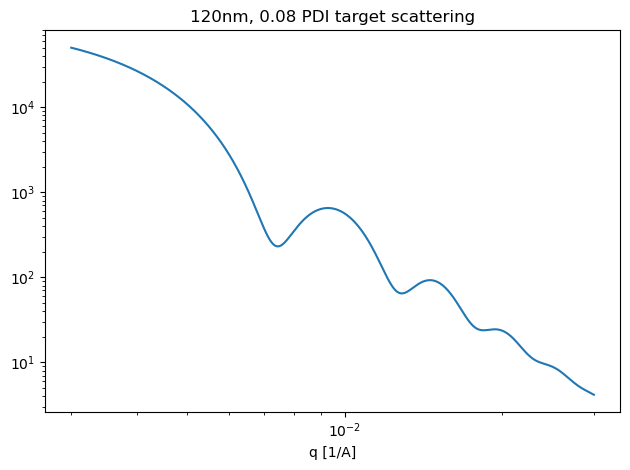

In [27]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')
ax.set_title('120nm, 0.08 PDI target scattering')
plt.tight_layout()
plt.savefig('target_profile_120nm.png', dpi = 300)

## Run full processing pipeline

In [29]:
processing_dataset = {}
counter = 0
for uuid_val, data_val in sample_data.items():
    print(f'{counter}: {uuid_val}')
    counter += 1
    meas_entry = {}
    meas_entry['original_data'] = data_val[0]
    background = uuid2bkg[uuid_val]
    meas_entry['background'] = background[0]
    # 1. Subtract background and select q range
    subtracted = subtract.chop_subtract(data_val[0], background[0], hiq_thresh=1)
    
    if subtracted is None:
        # if subtract returned None, data has issues and we are done with this sample
        meas_entry['status'] = 'failed'
        meas_entry['failure_point'] = 'background_subtraction'
        processing_dataset[uuid_val] = meas_entry
        print(f'Sample {uuid_val} failed at background subtraction')
        continue
        
    else:
        # q range selection
        subtracted = subtracted[subtracted['q'] < q_max_subtract]
        subtracted = subtracted[~subtracted['I'].isna()]
        subtracted = subtracted[subtracted['I'] > 0] # drop negative values 
        # screen on dataset length
        if len(subtracted) < min_data_len:
            meas_entry['status'] = 'failed'
            meas_entry['failure_point'] = 'subtracted_data_length'
            processing_dataset[uuid_val] = meas_entry
            print(f'Sample {uuid_val} failed due to data length')
            continue
        else:
            meas_entry['subtracted_clipped'] = subtracted
            meas_entry['status'] = 'valid'
            processing_dataset[uuid_val] = meas_entry


    # 2. Convert everything into log10 space
    q_log = np.log10(subtracted['q'].to_numpy())
    I_log = np.log10(subtracted['I'].to_numpy())

    meas_entry['q_log'] = q_log
    meas_entry['I_log'] = I_log
    
    # 3. denoise filter on intensity
    
    I_savgol = manipulate.denoise_intensity(I_log, savgol_n = savgol_n, savgol_order = savgol_order)

    meas_entry['I_savgol'] = I_savgol

    # 4. Spline fit and interpolate
    I_spline = manipulate.fit_interpolate_spline(q_log, I_savgol, q_grid, s = s, k = k)
    
    meas_entry['I_spline'] = I_spline

    # 5. scale onto target
    I_scaled = manipulate.scale_intensity_highqavg(I_spline, target_I, n_avg = n_avg)

    meas_entry['I_scaled'] = I_scaled

    #6. Calculate AP distance

    #amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)

    #ap_sum = amplitude + phase

    #meas_entry['amplitude_distance'] = amplitude
    #meas_entry['phase_distance'] = phase
    #meas_entry['ap_sum_distance'] = ap_sum

    processing_dataset[uuid_val] = meas_entry
    

0: 770a433d-0480-4cee-bf12-ce066c24db55
1: fed3ab35-04e9-4916-8527-8627191a3bdc
2: 4ab46dcc-3395-4e7b-bb87-52e805e12abb
3: 23850c30-c572-41ad-abf0-7e1bd4fa7397
4: 96ef6012-d812-4975-8b77-8ed7e78669fb
5: d03dab18-5712-44f7-9334-14047212632e
Sample d03dab18-5712-44f7-9334-14047212632e failed due to data length
6: a180d359-a229-4b3e-a615-2991fd549f42
7: ef17f542-90a3-44a8-a6b8-acb920953fab
8: e0368e49-ecc3-4ebf-9a19-4e942c829517
9: 4d5fd07b-987b-49df-b4ba-54d2a337d945
Sample 4d5fd07b-987b-49df-b4ba-54d2a337d945 failed due to data length
10: 6b50a94f-b7f2-402e-a210-e89f507b8861
1.0032446657458967
0.38497799799584187
78
11: 657e707f-abc9-4f86-ae1e-9e59efb6e1f9
Sample 657e707f-abc9-4f86-ae1e-9e59efb6e1f9 failed due to data length
12: 0e6edb88-77c3-4984-a38d-198341bba9e1
13: 32ec16b1-c5b5-4d8b-b396-cd1ad4b740d9
14: a4d8a8f6-2654-490f-b14a-02d3fb1f94b2
15: 3584700a-8b01-4e59-a53a-1300fd3fac0a
16: fa1dfc55-e5e0-4514-a66a-e29a5351518a
1.249238472215957
0.5377320753723704
39
17: 68831f53-4a51-4f1

### Sanity check subtraction

770a433d-0480-4cee-bf12-ce066c24db55
fed3ab35-04e9-4916-8527-8627191a3bdc
4ab46dcc-3395-4e7b-bb87-52e805e12abb
23850c30-c572-41ad-abf0-7e1bd4fa7397
96ef6012-d812-4975-8b77-8ed7e78669fb
d03dab18-5712-44f7-9334-14047212632e
failed at  subtracted_data_length
a180d359-a229-4b3e-a615-2991fd549f42
ef17f542-90a3-44a8-a6b8-acb920953fab
e0368e49-ecc3-4ebf-9a19-4e942c829517
4d5fd07b-987b-49df-b4ba-54d2a337d945
failed at  subtracted_data_length
6b50a94f-b7f2-402e-a210-e89f507b8861
657e707f-abc9-4f86-ae1e-9e59efb6e1f9
failed at  subtracted_data_length
0e6edb88-77c3-4984-a38d-198341bba9e1
32ec16b1-c5b5-4d8b-b396-cd1ad4b740d9
a4d8a8f6-2654-490f-b14a-02d3fb1f94b2
3584700a-8b01-4e59-a53a-1300fd3fac0a
fa1dfc55-e5e0-4514-a66a-e29a5351518a
68831f53-4a51-4f12-b385-10c50c8fab46
4bec4e18-80bb-44d9-8508-cc464f14b287
41414be7-3e27-4b4d-b70e-e31d54a733d3
81f8f6c2-0e42-4680-bc11-c0be02bfd641
47d95862-b511-4a42-b8b1-961b605f26a3
6abcfcc8-cf8d-4a5e-a92f-f3afd8023fbd
89b8593e-8436-4dfb-8430-1367d273cbc2
8559907a-1

/tmp/ipykernel_258264/1424264336.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


48c60f84-a45b-4017-9430-12b3234fdc0e
2a0a2e87-67a7-401a-943d-423159a4a939
43cd6089-f940-463f-bd40-a1f2bf168f67
9b9c349b-8f9d-4f0c-829c-fa99e67e90fb
ff3ac045-3c39-4fb0-b2c9-bf69d7600548
failed at  subtracted_data_length
5452fa4a-b64c-46d7-ace2-bf1b31afc3b3
failed at  subtracted_data_length
9aed2e5c-7127-46bd-8331-51407d127d8f
5edc0763-1f2c-44f2-bf68-db785ae258b0
320cdd85-691d-48fb-9eac-d27b2fc5e5f5
bf04b495-3291-4508-a497-e6d96dc52362
649ddf37-37fe-4a30-896b-010286133a28
failed at  subtracted_data_length
5175dc78-a900-486e-8b14-6b0441555fe2
2a988138-57f5-40bf-851c-3df09f642f05
9694a191-11f7-482c-bb4c-e119489126a4
a9d67fc5-2e59-4f51-a904-9cac957c9e73
2027f32f-4921-4edd-95bb-849ab8220e8c
f5458994-6b3e-4176-9427-7cef2bb6c7d5
5d67ff81-9548-4a2f-9496-5d3c3c25b3eb
f4b66637-2c73-4d0b-83ba-3f7e3b3f3c06
56898b1b-5aed-4595-ade6-5b73d45a7808
f2e85141-9985-49ff-a6bc-17e2ecbcdc8b
failed at  subtracted_data_length
7c4bcab3-4ce3-4a28-92b1-4f8a04c76603
38d80e08-5bd4-4e0e-9d11-a60d55148590
8573b7f6-c239

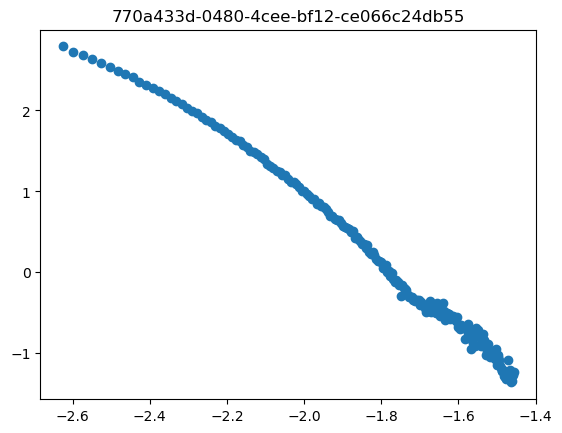

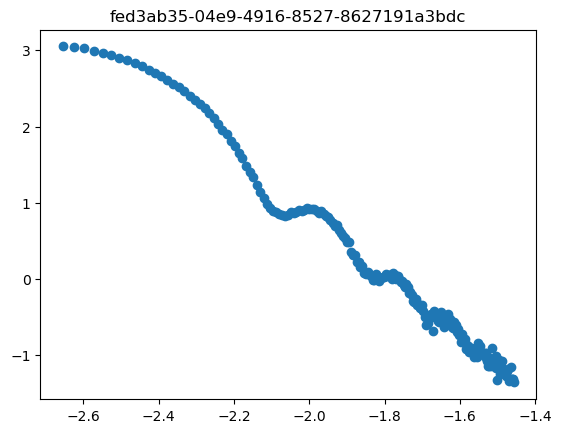

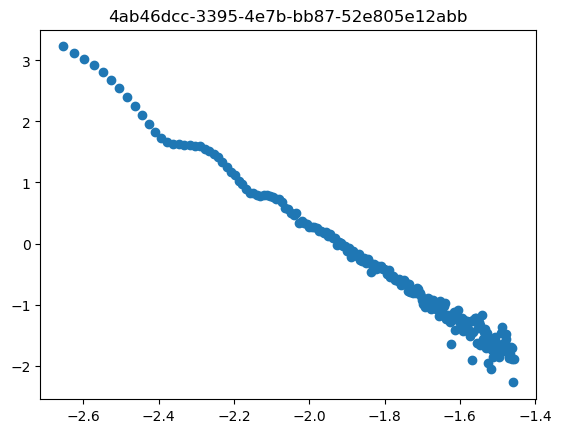

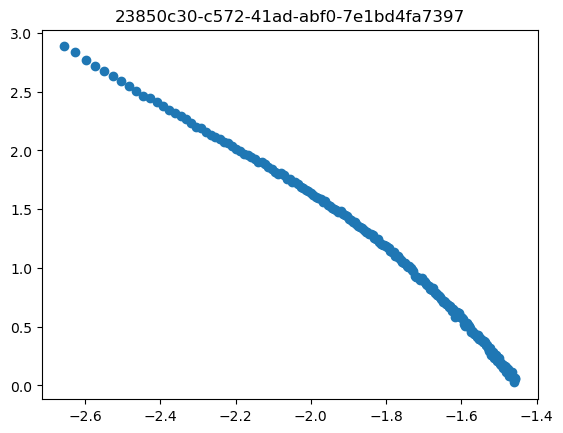

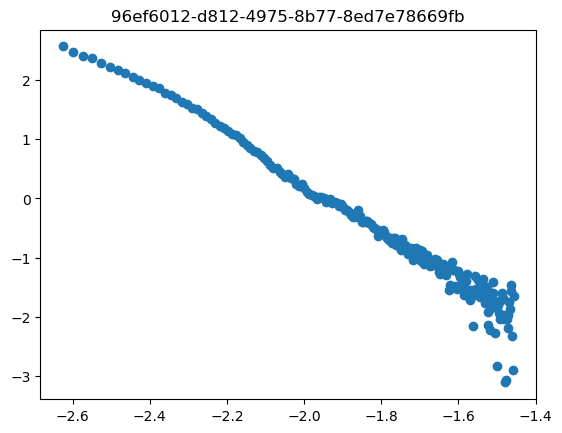

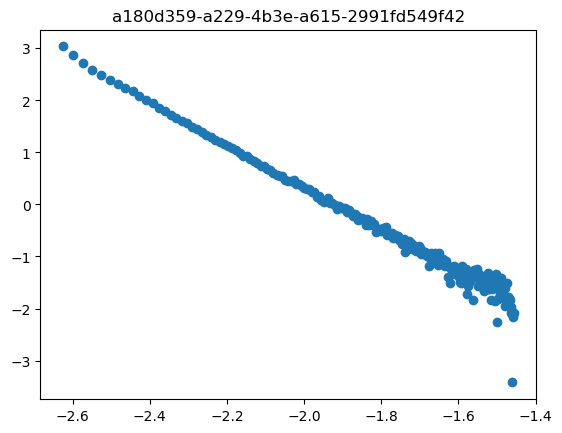

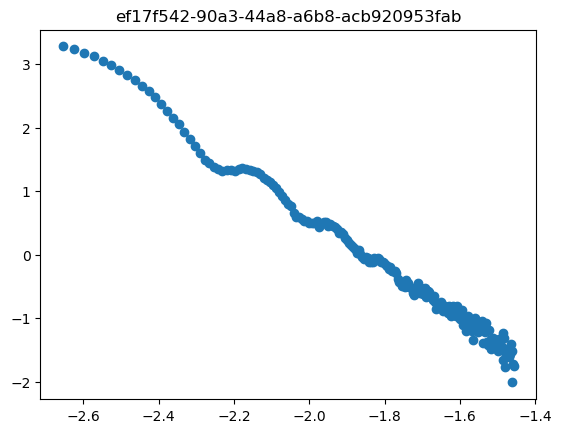

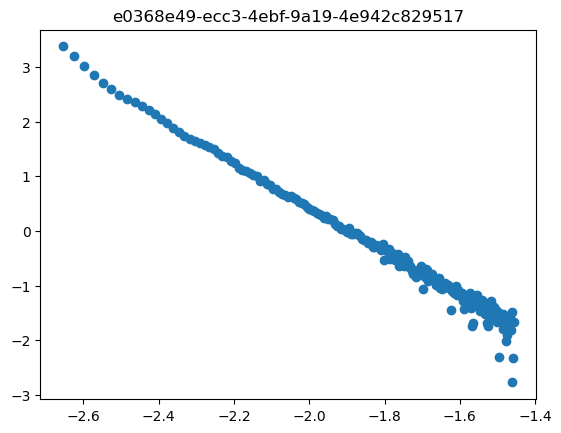

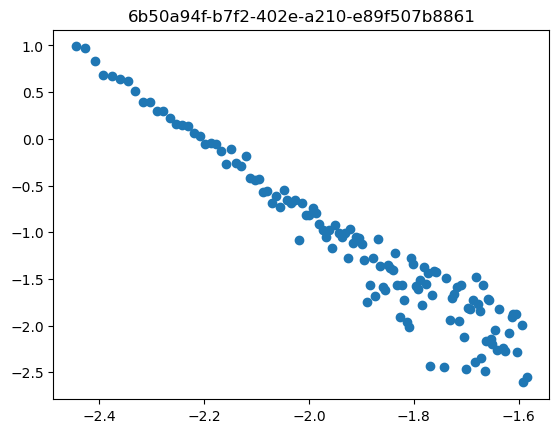

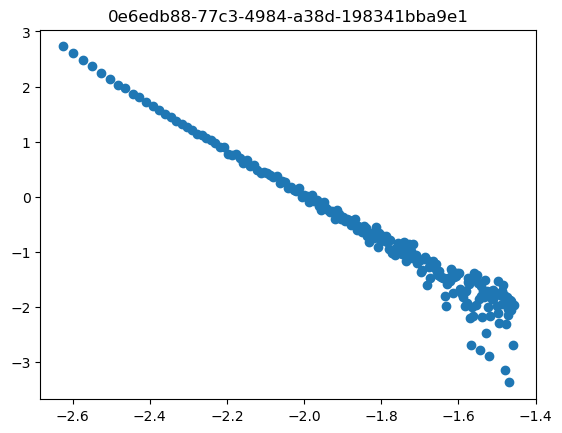

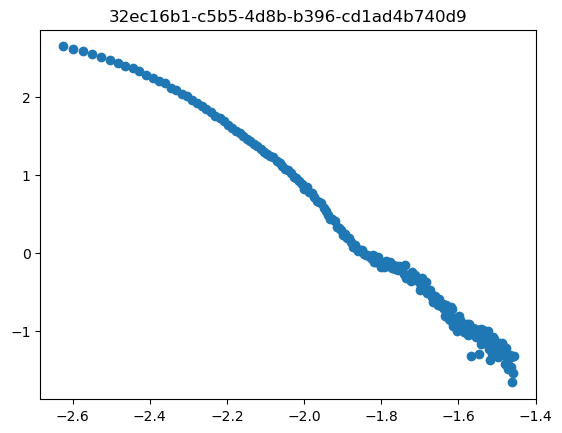

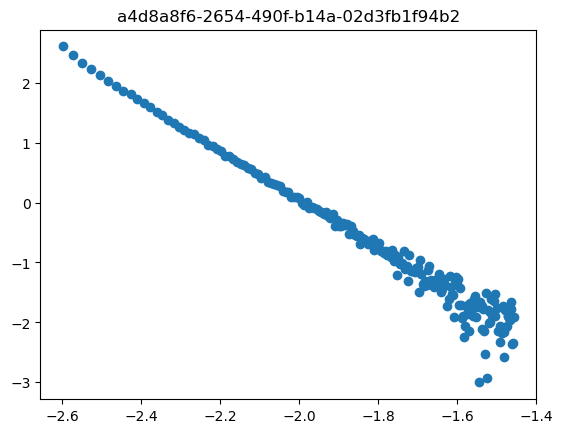

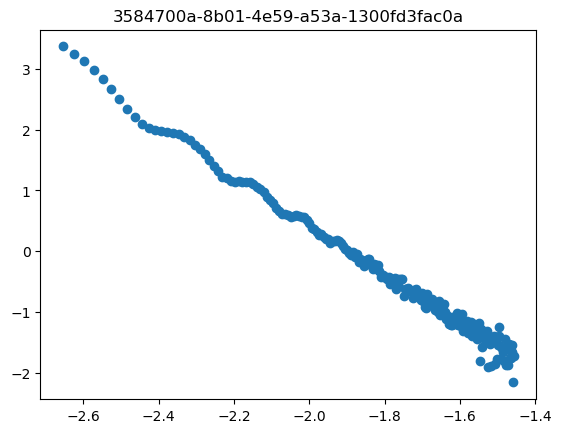

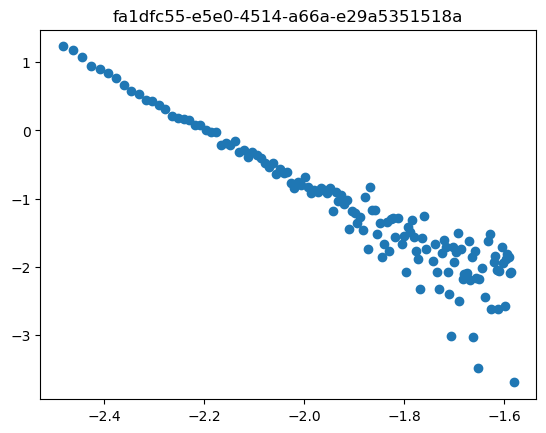

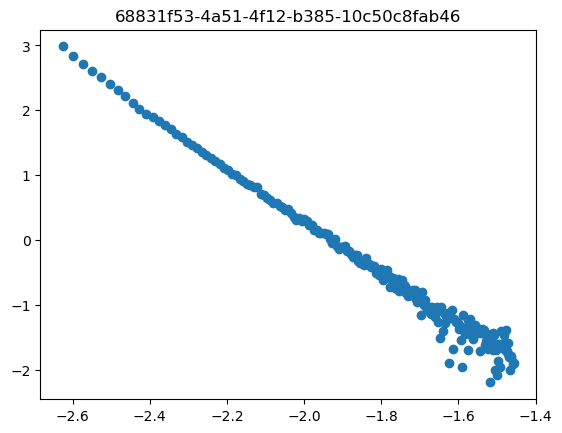

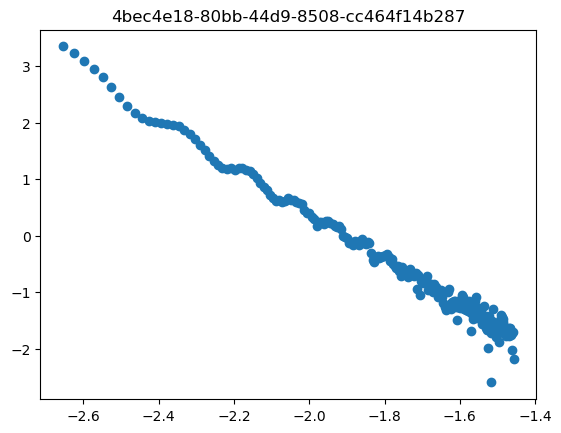

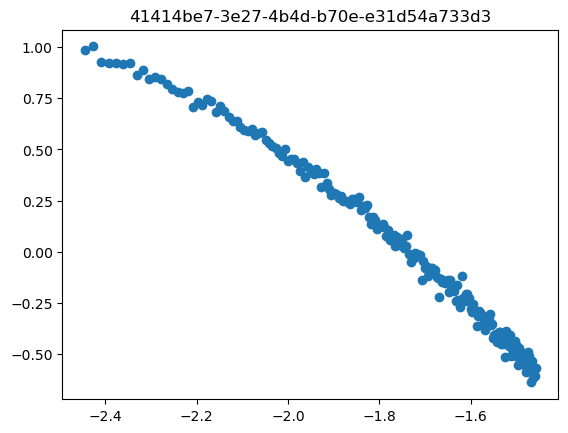

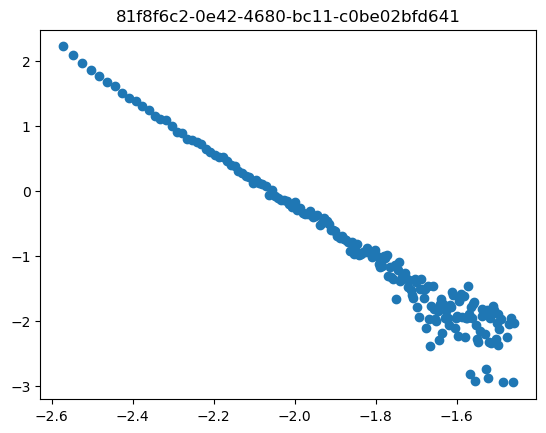

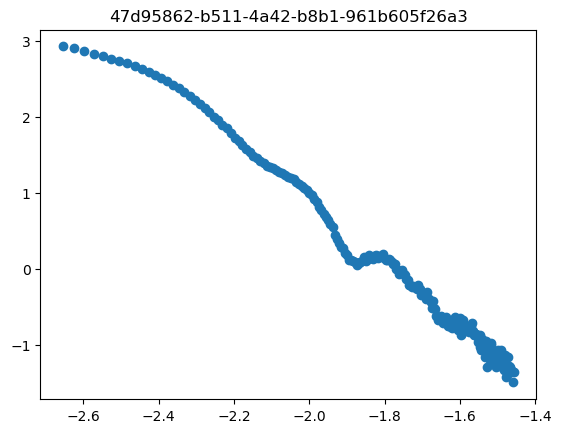

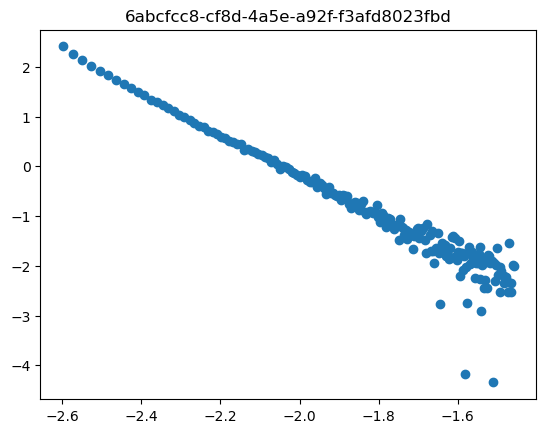

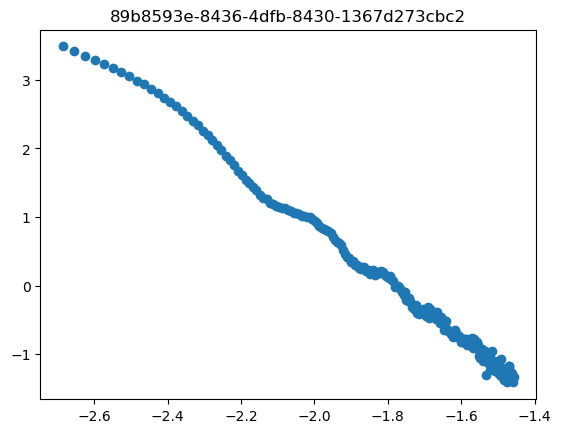

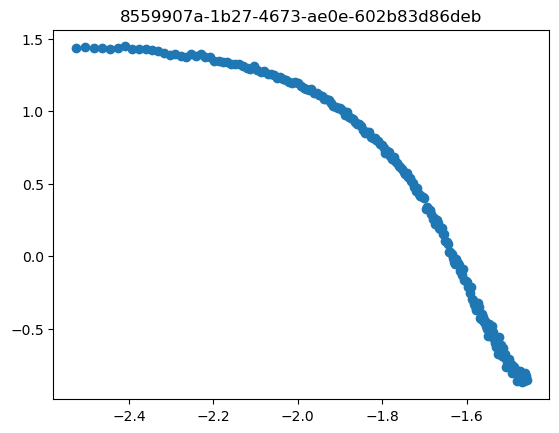

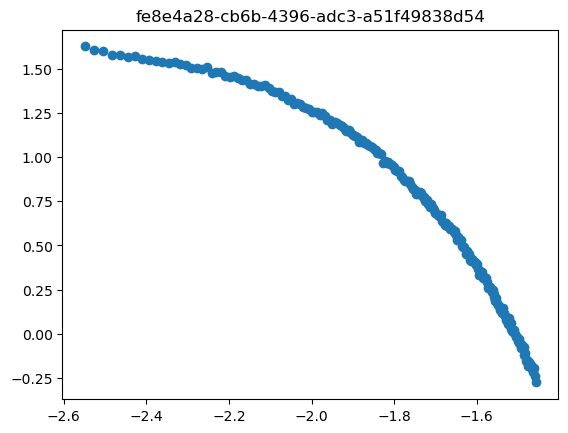

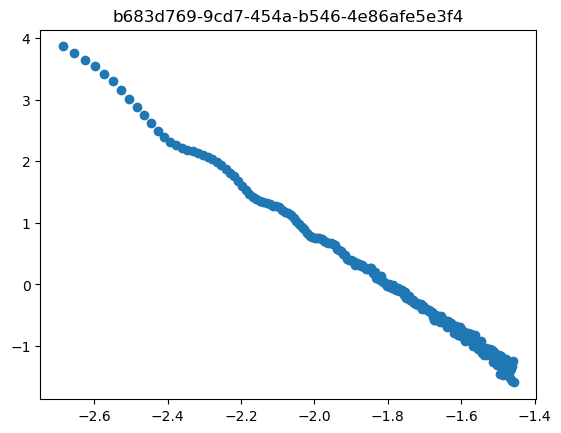

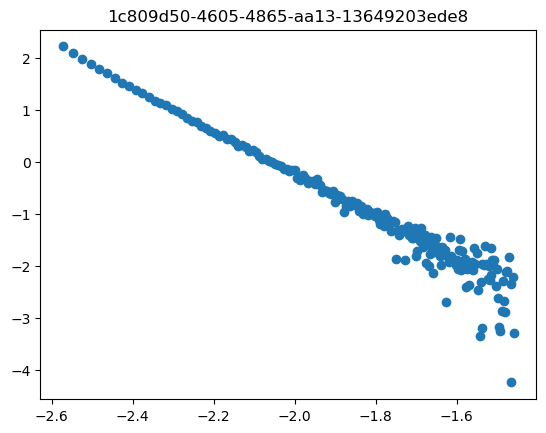

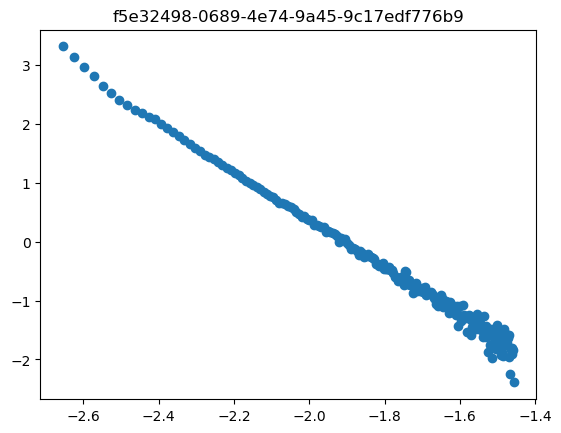

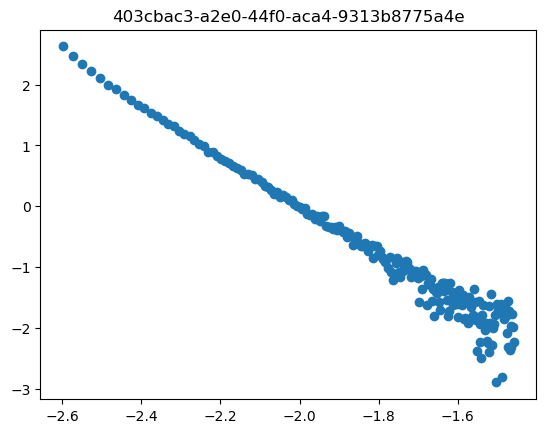

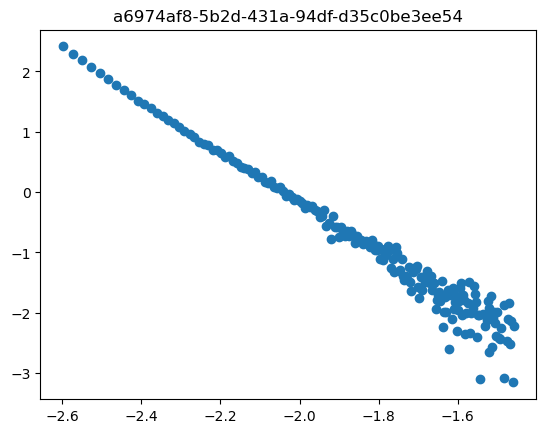

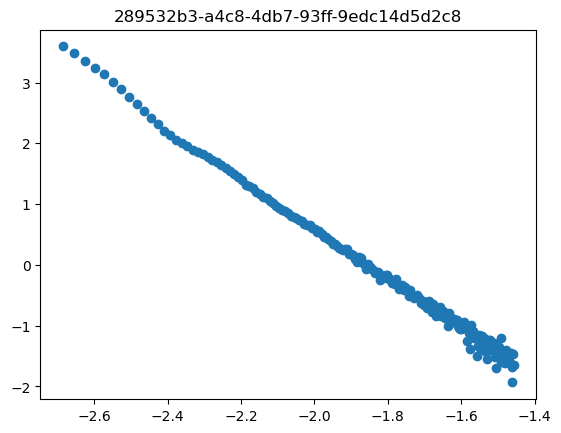

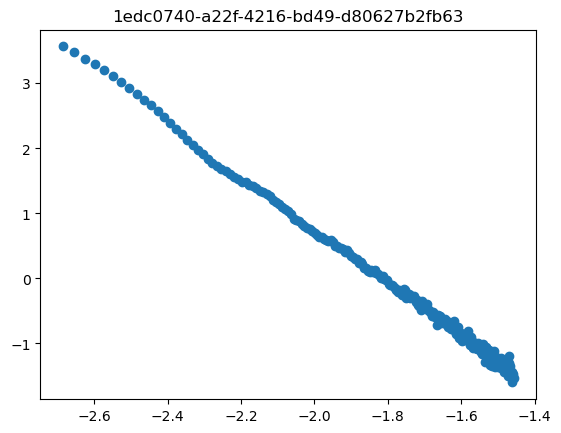

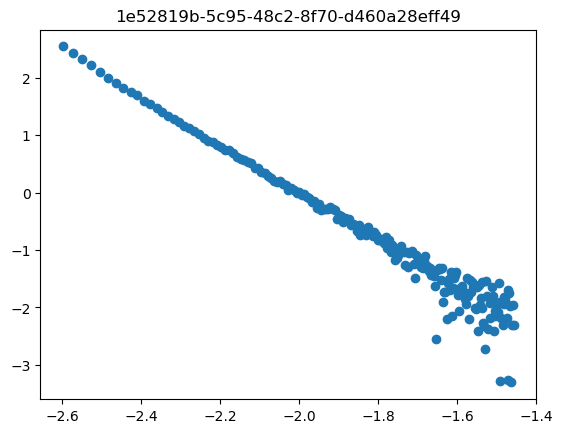

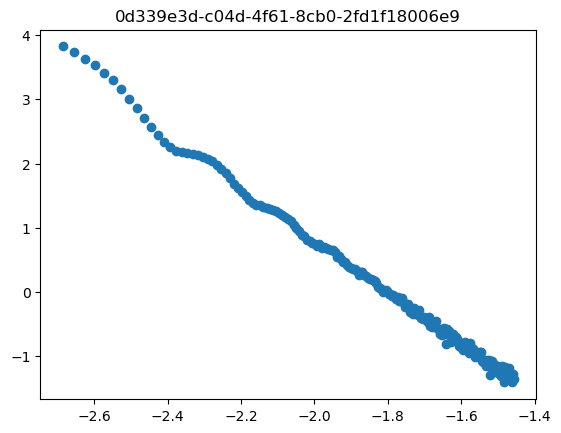

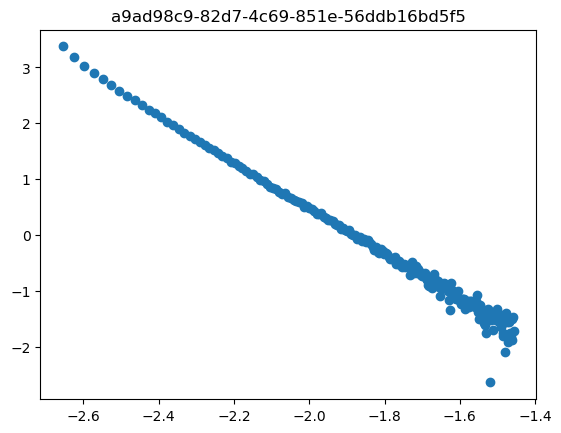

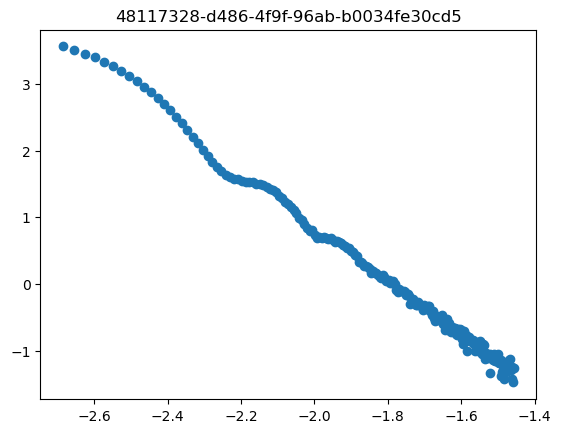

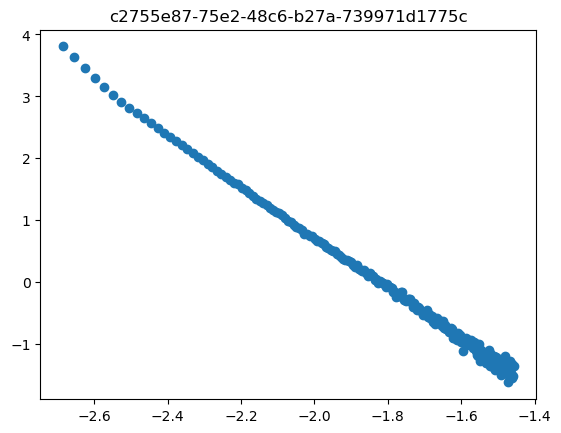

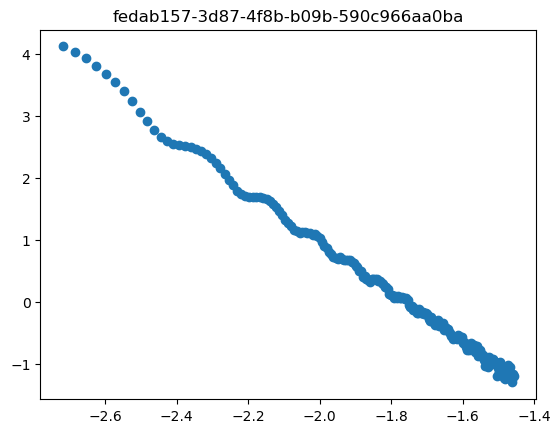

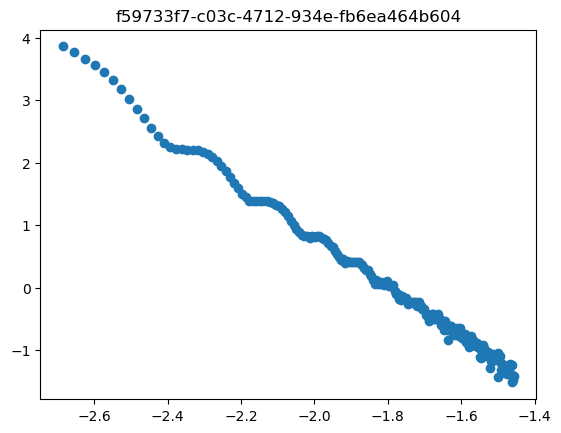

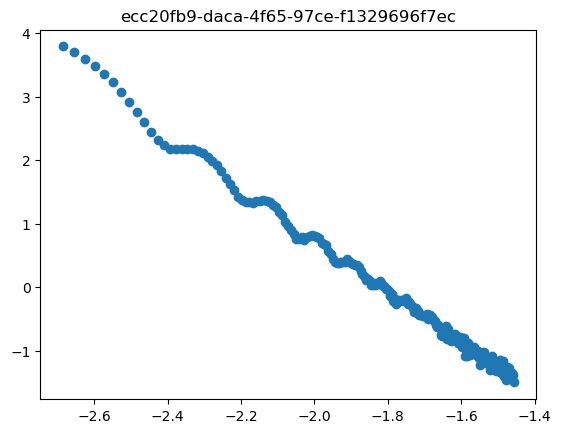

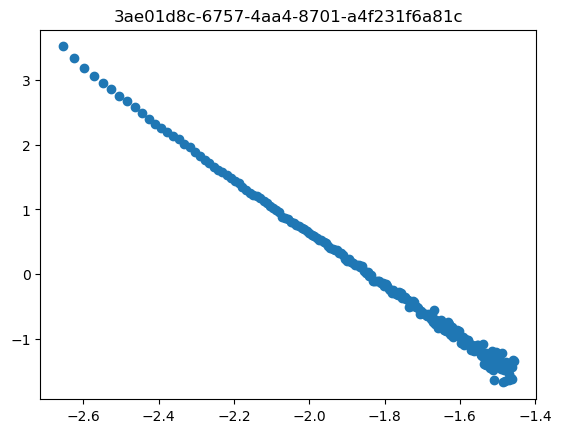

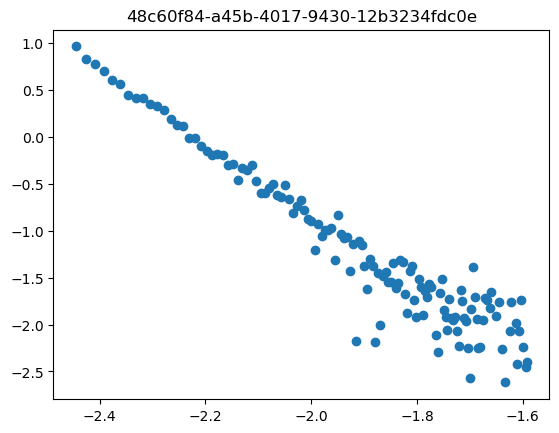

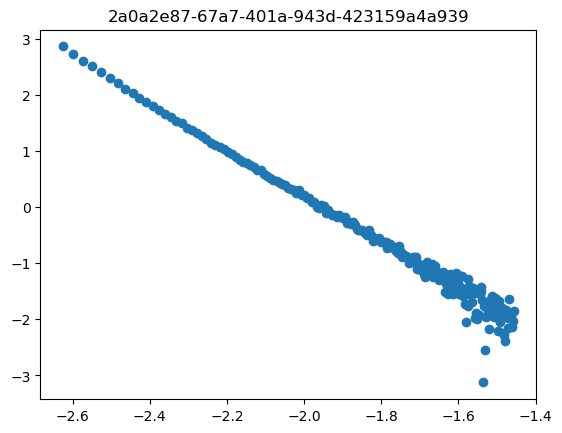

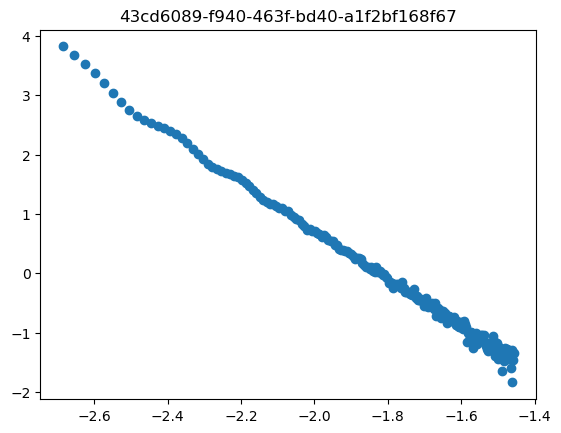

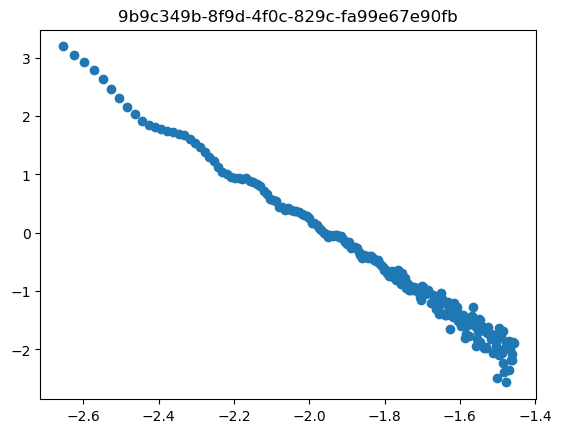

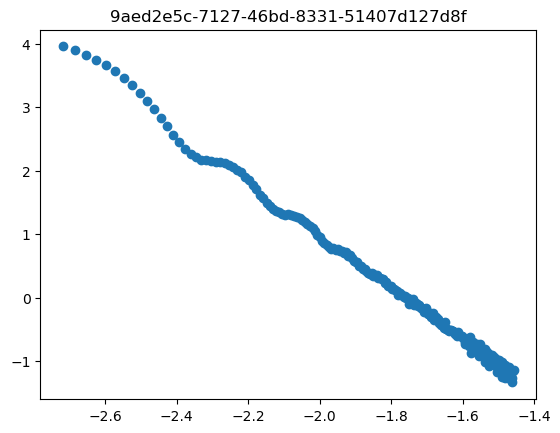

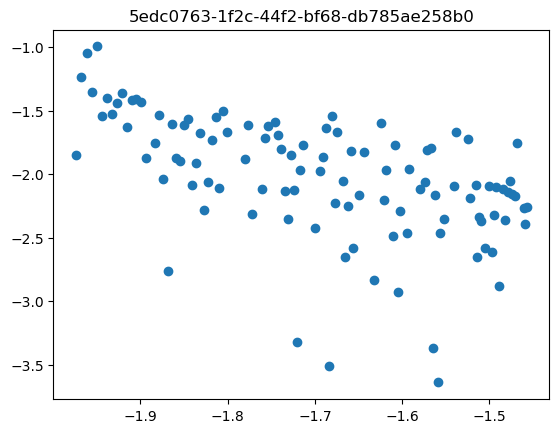

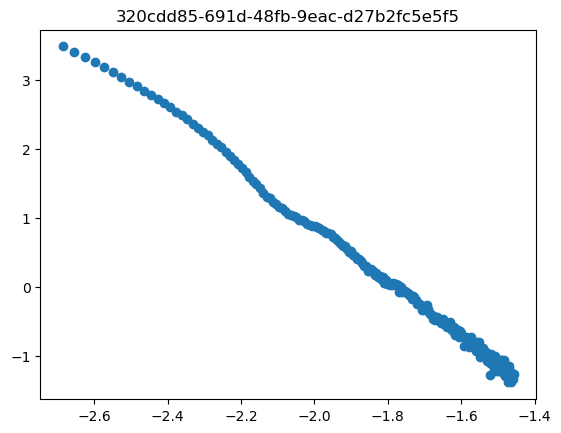

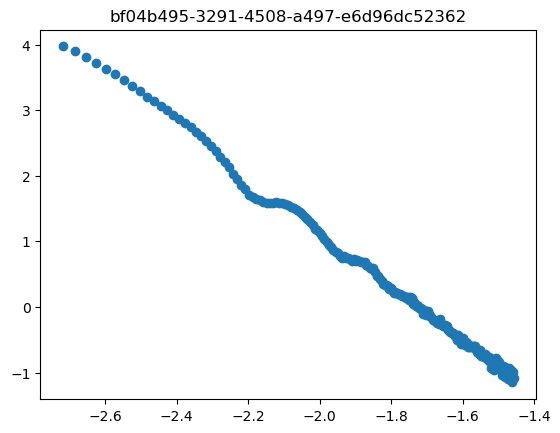

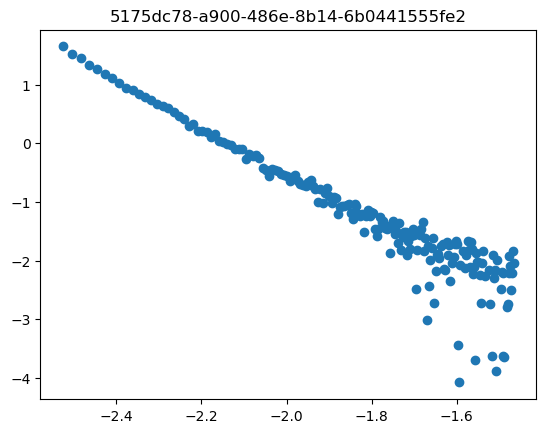

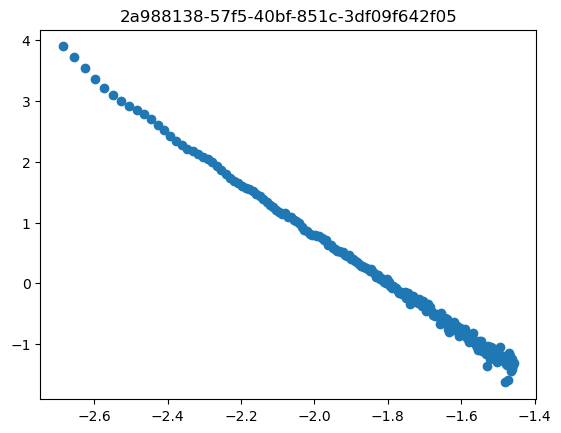

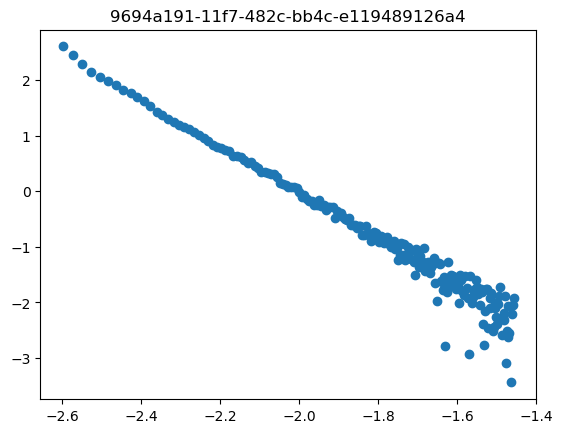

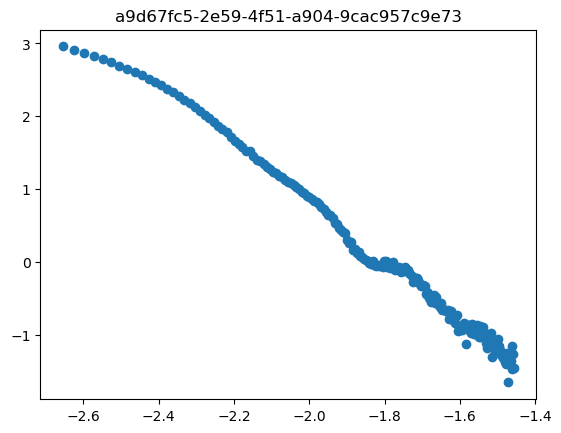

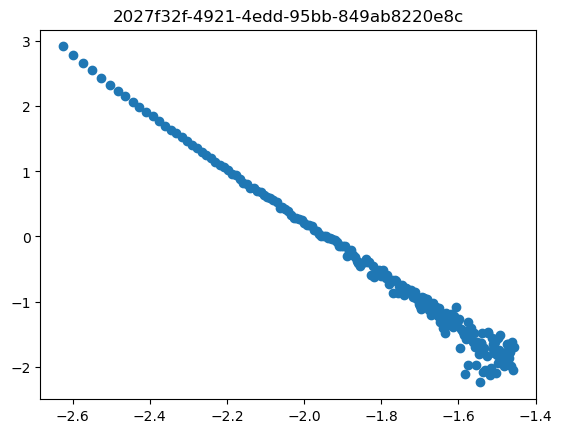

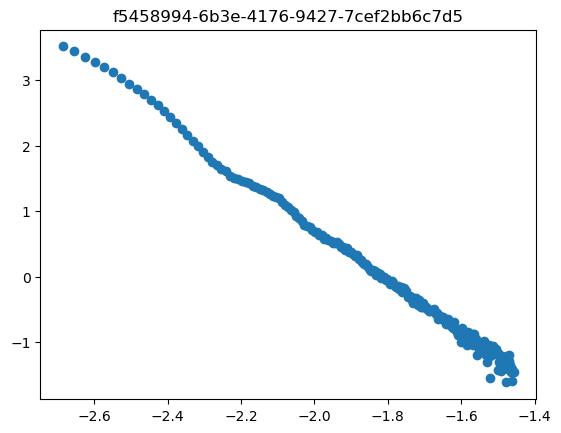

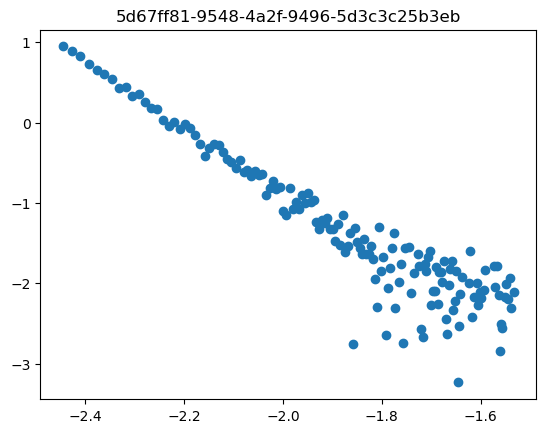

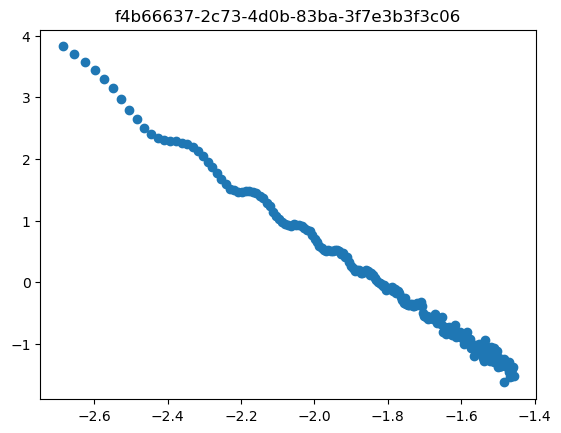

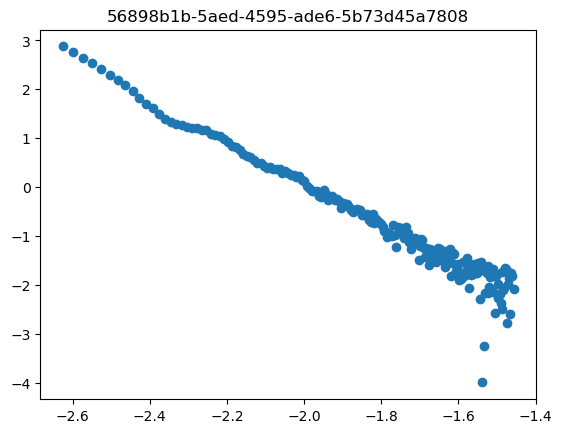

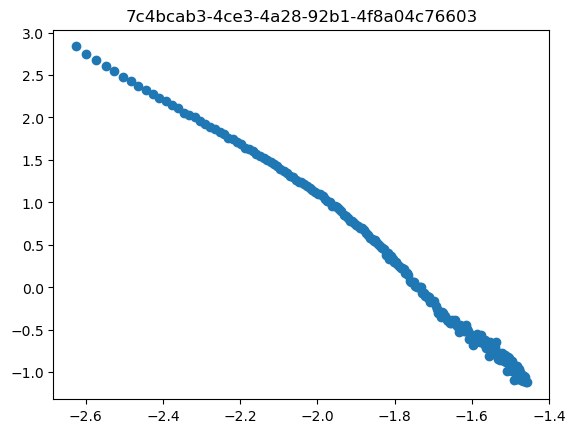

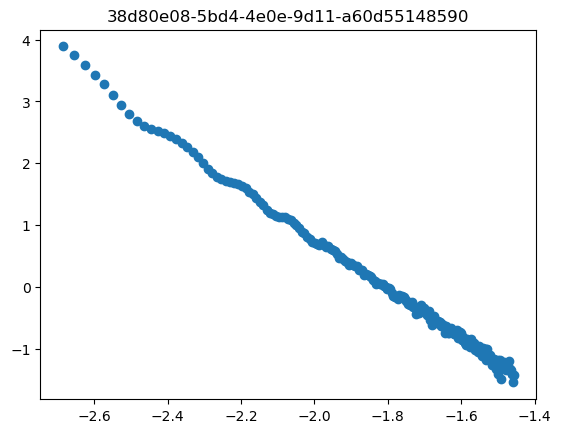

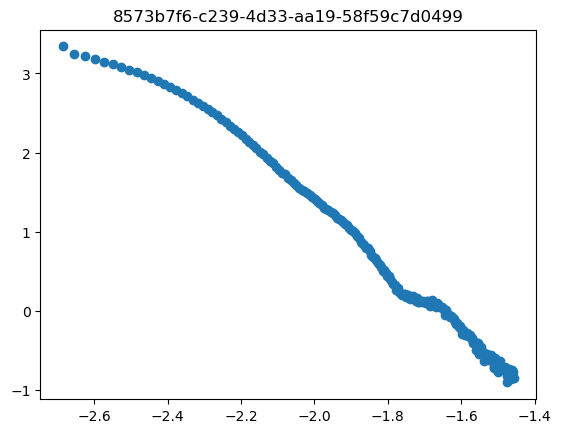

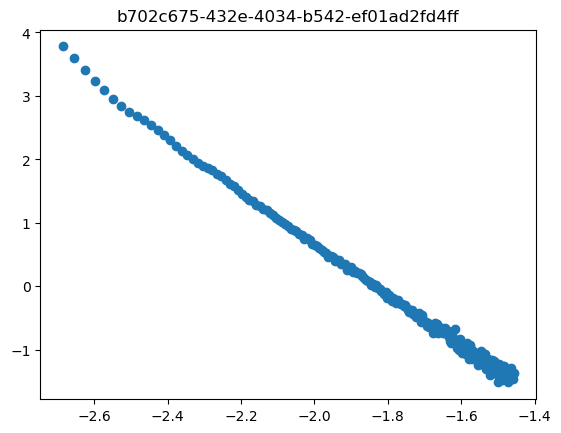

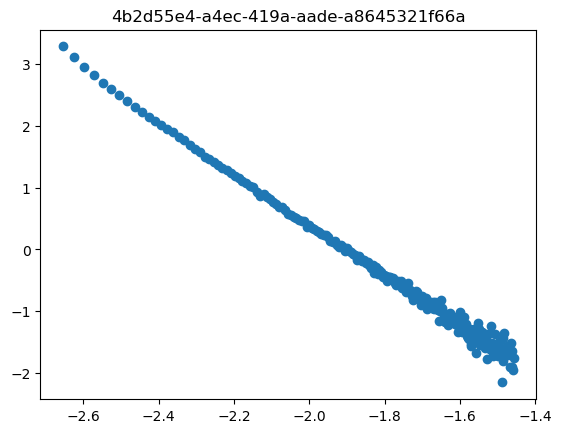

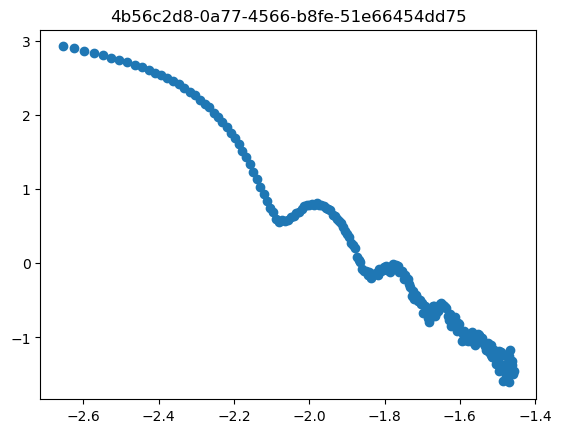

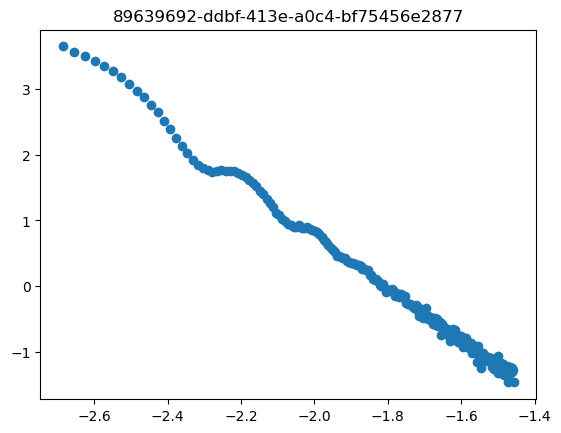

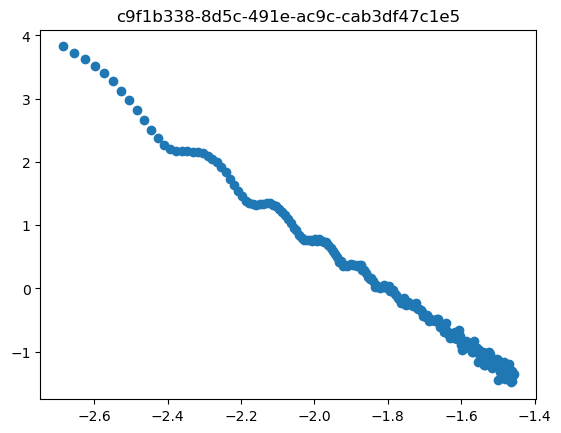

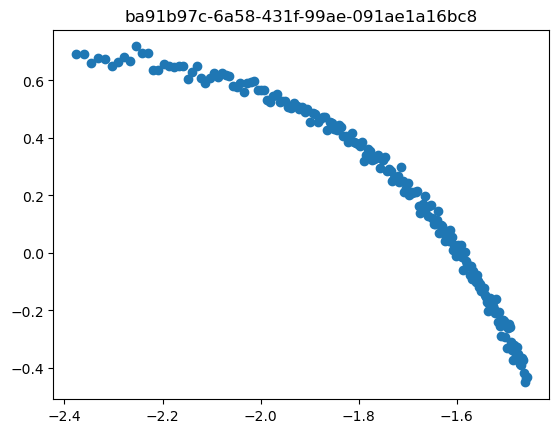

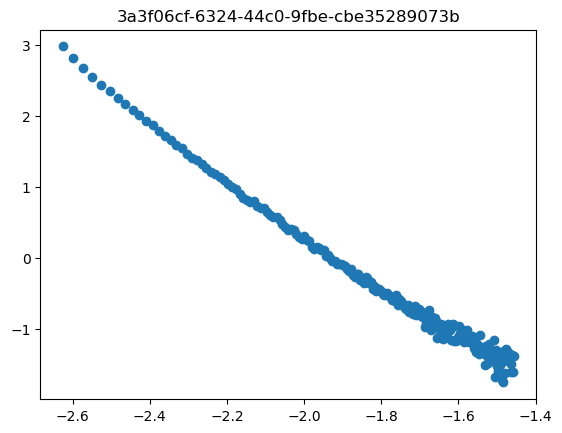

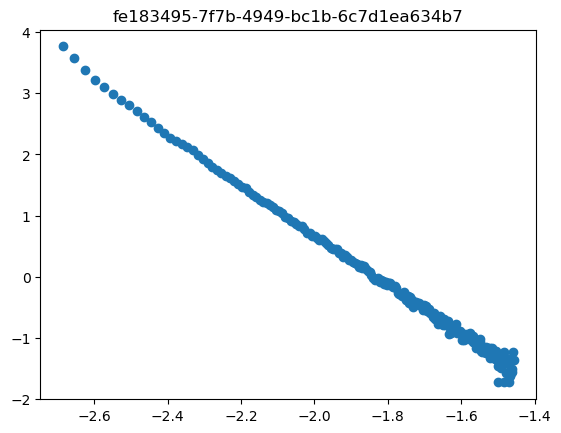

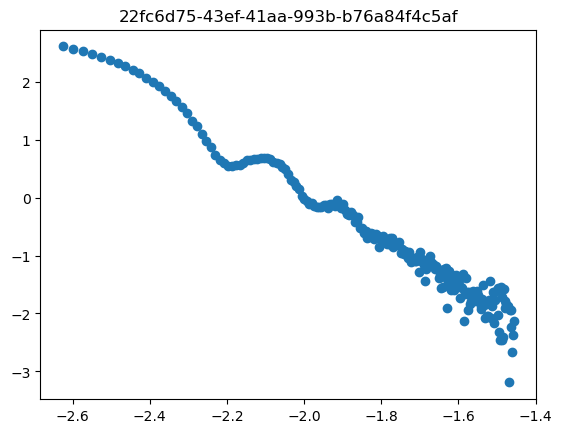

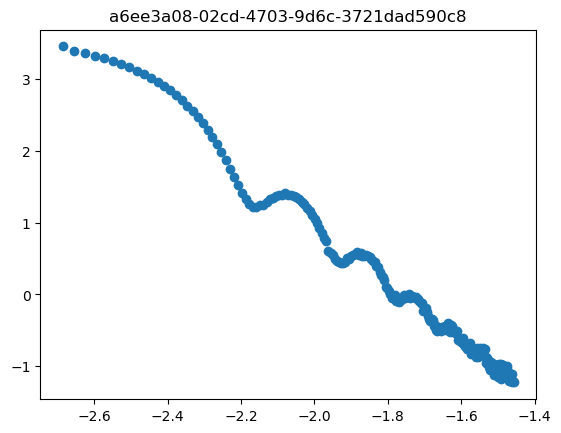

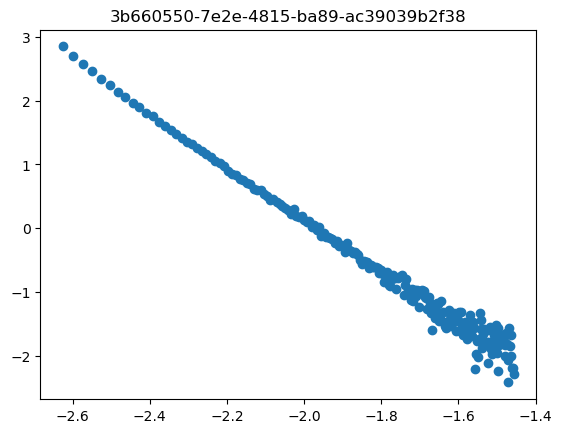

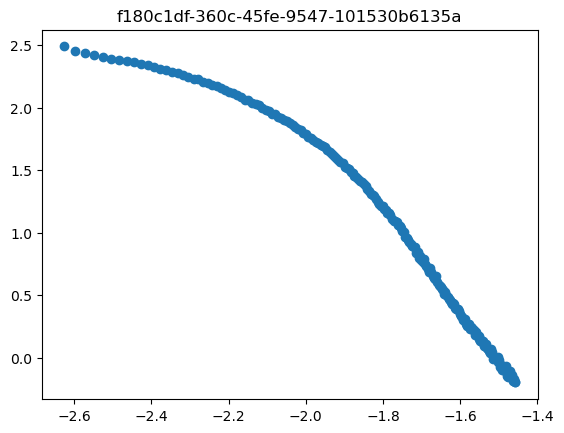

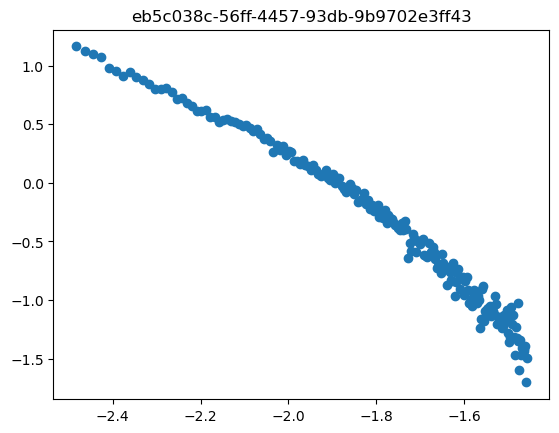

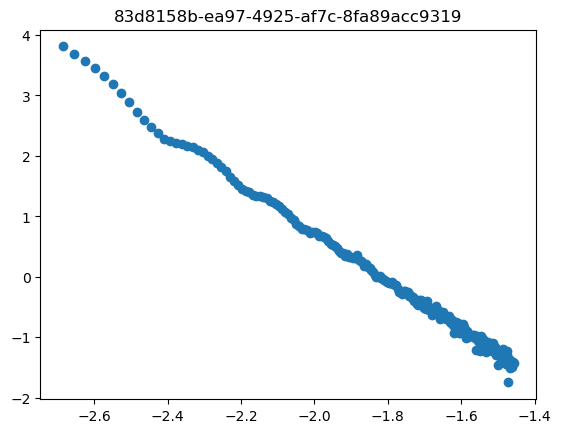

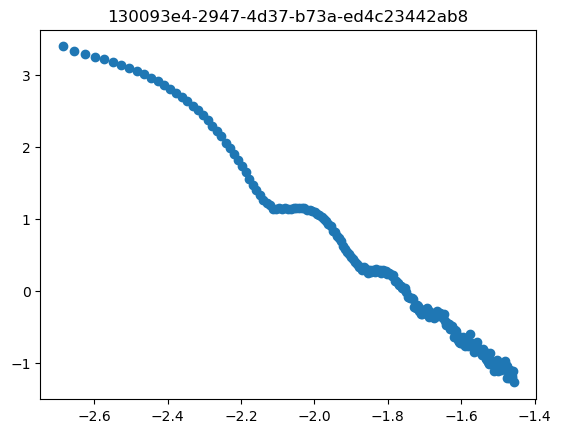

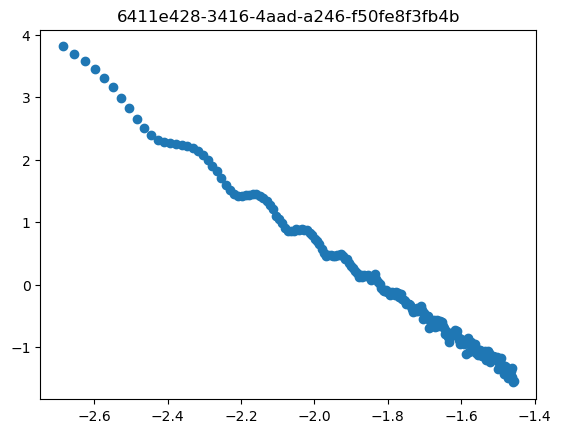

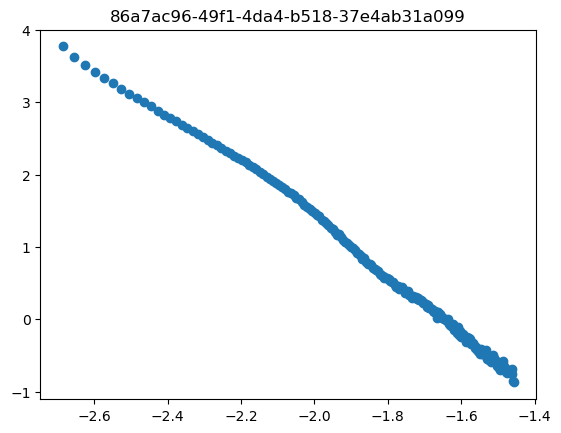

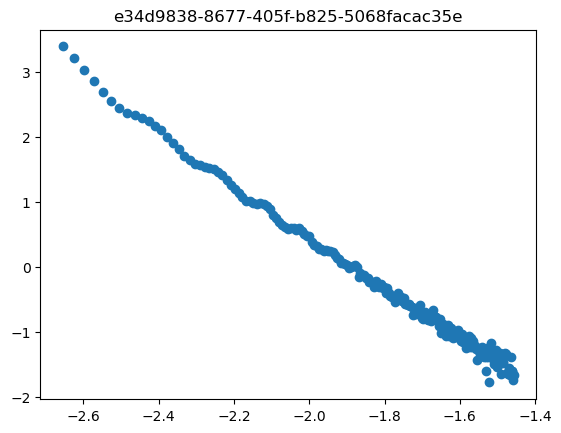

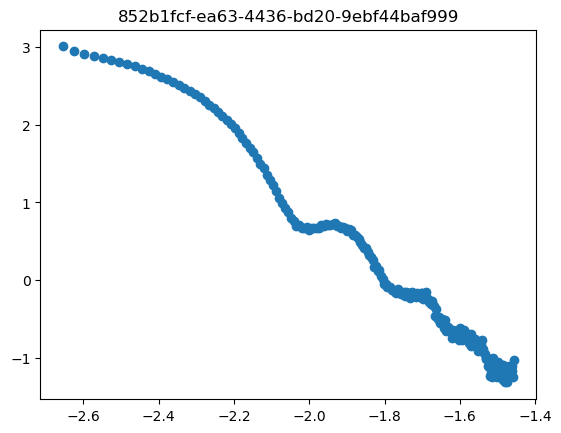

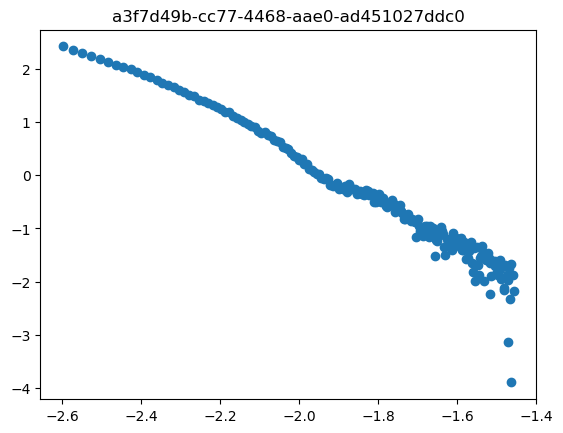

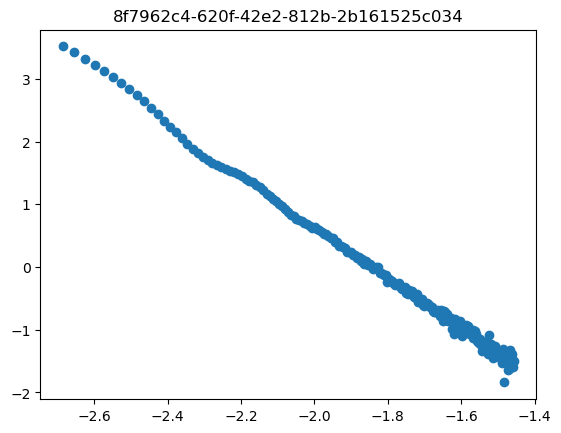

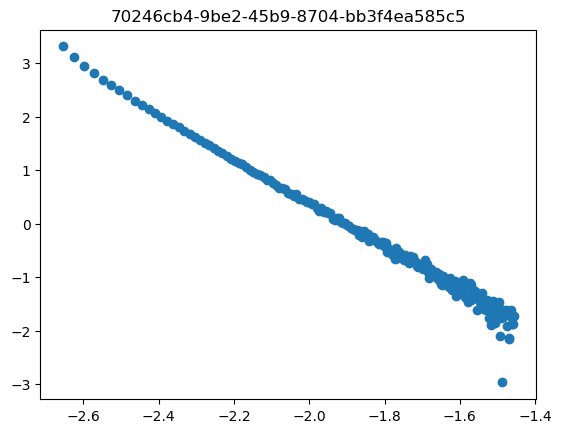

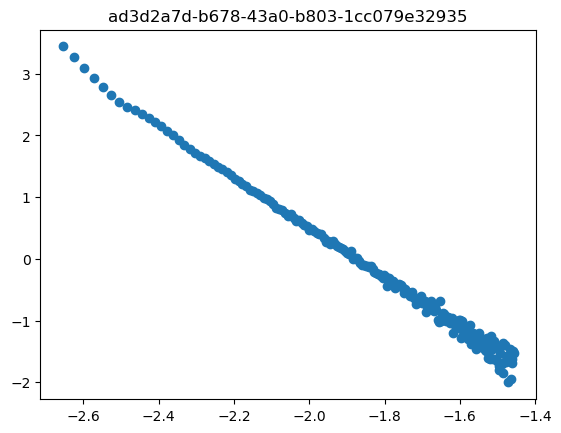

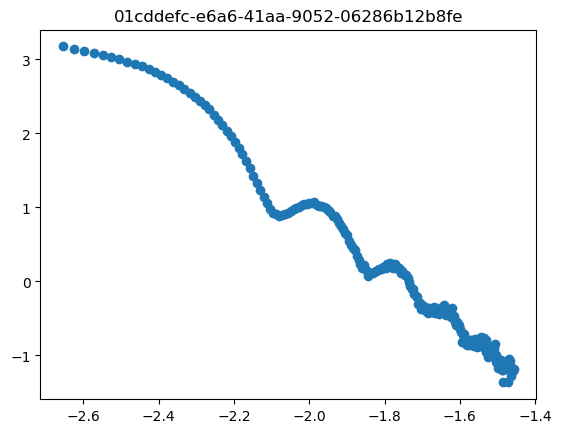

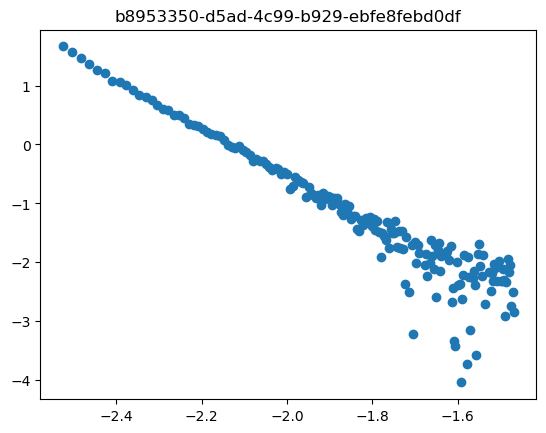

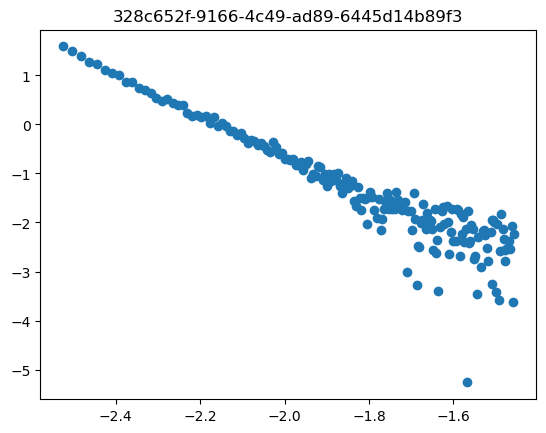

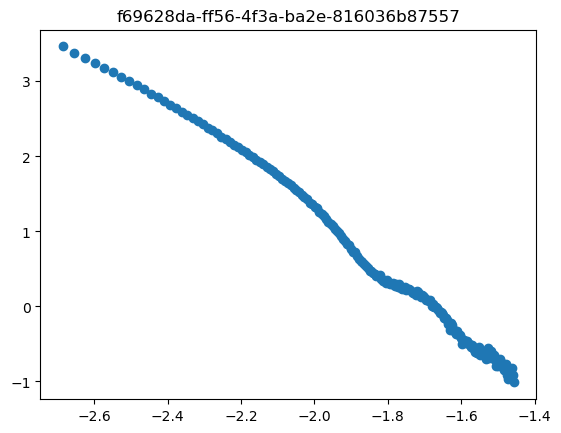

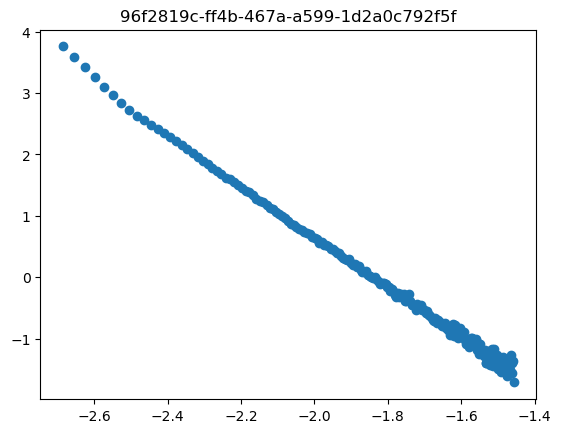

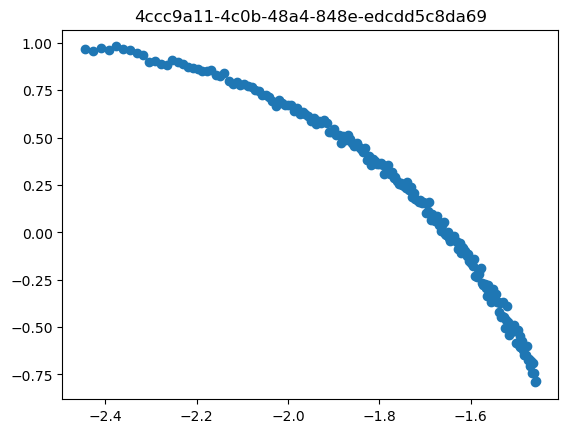

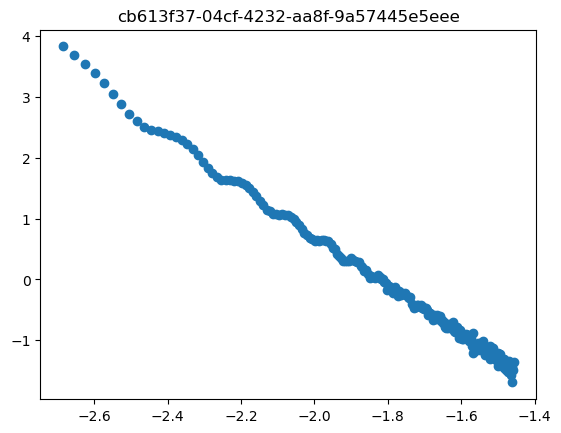

In [30]:
for uuid_val, entry in processing_dataset.items():
    print(uuid_val)
    try:
        status = entry['status']
        if status == 'failed':
            print('failed at ', entry['failure_point'])
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']
    
        ax.scatter(q, I_subtracted)
        ax.set_title(uuid_val)

## Sanity check spline fit

/tmp/ipykernel_258264/3859189070.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


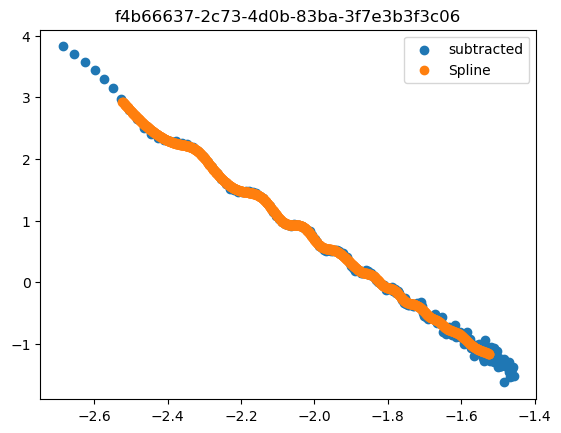

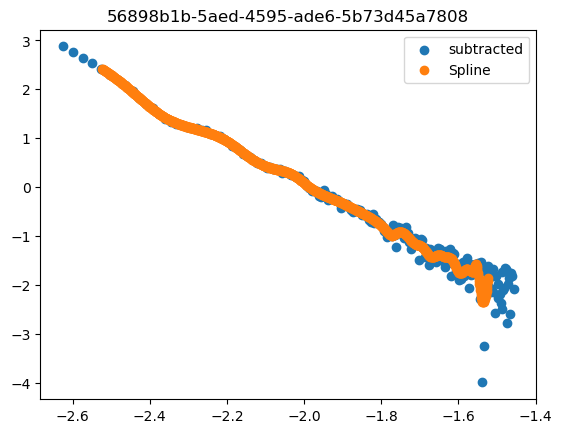

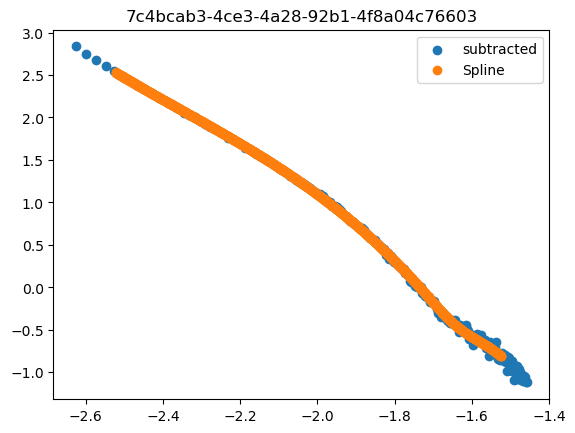

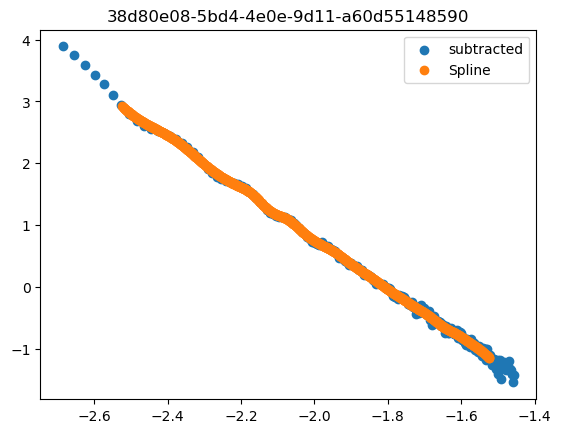

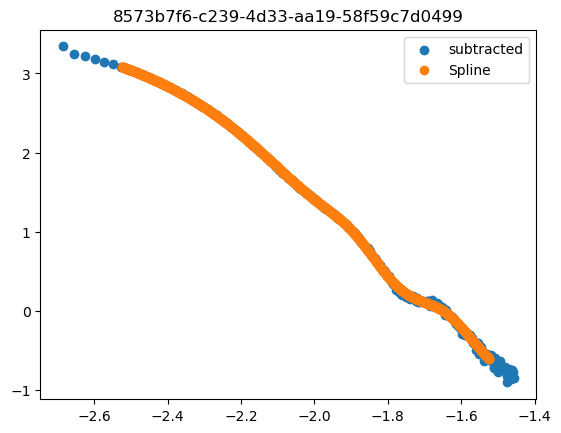

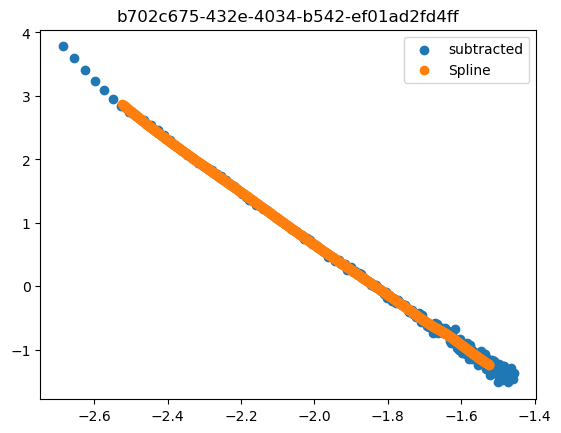

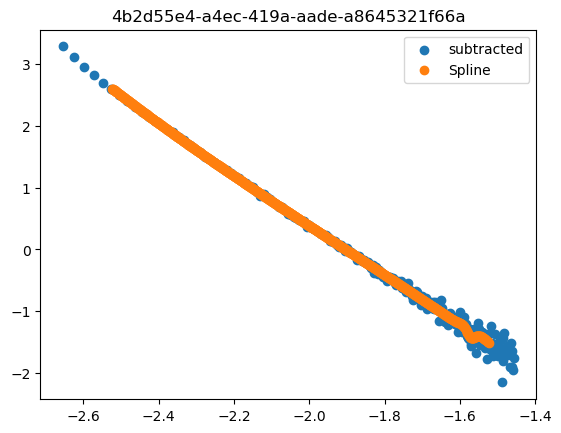

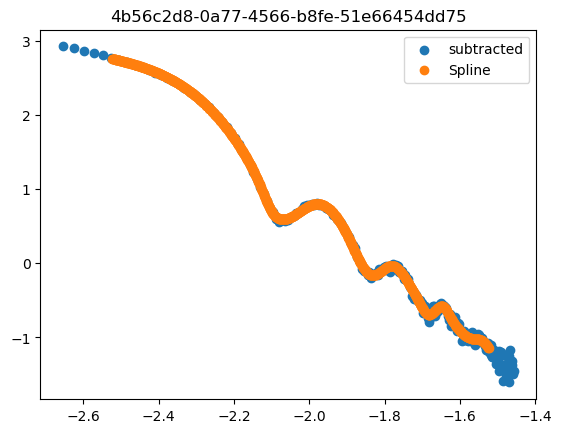

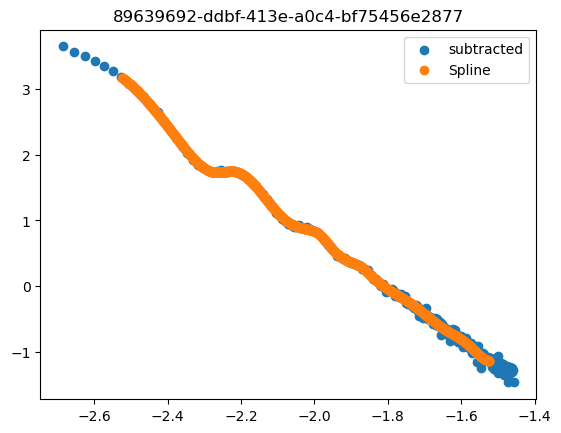

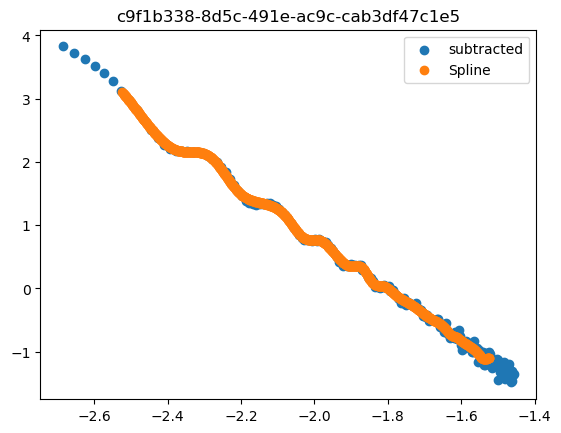

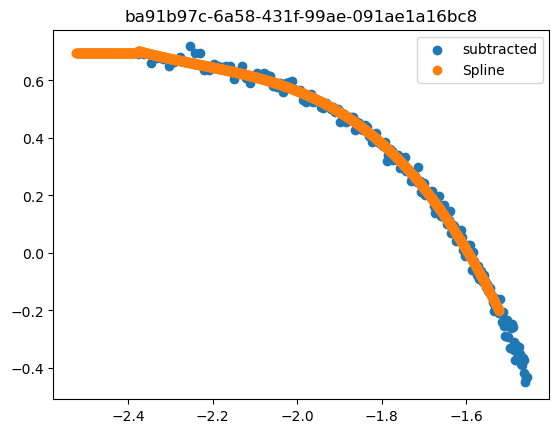

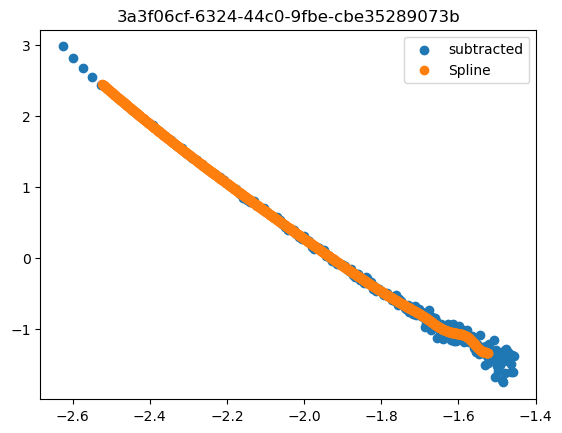

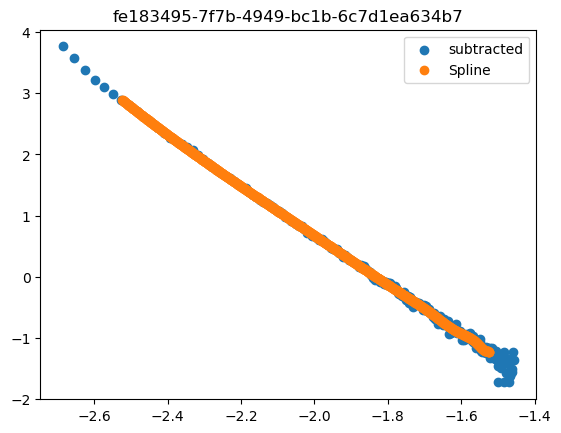

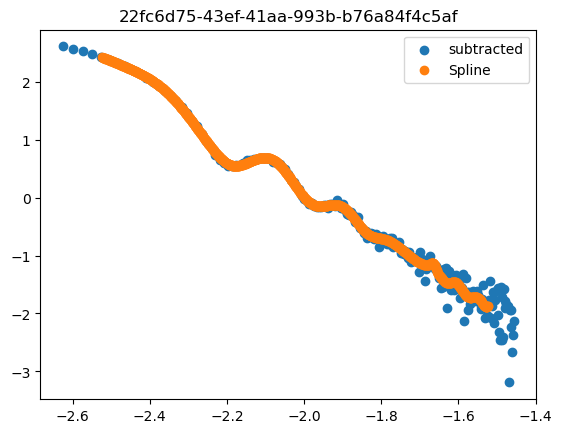

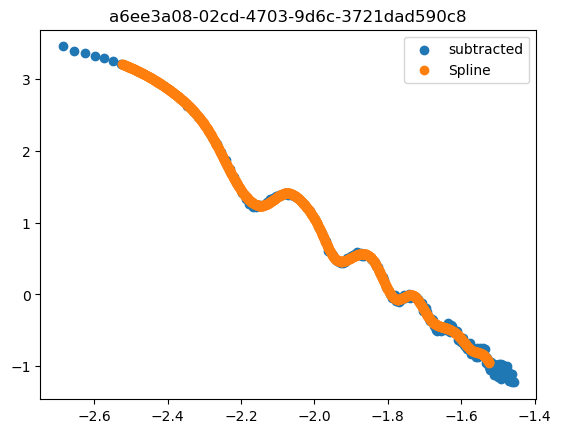

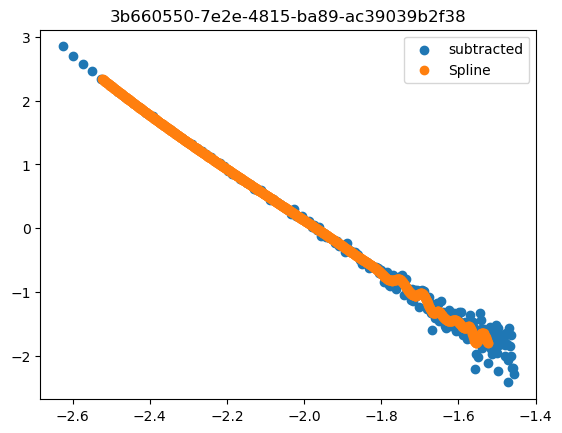

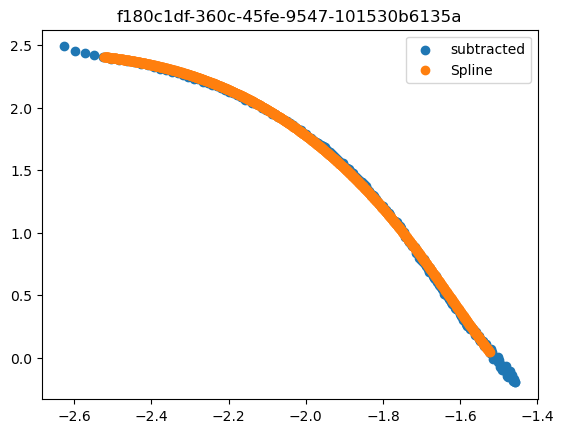

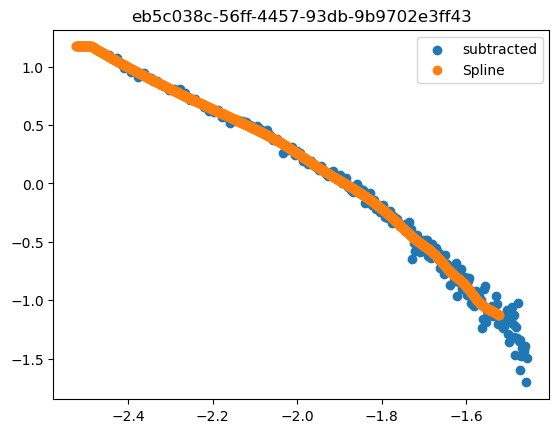

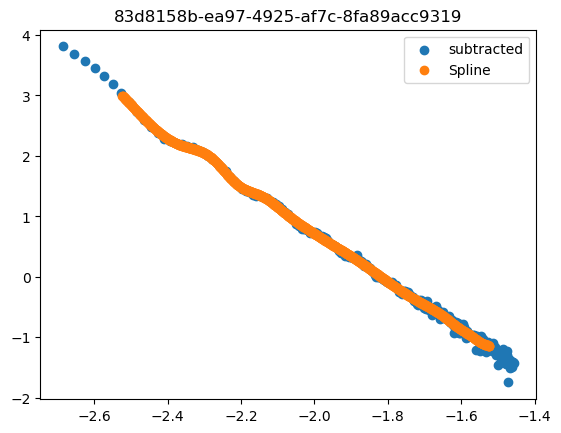

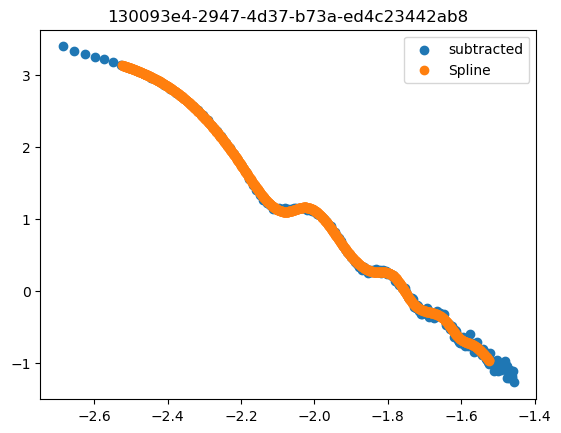

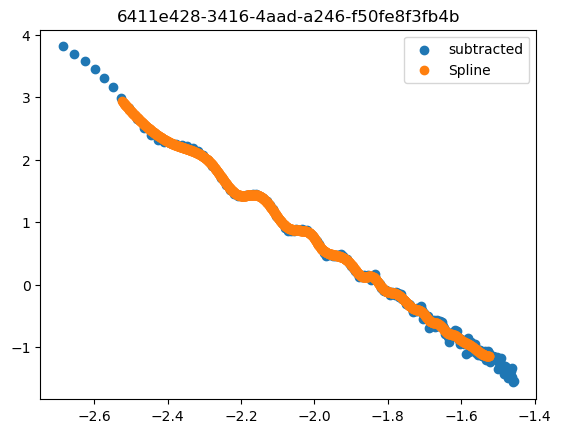

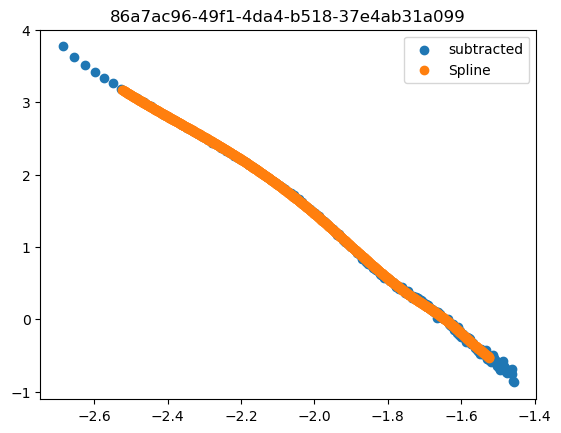

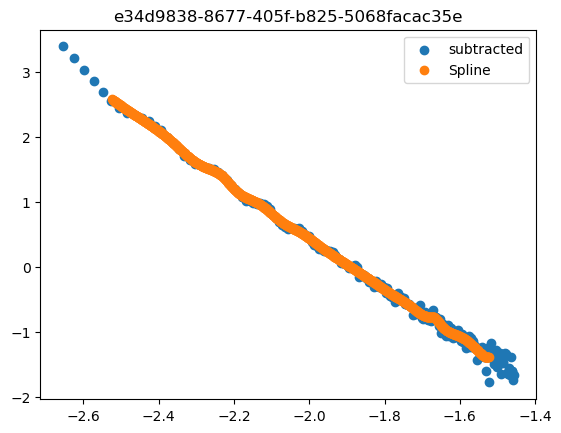

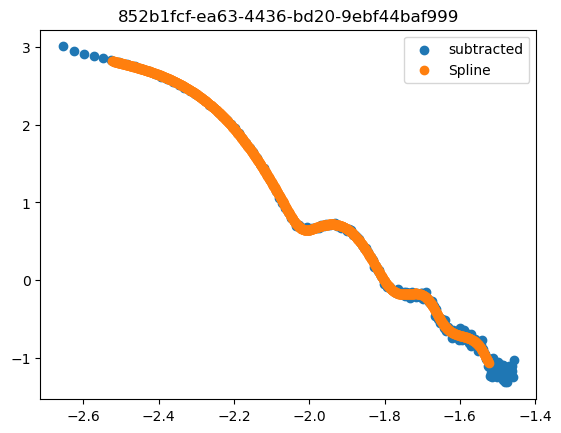

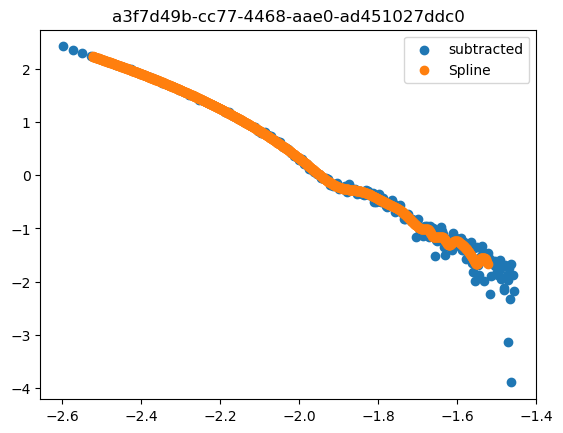

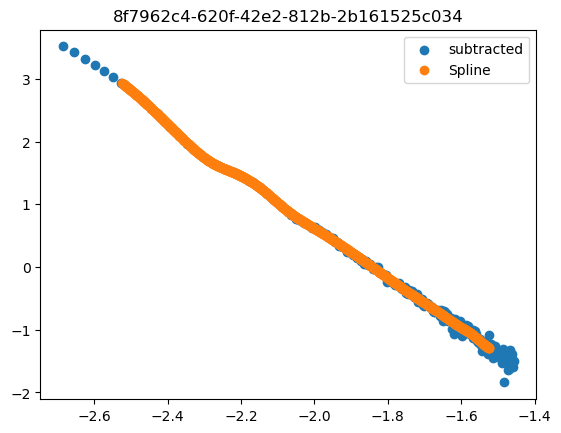

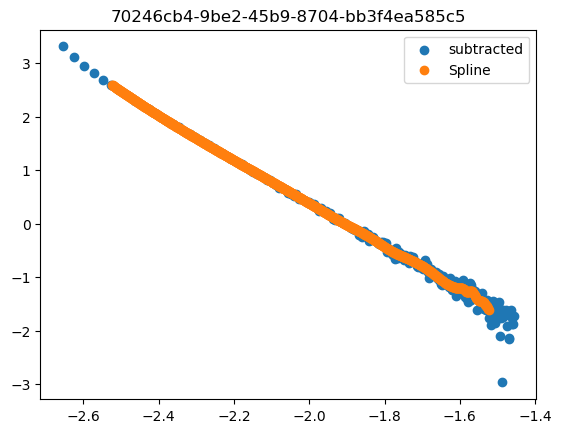

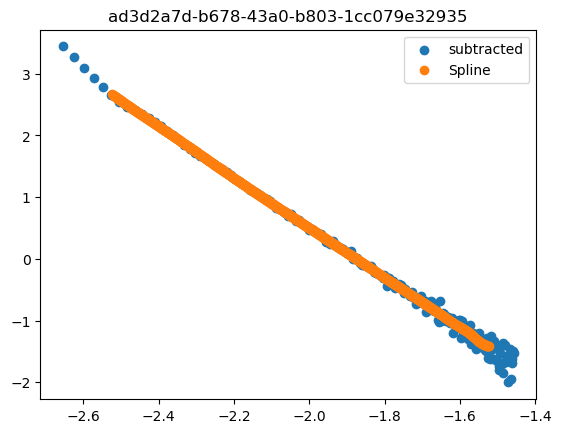

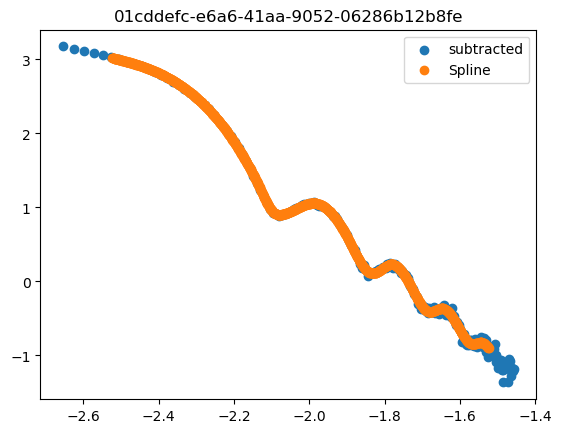

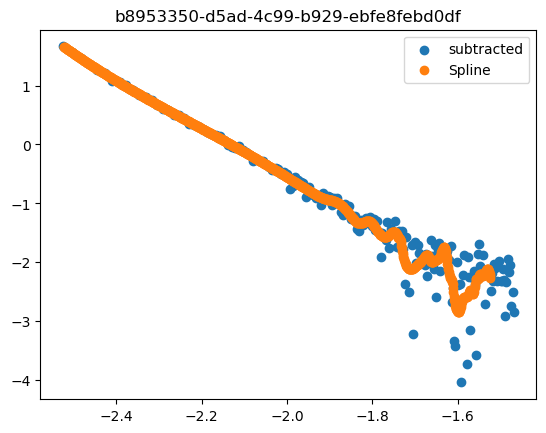

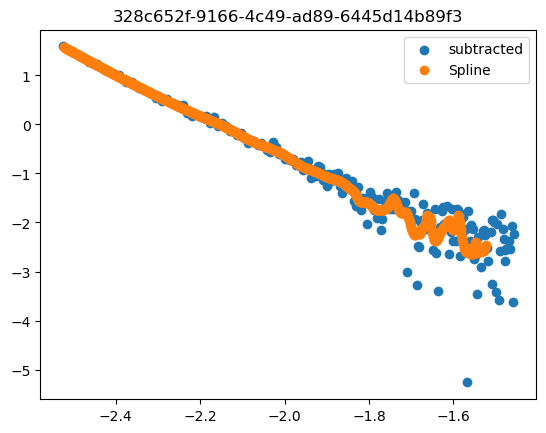

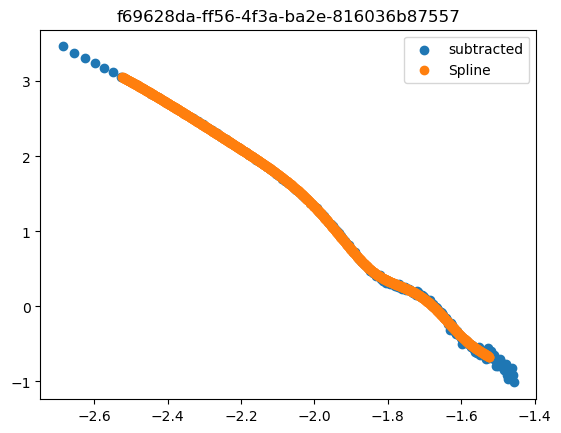

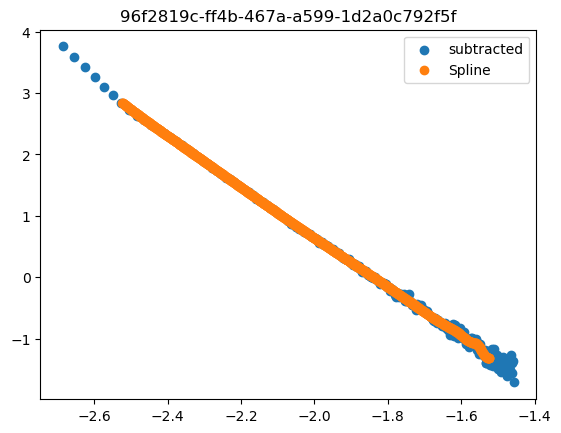

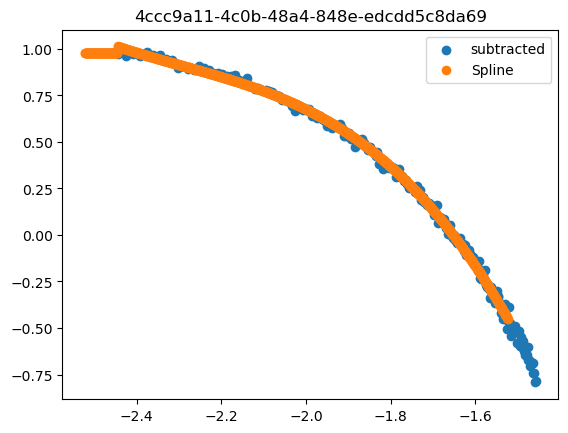

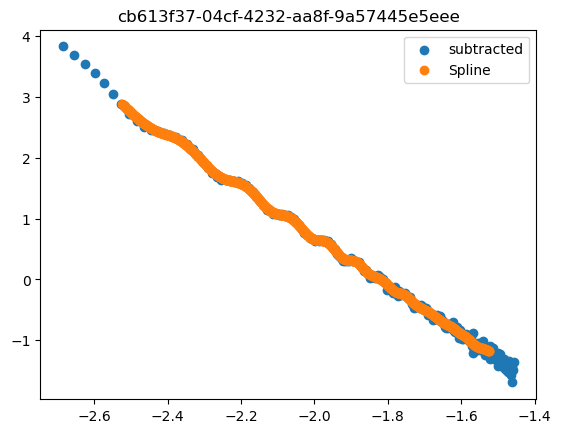

In [15]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']

        I_spline = entry['I_spline']
        
    
        ax.scatter(q, I_subtracted, label = 'subtracted')
        ax.scatter(q_grid, I_spline, label = 'Spline')
        ax.legend()
        ax.set_title(uuid_val)

## Sanity check scaling

/tmp/ipykernel_258264/1900914898.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


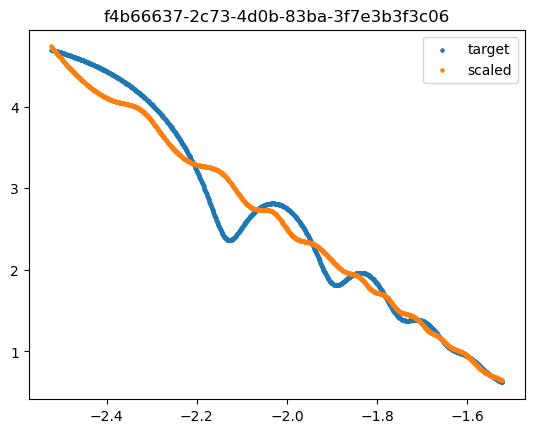

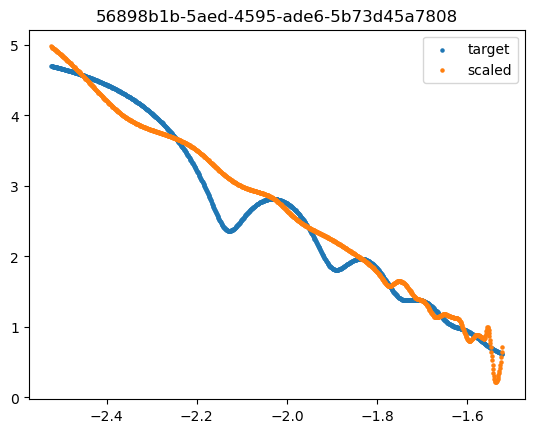

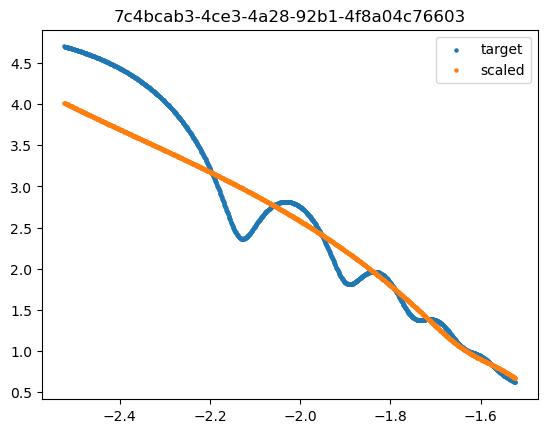

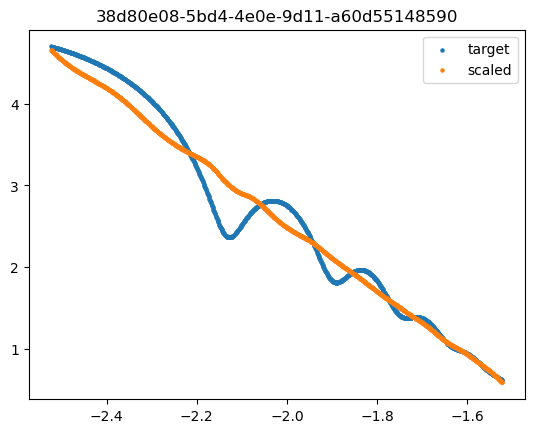

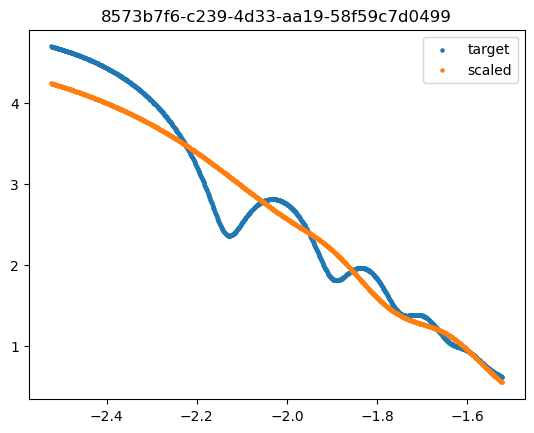

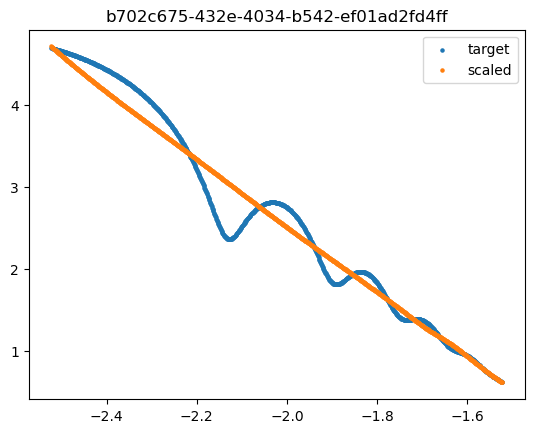

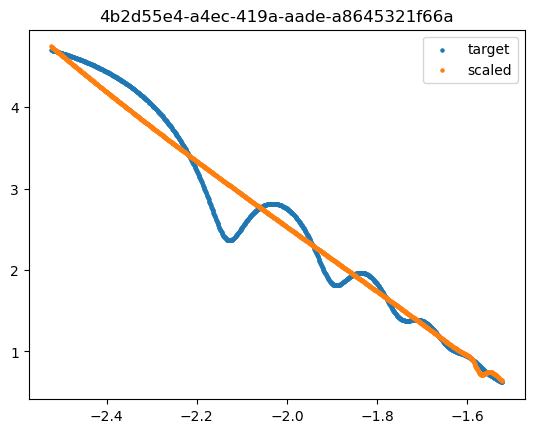

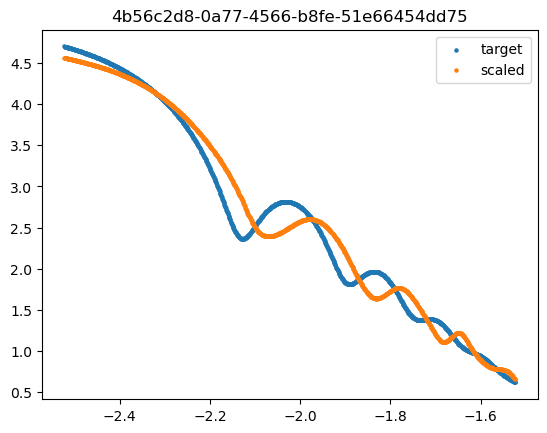

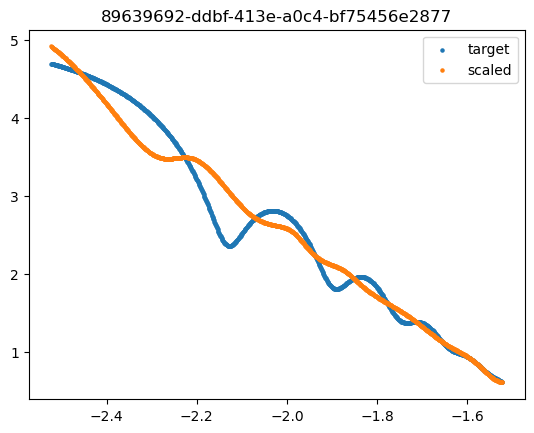

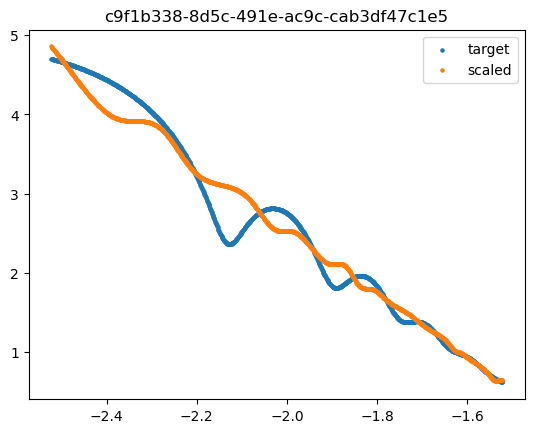

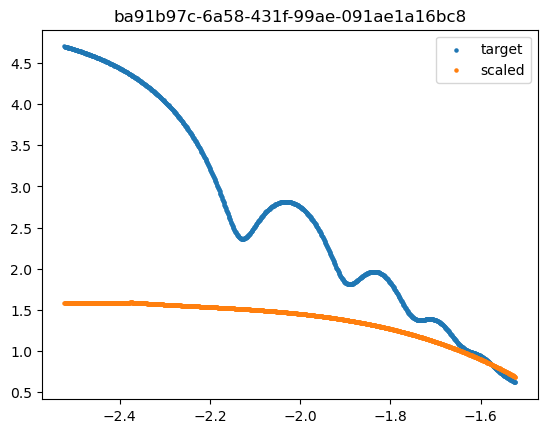

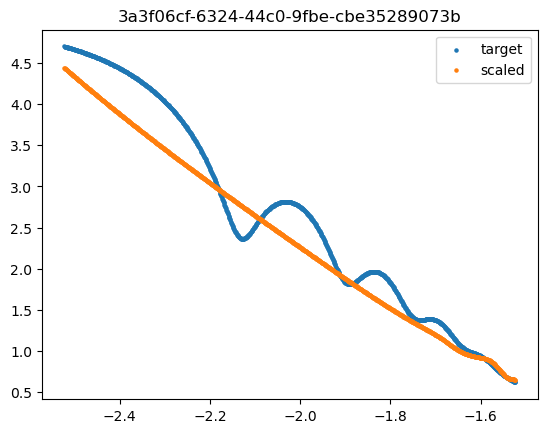

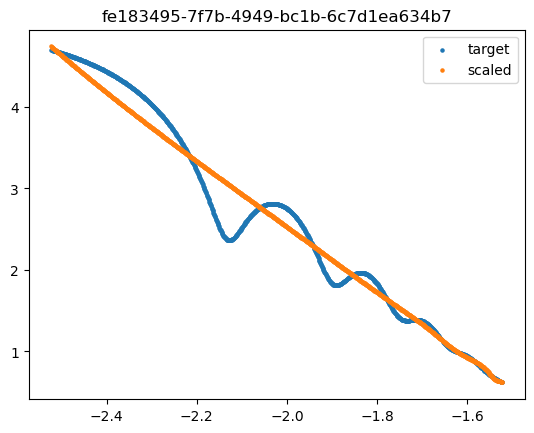

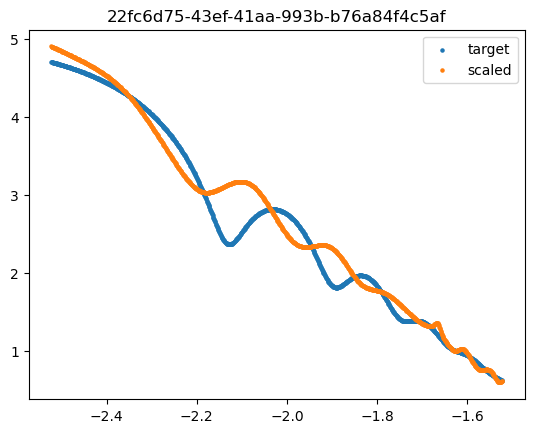

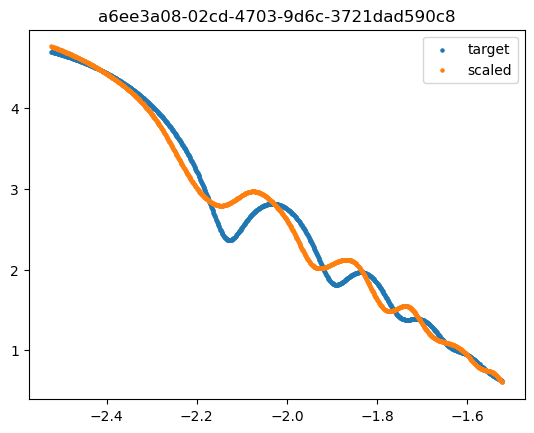

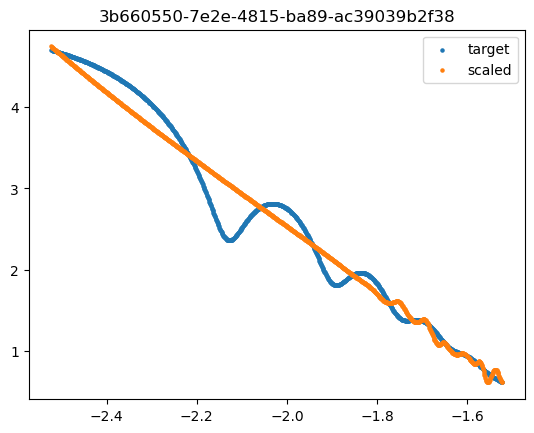

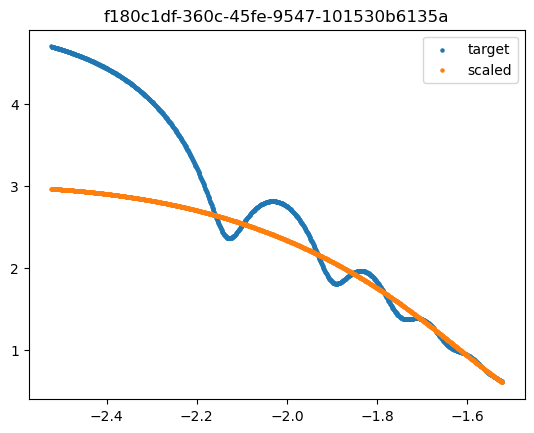

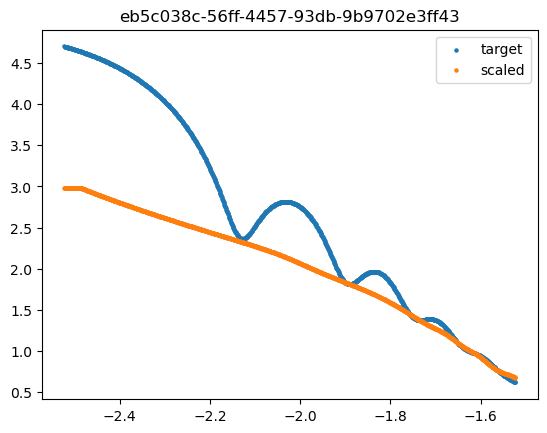

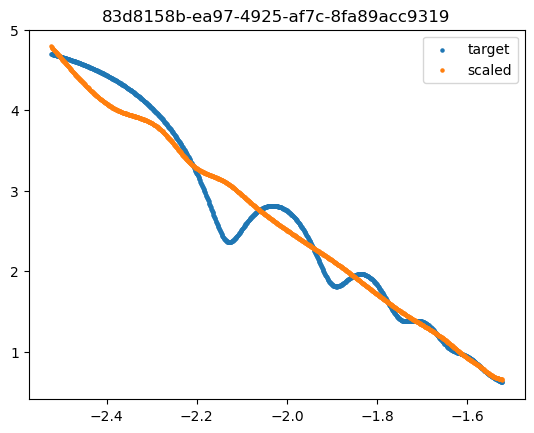

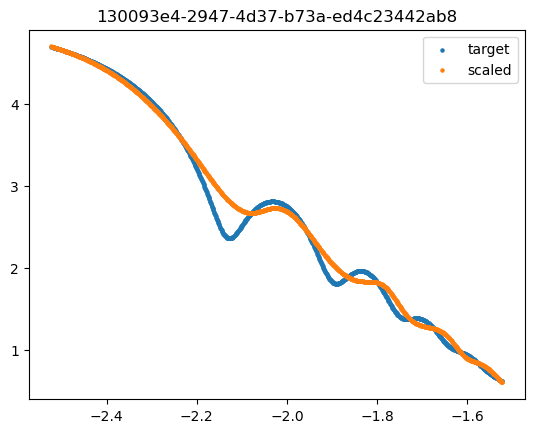

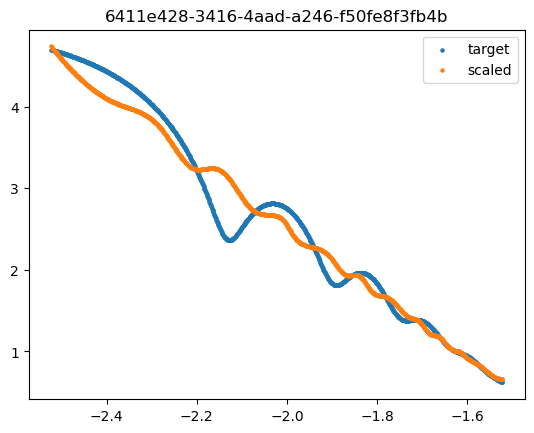

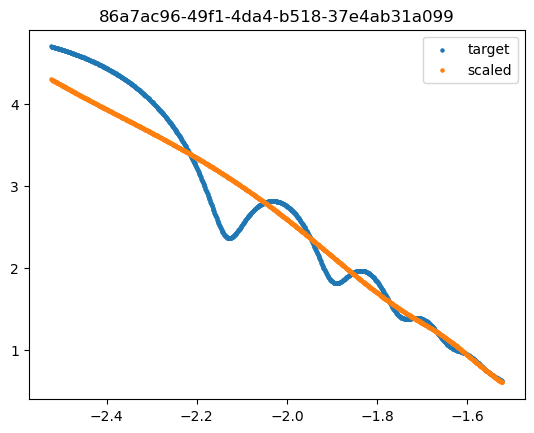

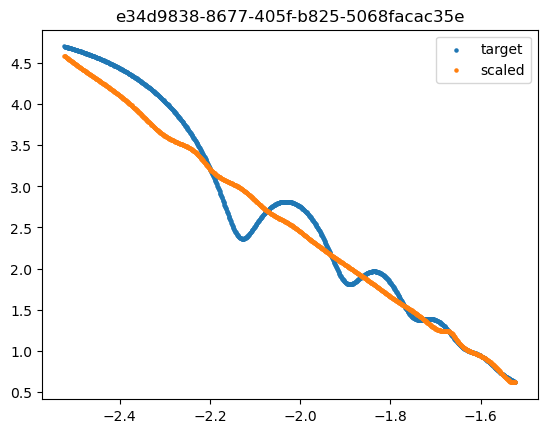

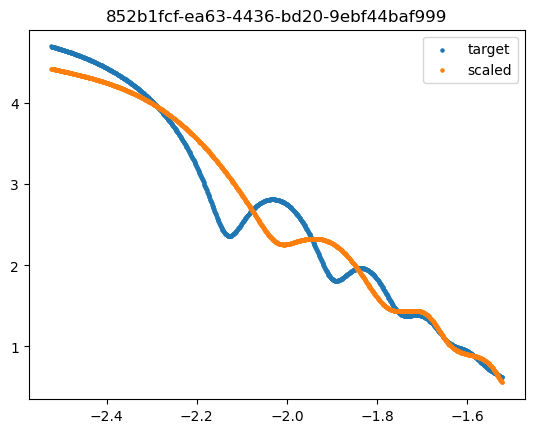

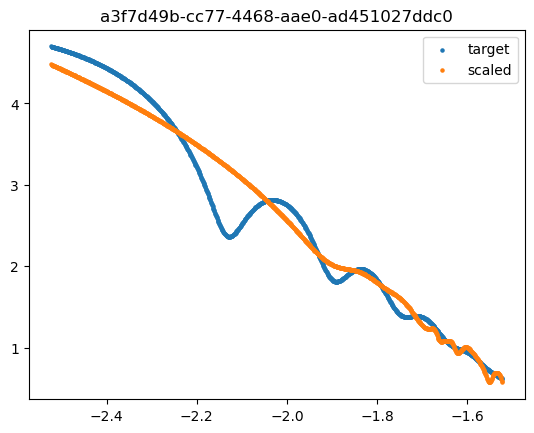

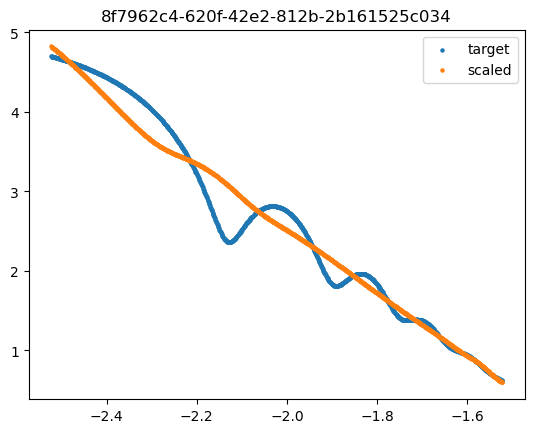

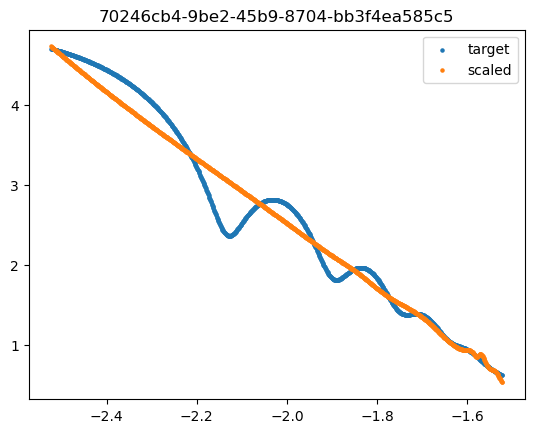

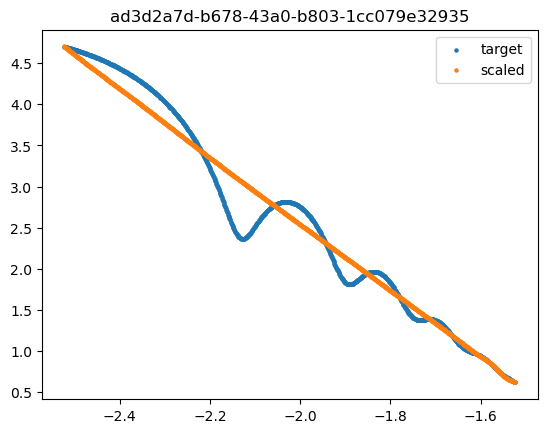

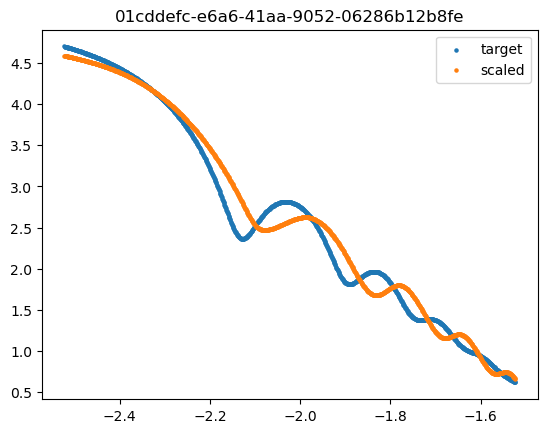

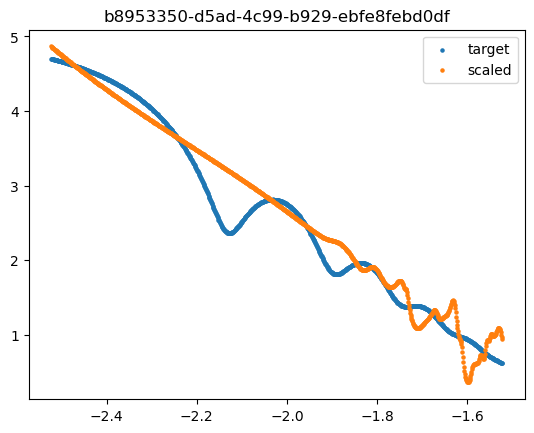

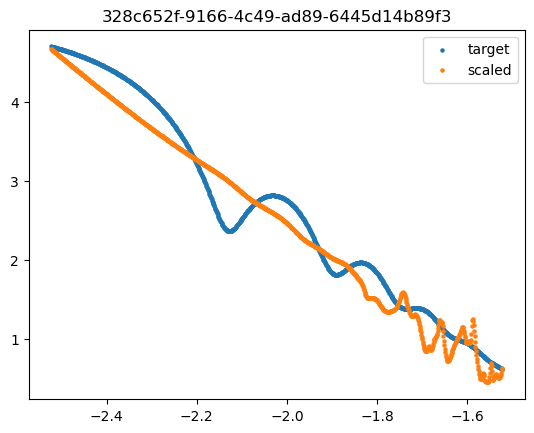

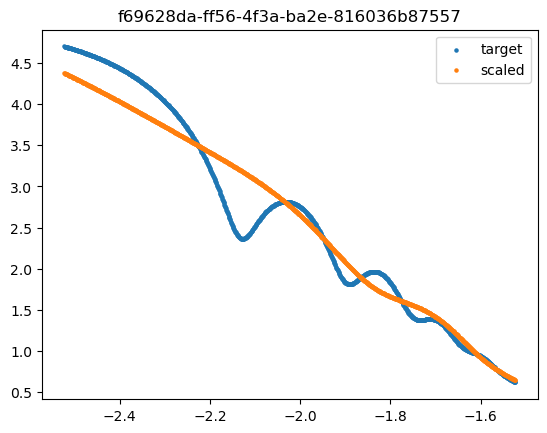

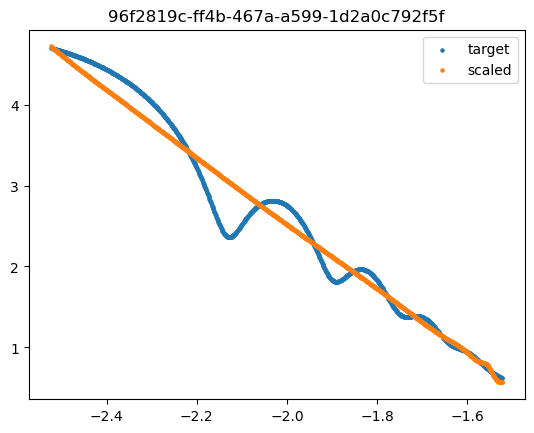

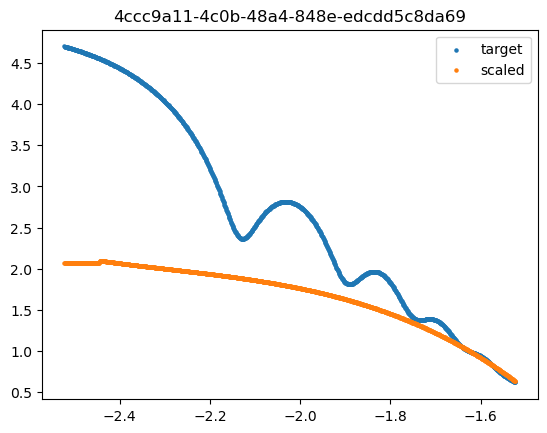

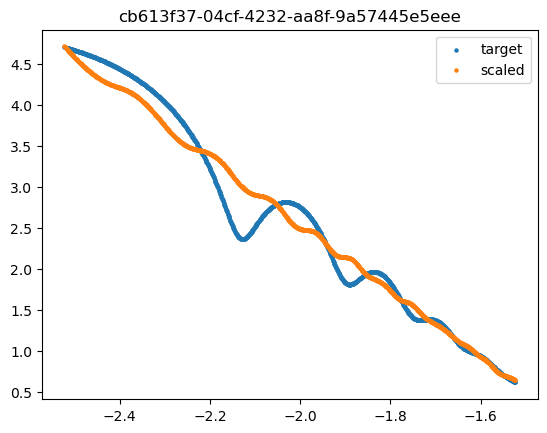

In [16]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()


        I_scaled = entry['I_scaled']
        
    
        ax.scatter(q_grid, target_I, label = 'target', s = 5)
        ax.scatter(q_grid, I_scaled, label = 'scaled', s = 5)
        ax.legend()
        ax.set_title(uuid_val)

## Fit sphere model

In [31]:
for uuid_val, entry in processing_dataset.items():
    try:
        subtracted = entry['subtracted_clipped']
    except KeyError:
        continue
        
    data_sas = io.df_to_sasdata(subtracted)
    results, result_obj, problem  = sasview_fitting.fit_sphere(data_sas, polydispersity=True)

    processing_dataset[uuid_val]['sphere_fit_results'] = results
    processing_dataset[uuid_val]['sphere_fit_problem'] = problem

## sanity check fit results

/tmp/ipykernel_258264/3968789754.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


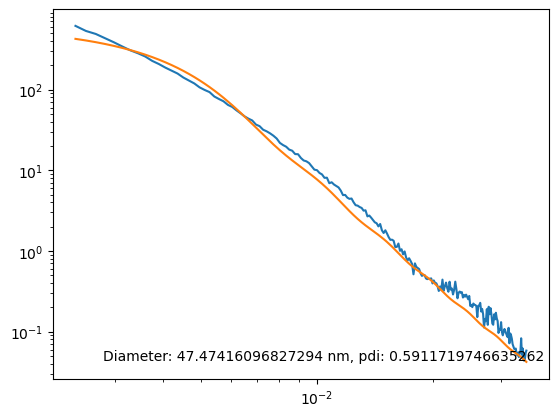

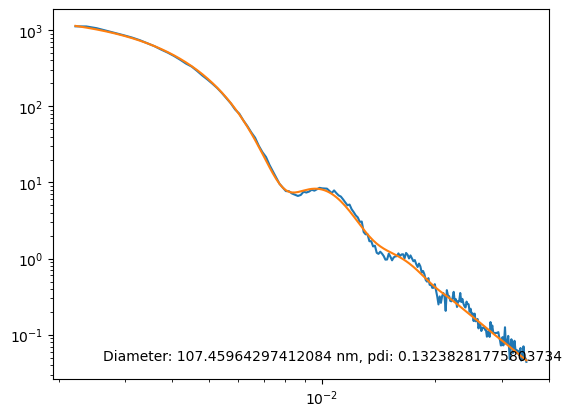

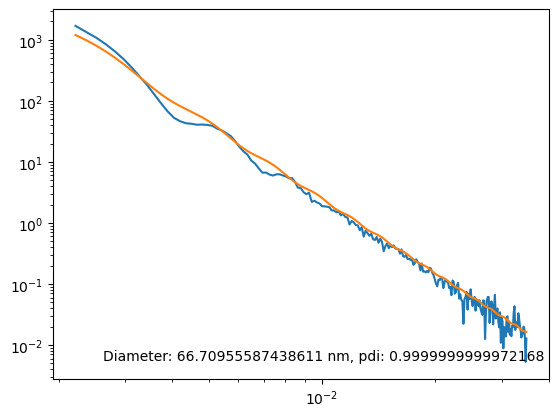

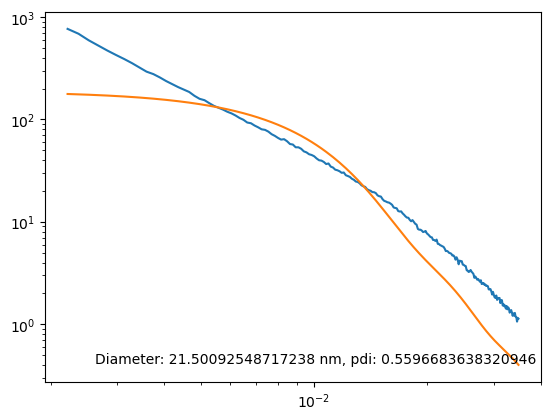

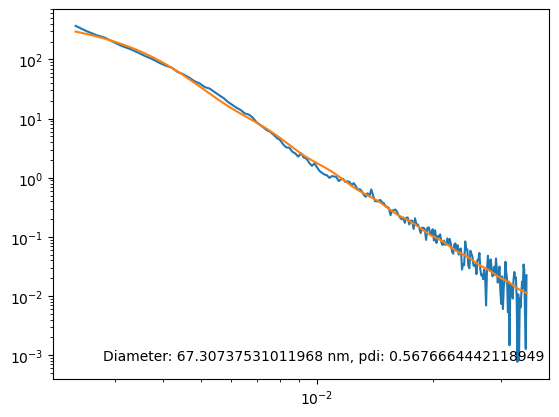

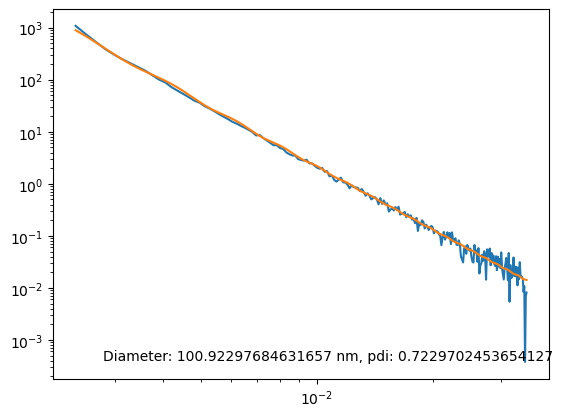

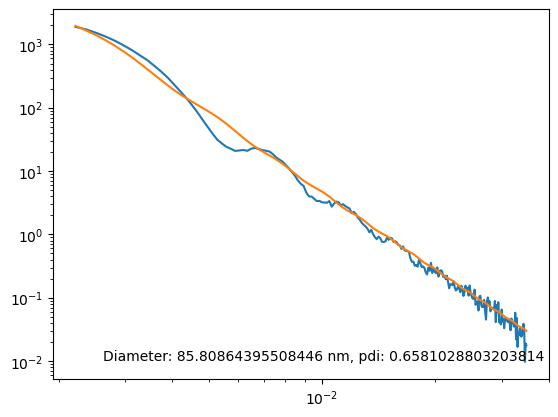

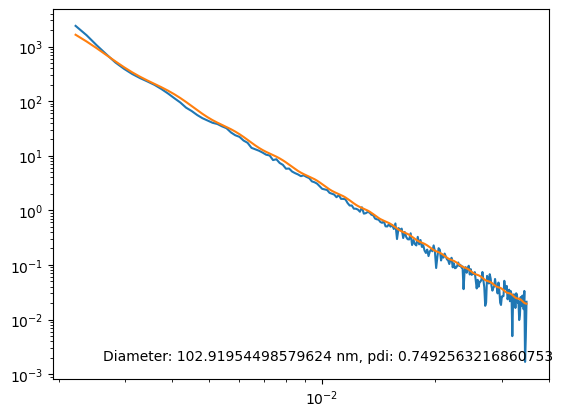

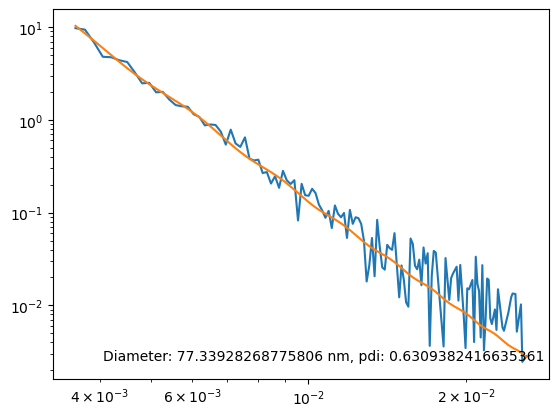

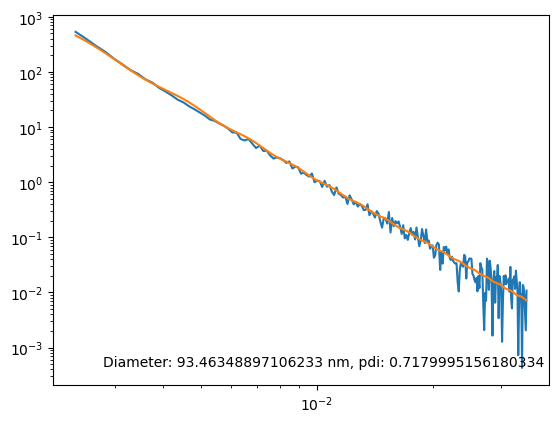

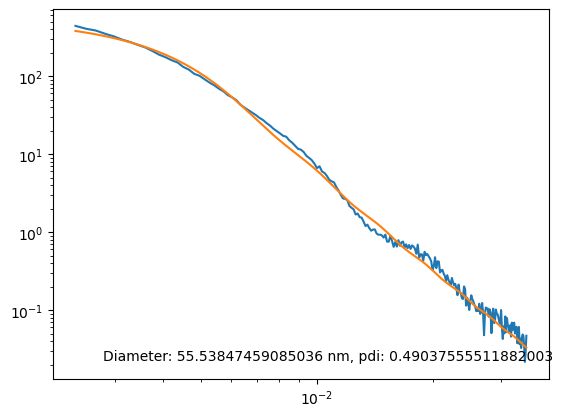

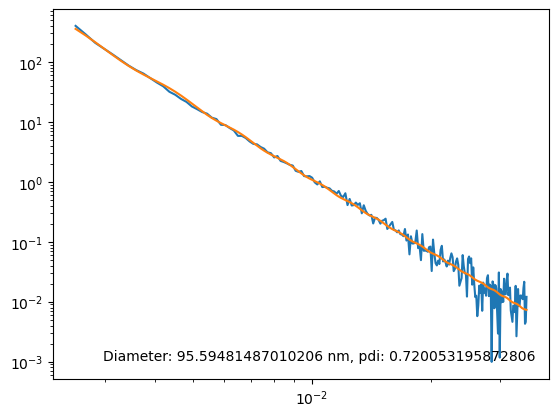

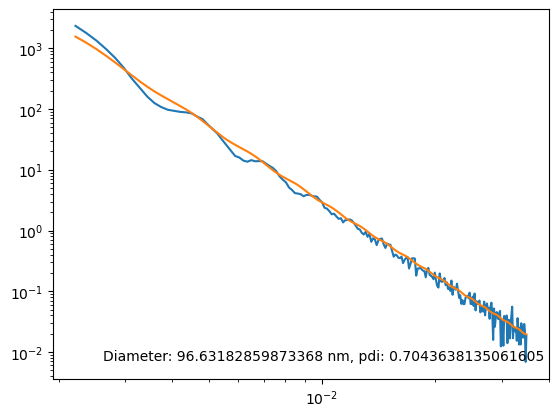

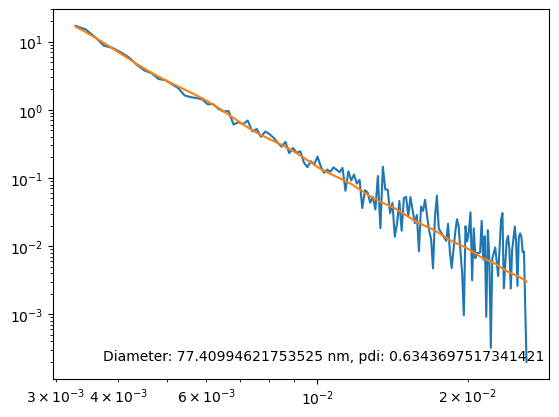

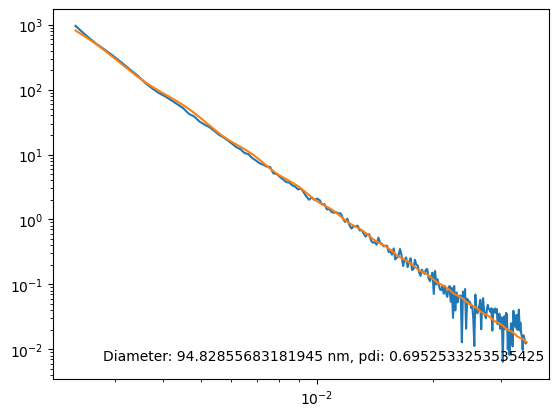

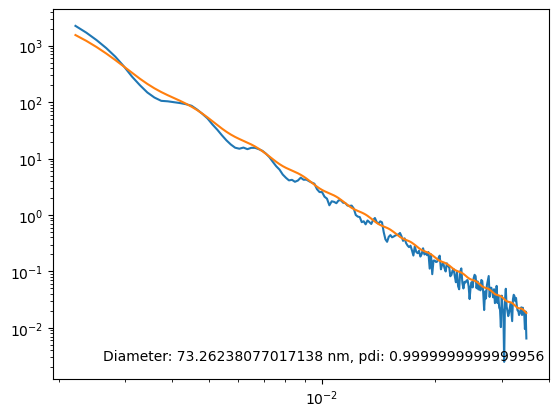

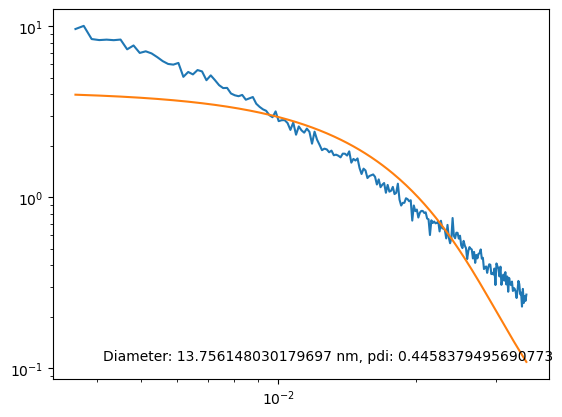

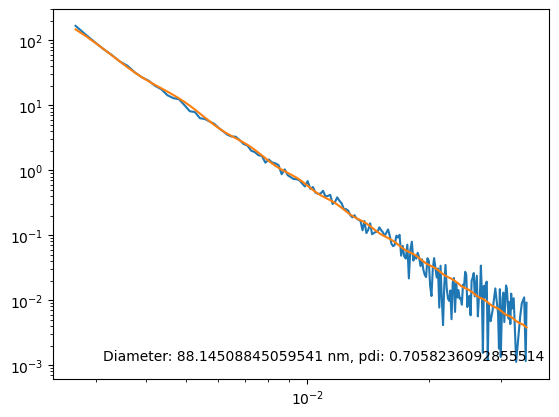

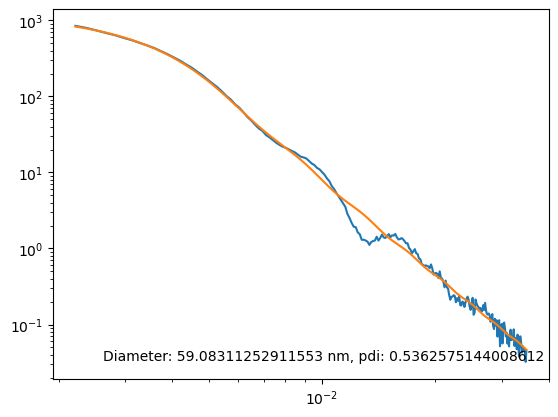

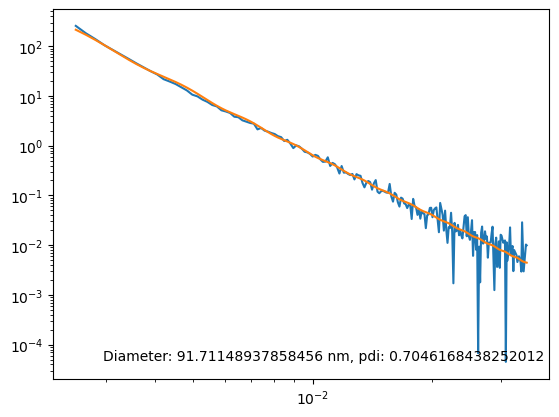

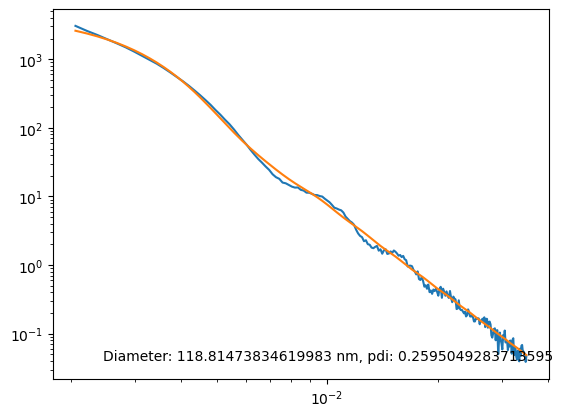

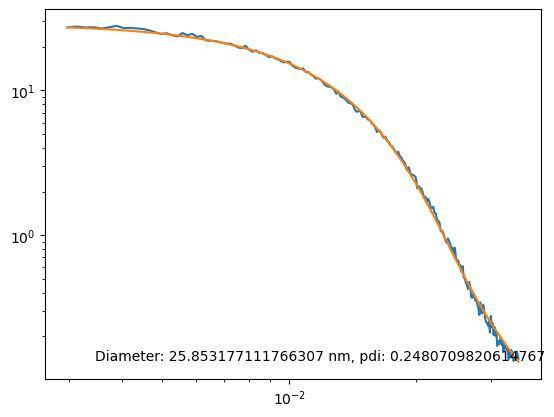

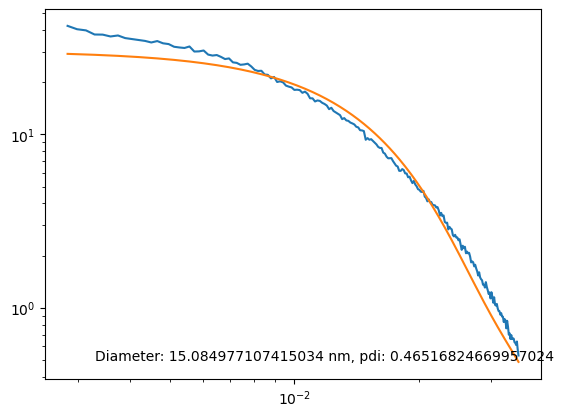

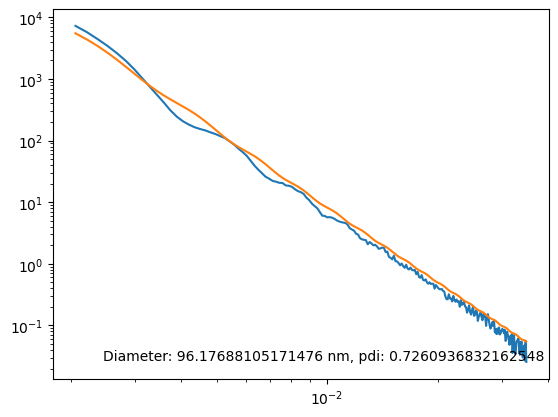

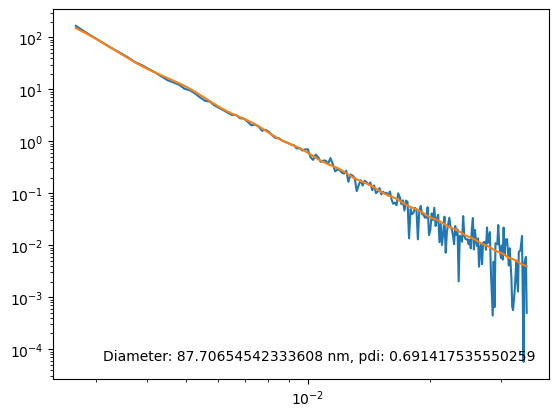

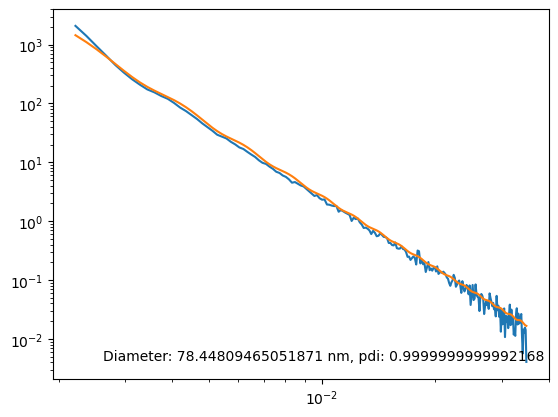

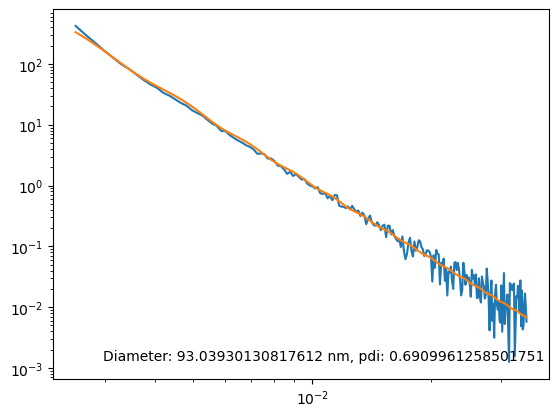

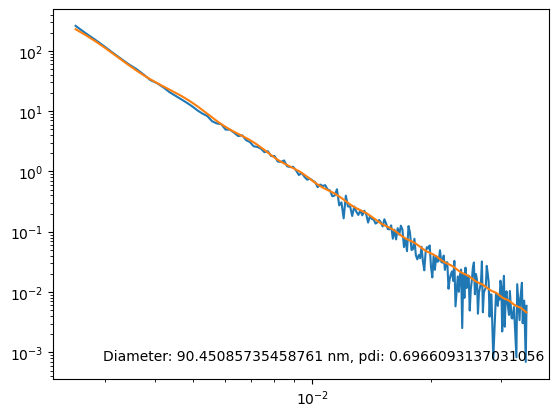

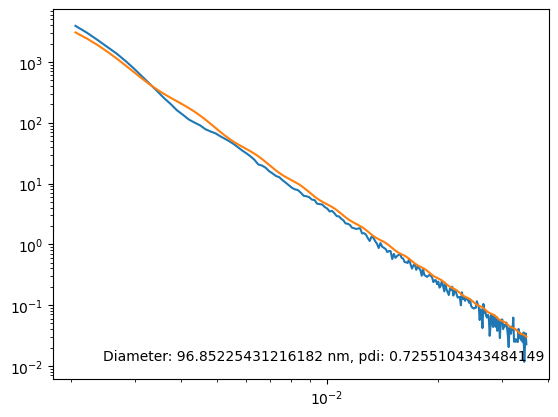

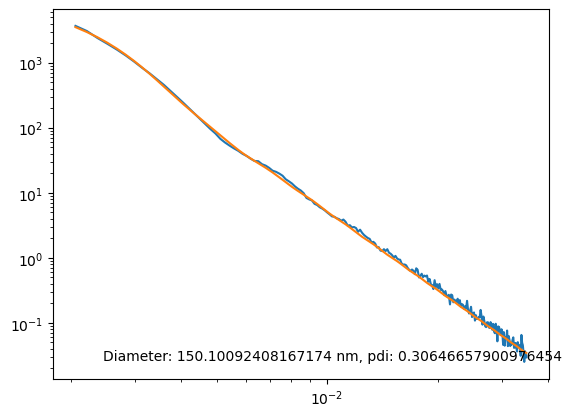

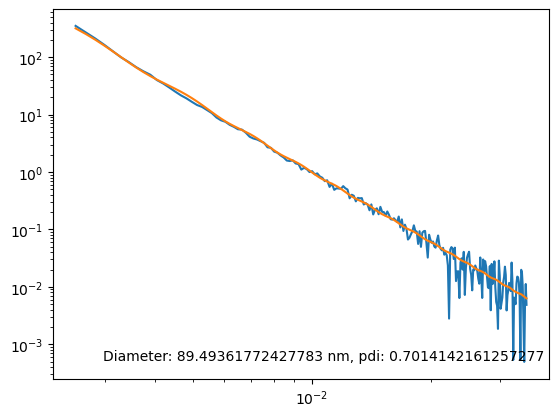

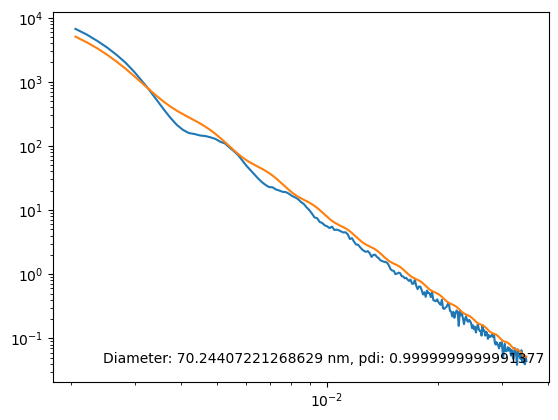

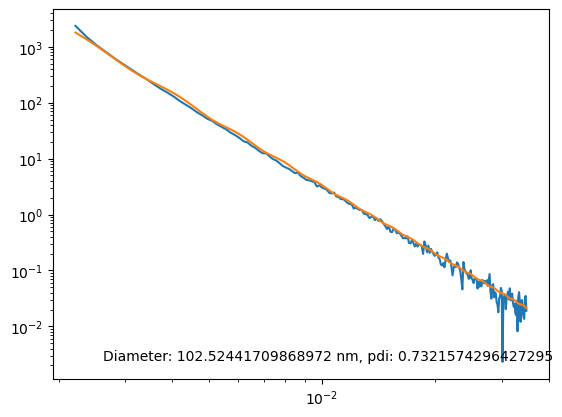

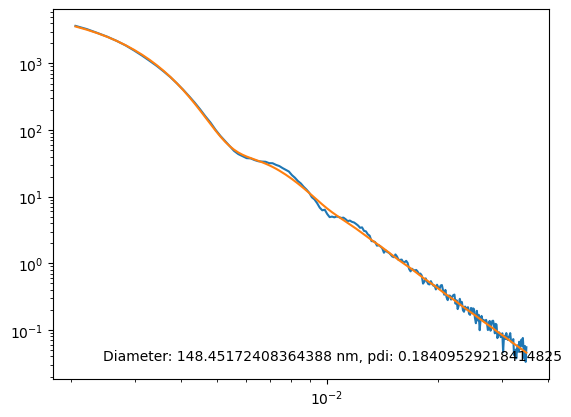

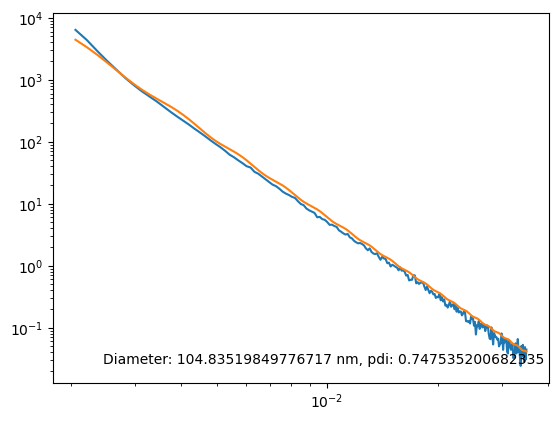

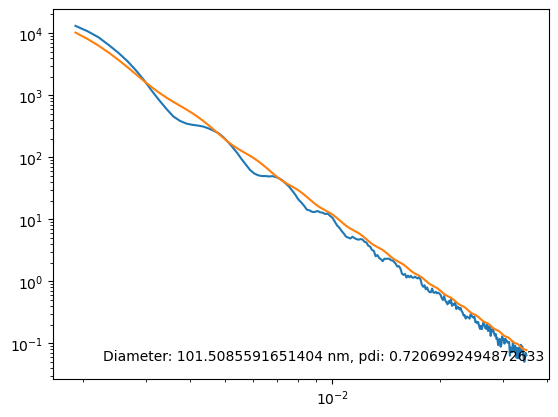

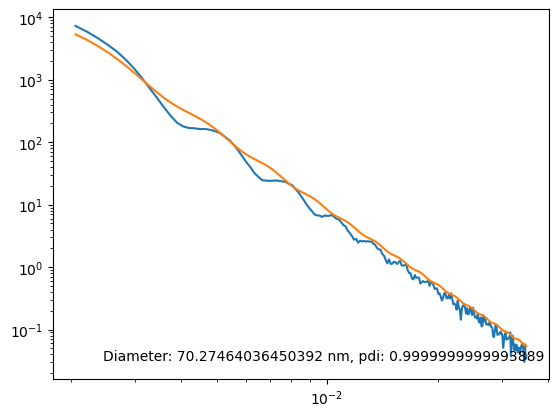

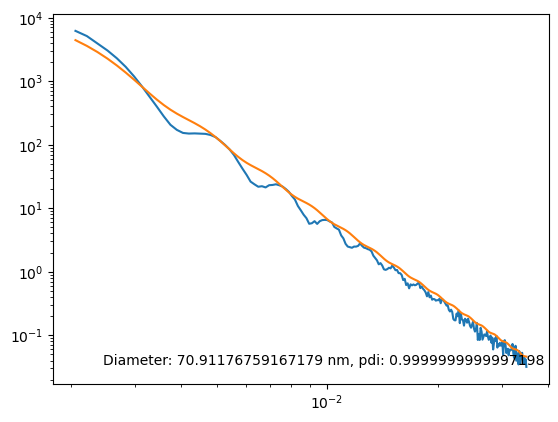

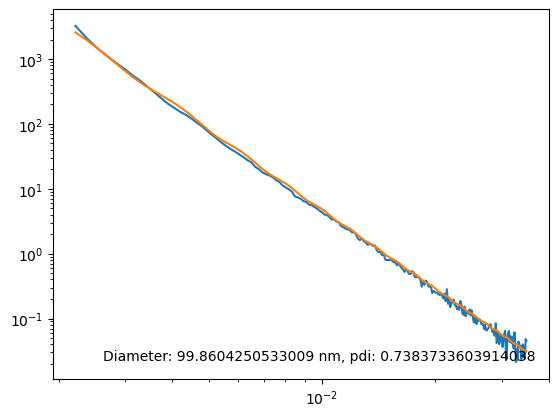

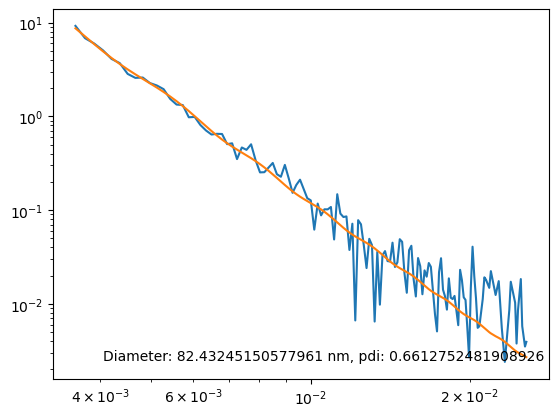

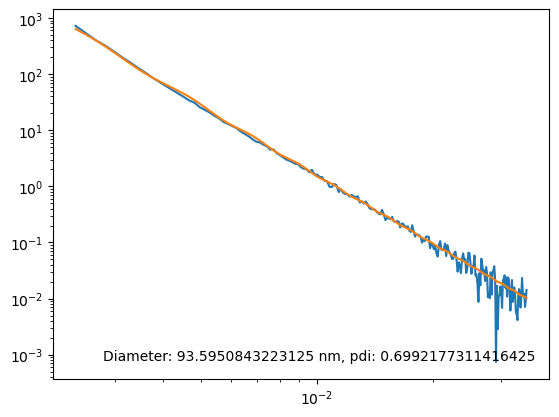

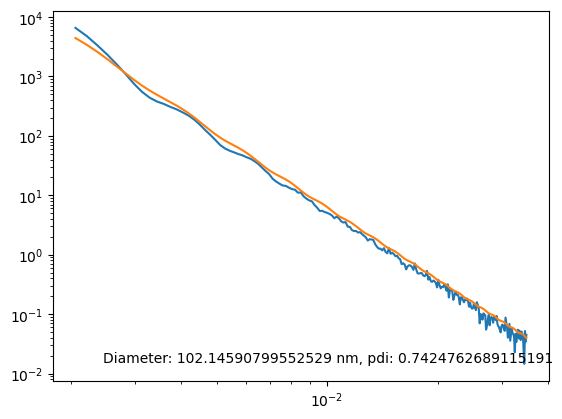

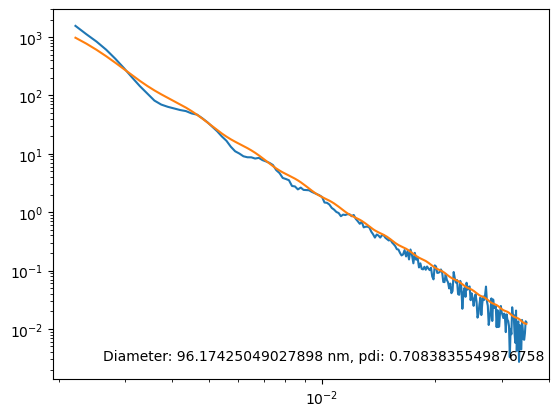

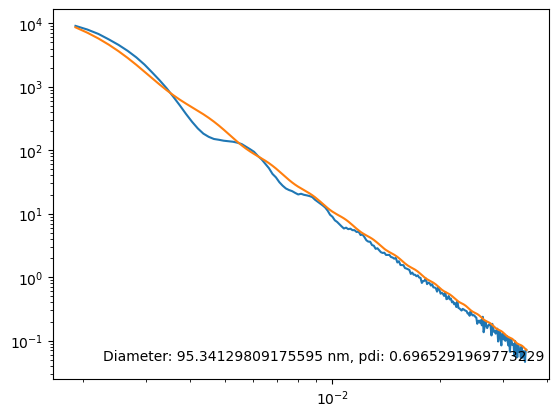

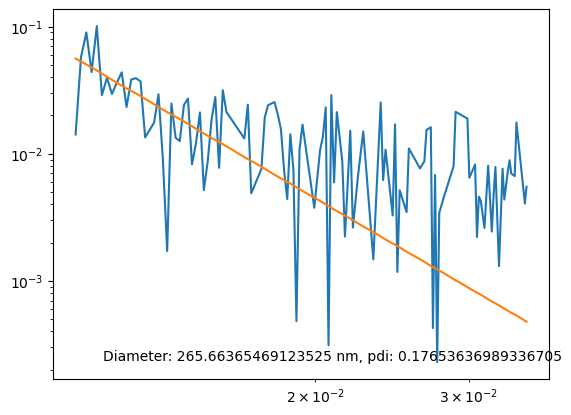

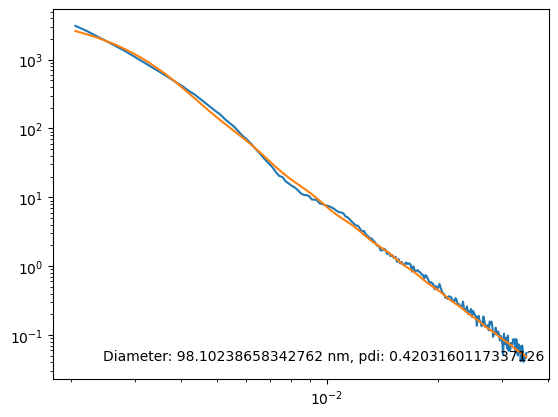

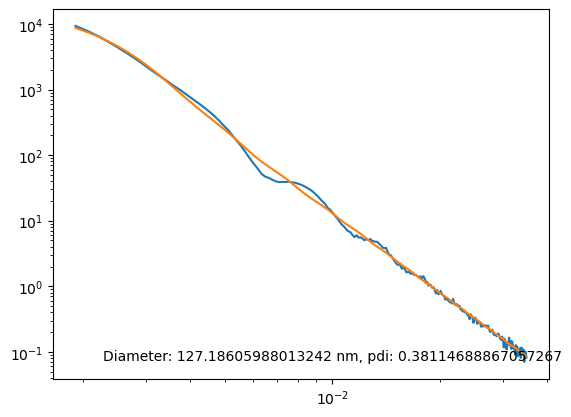

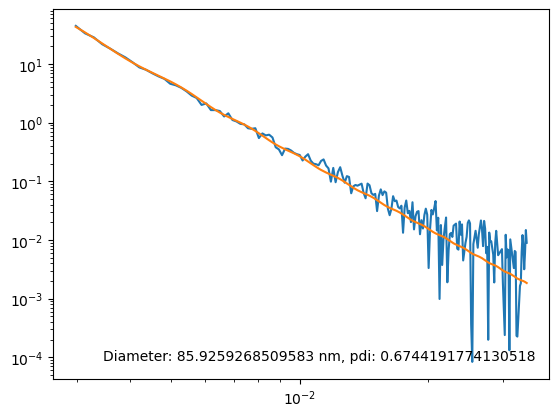

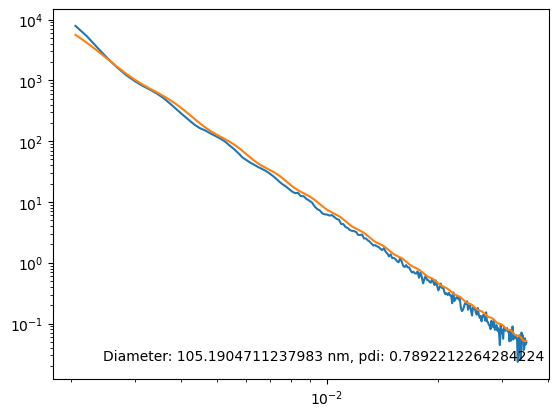

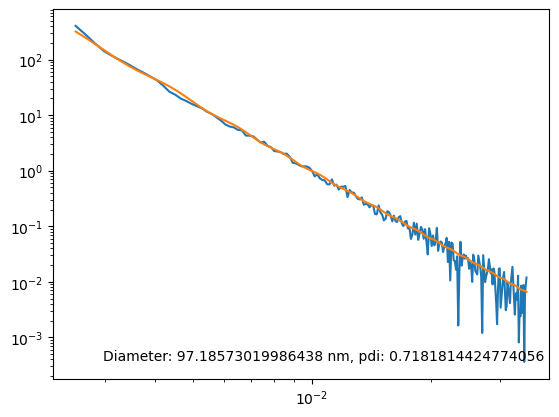

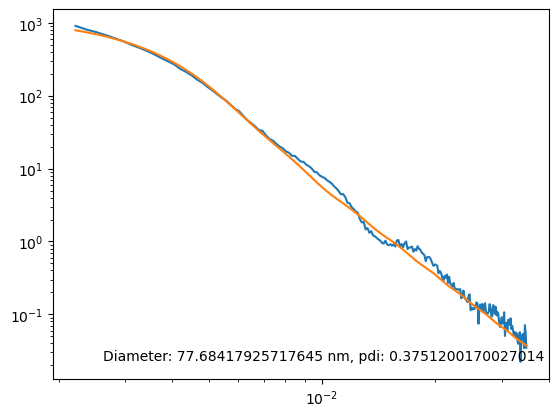

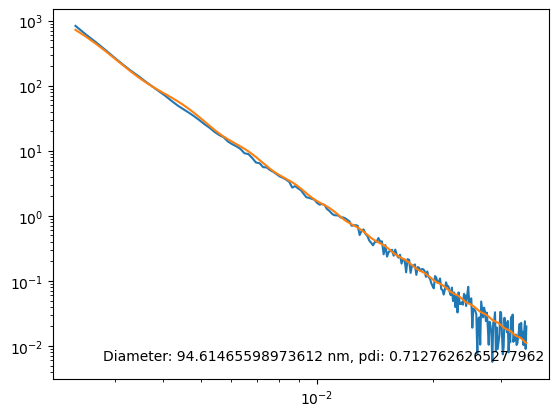

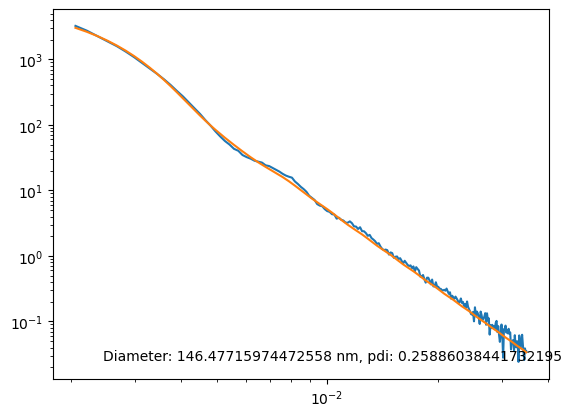

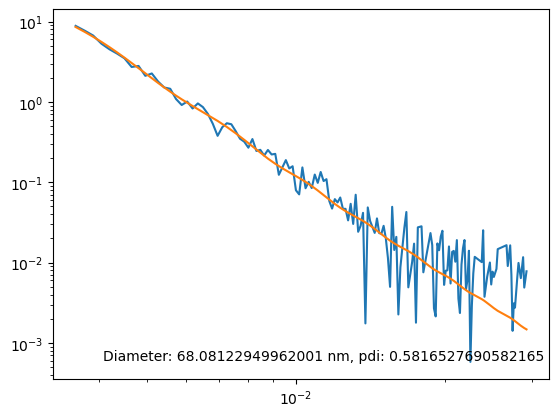

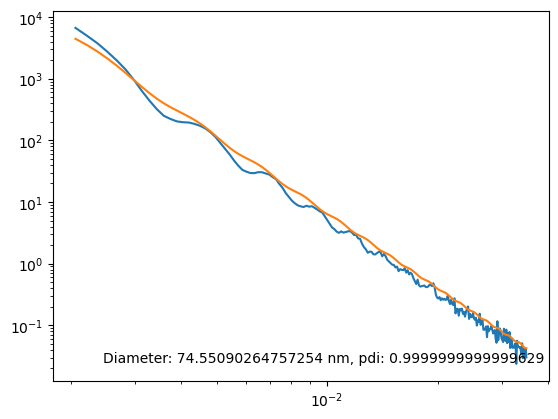

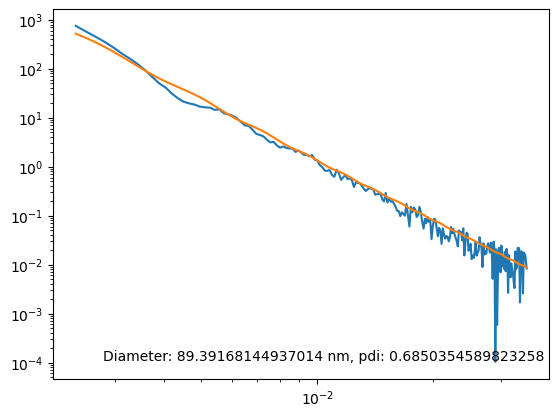

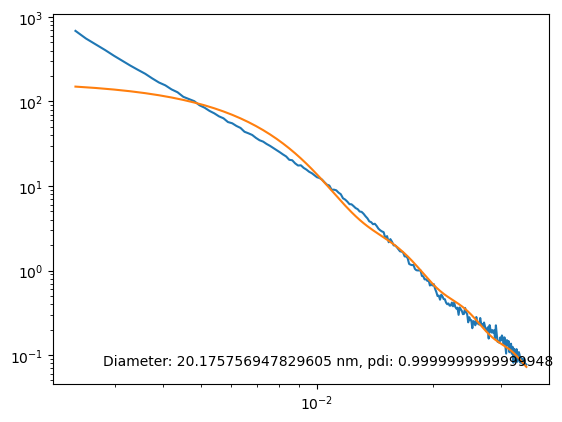

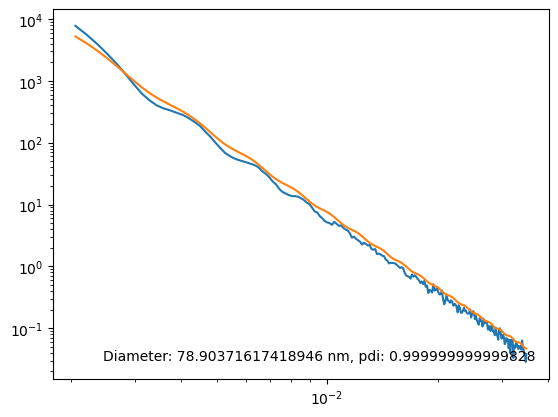

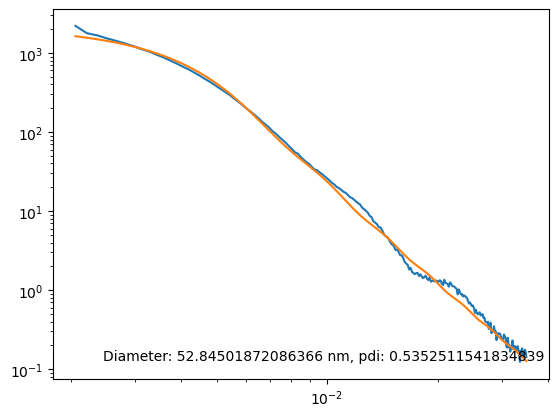

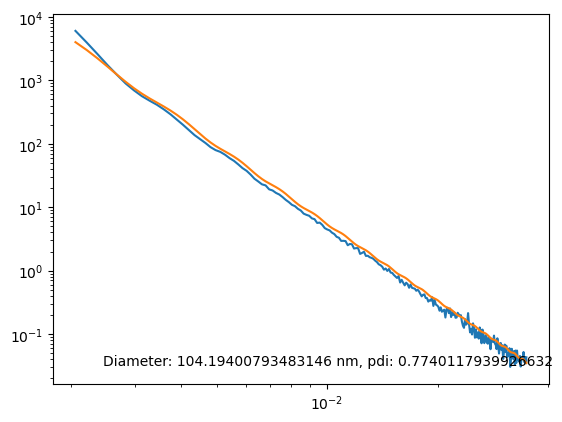

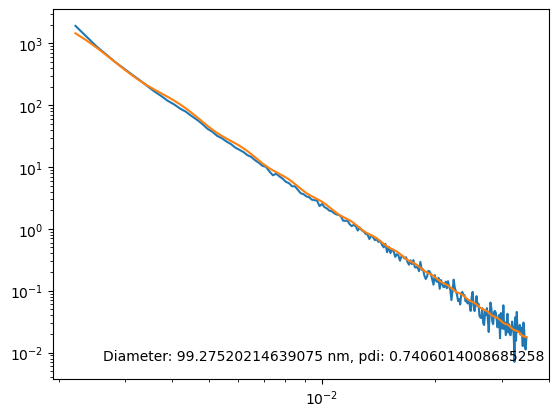

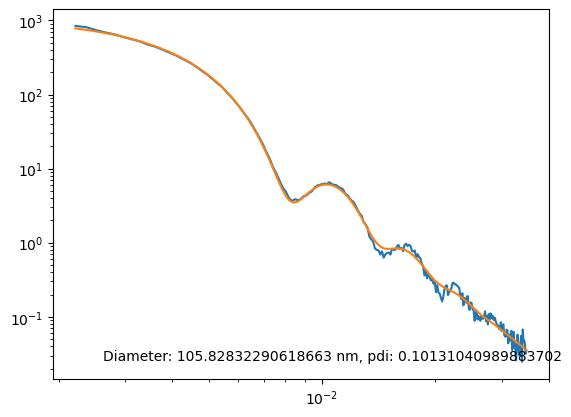

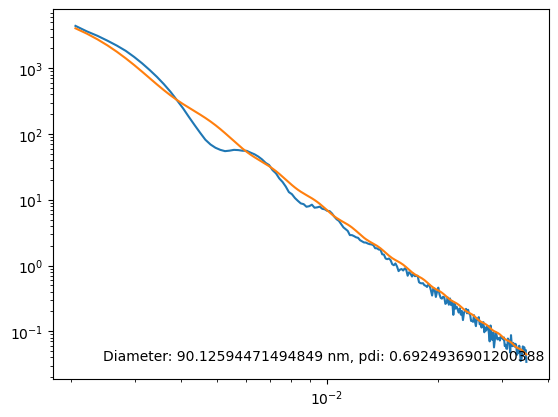

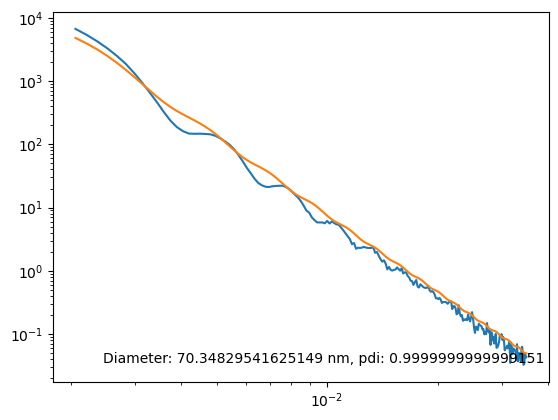

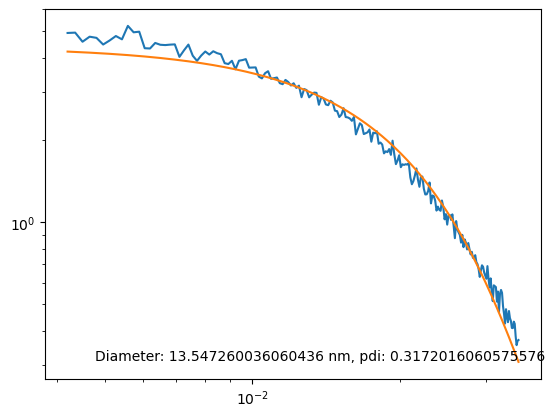

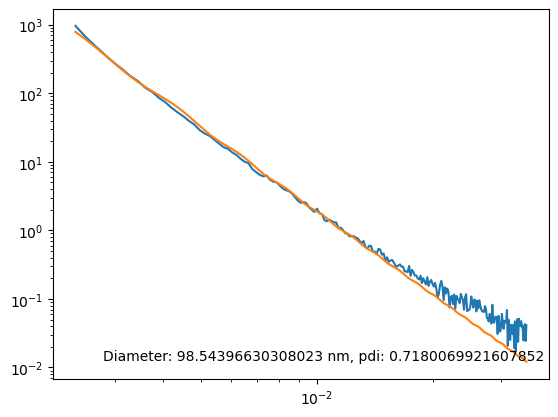

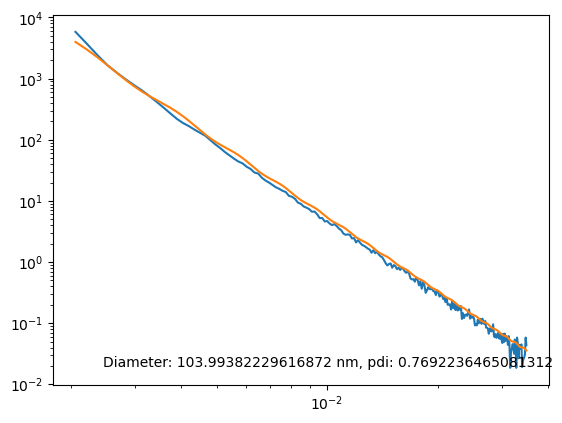

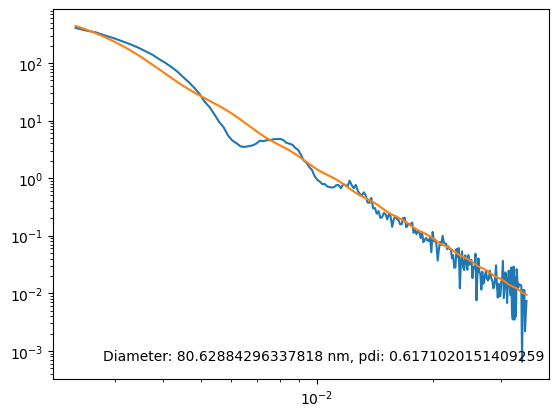

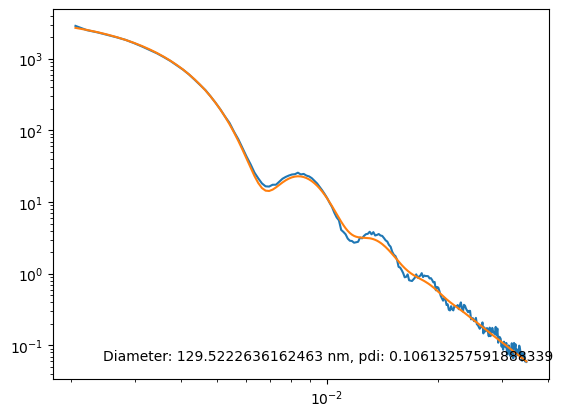

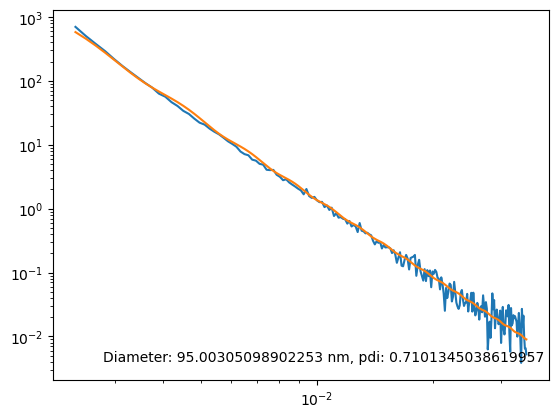

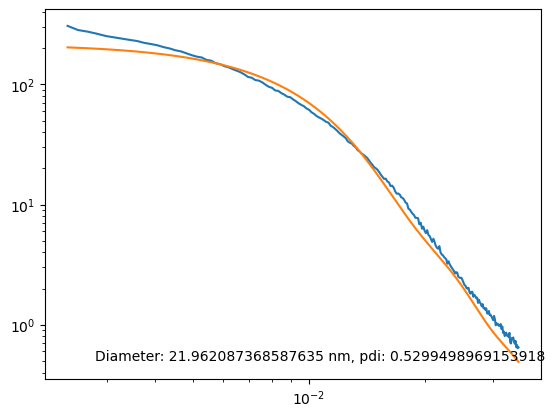

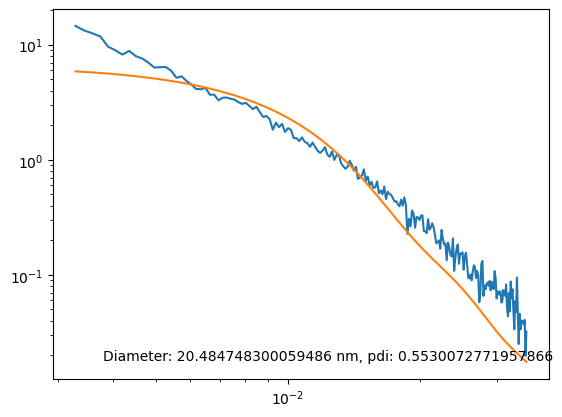

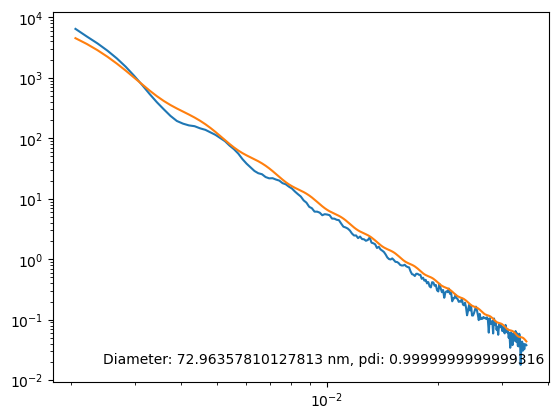

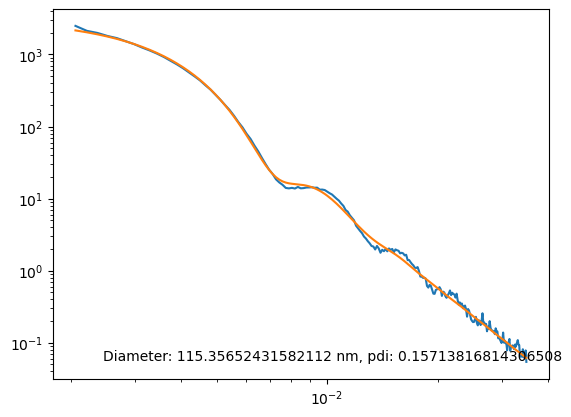

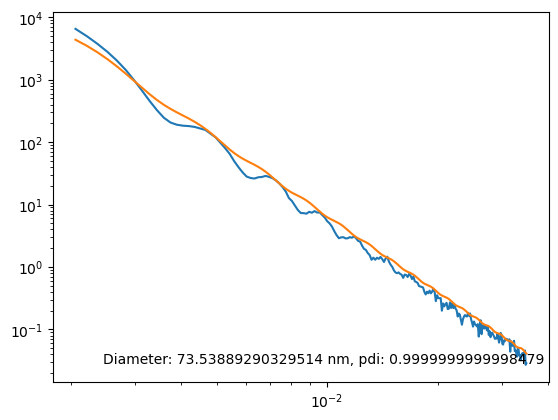

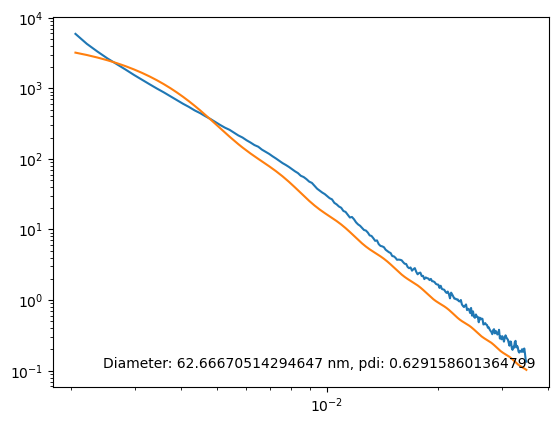

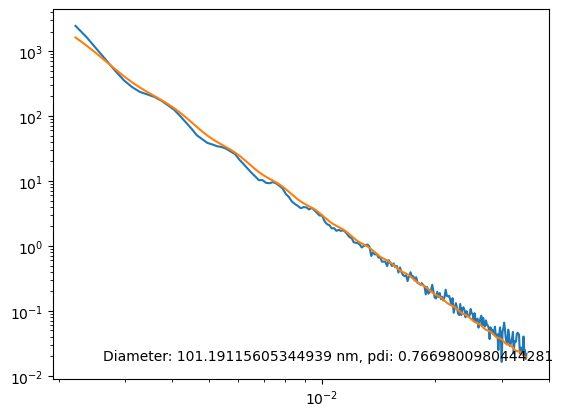

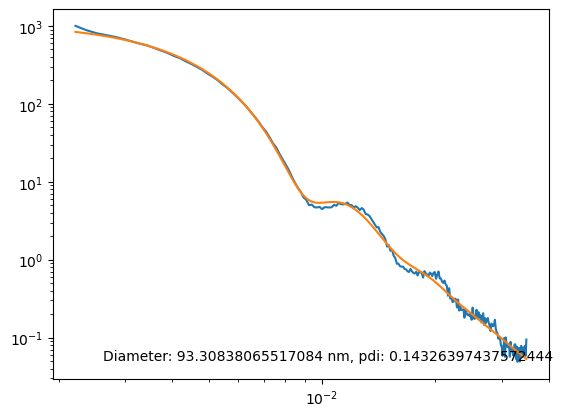

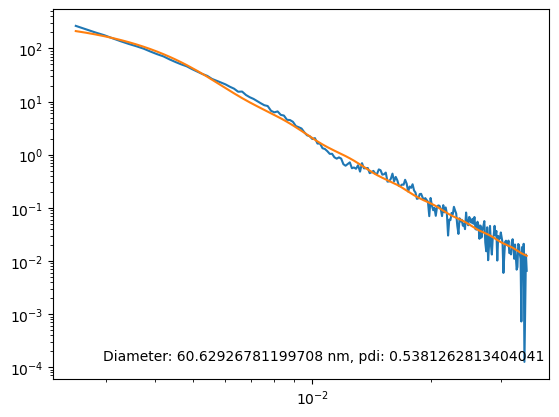

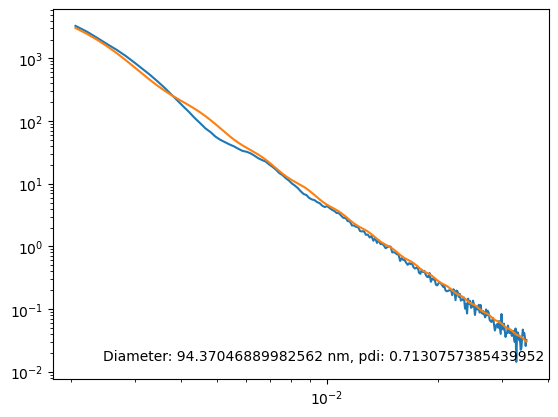

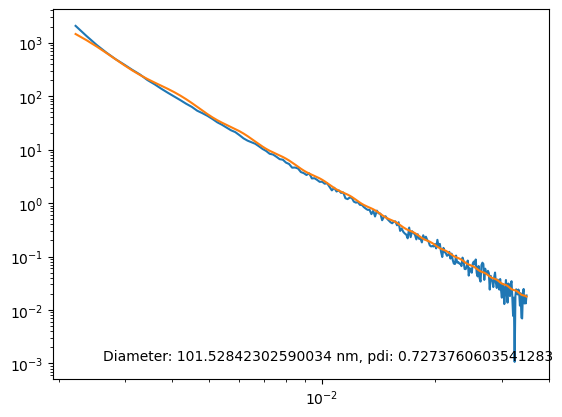

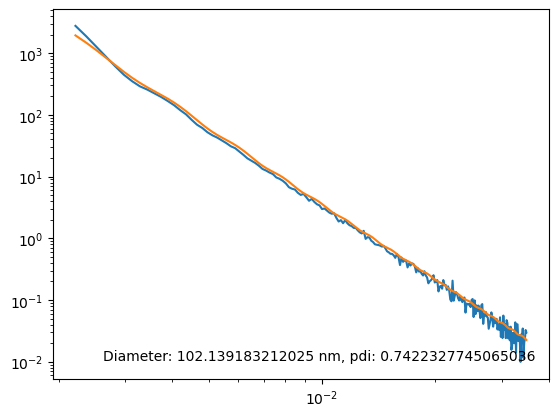

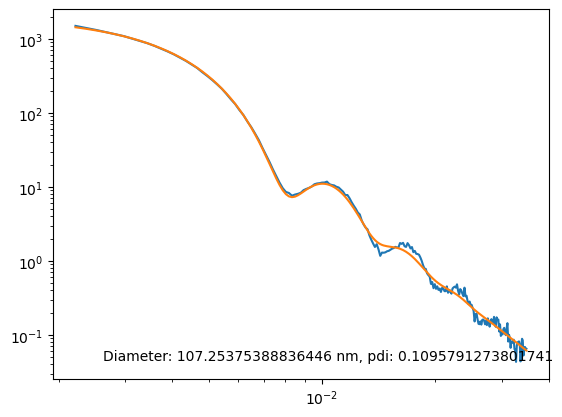

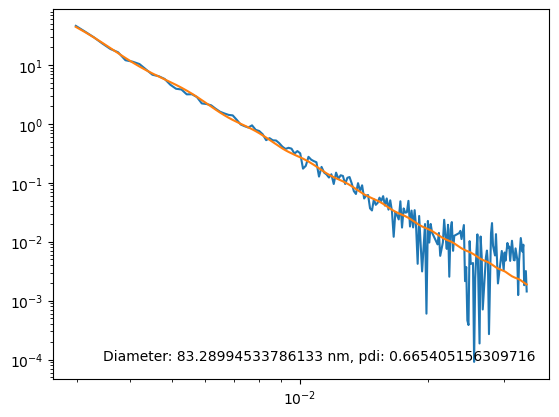

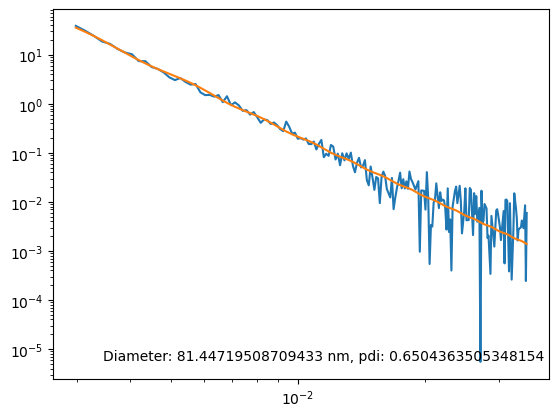

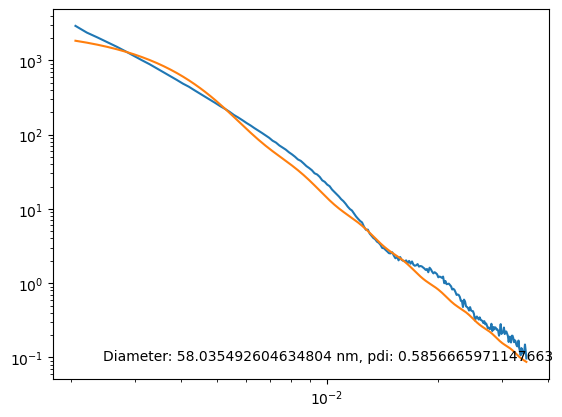

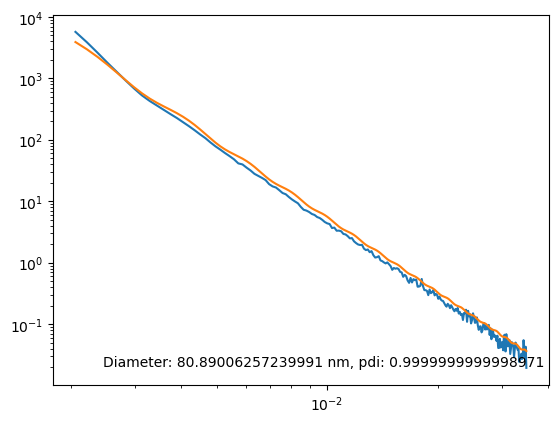

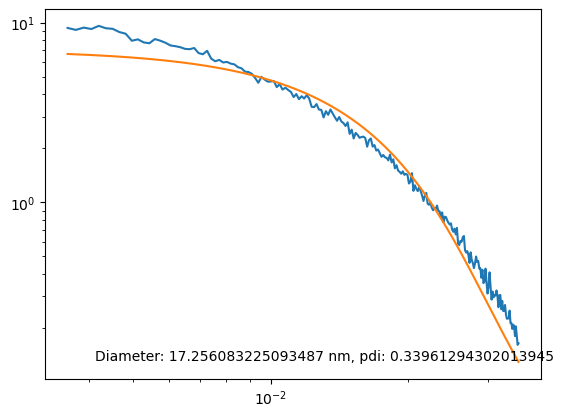

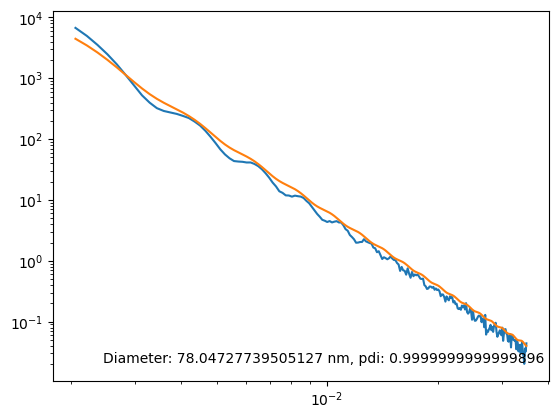

In [32]:
for uuid_val, entry in processing_dataset.items():
    try:
        sphere_d = entry['sphere_fit_results']['radius']*2/10
        sphere_pdi = entry['sphere_fit_results']['radius_pd']
    
        problem = entry['sphere_fit_problem']
    except KeyError:
        continue

    for model in problem.models:
        data = model._data
        Icalc = model.Iq_calc

    fig, ax = plt.subplots()

    ax.loglog(data.x, data.y, label = 'measured')
    ax.loglog(data.x, Icalc, label = 'fit')
    ax.text(0.1, 0.05, f'Diameter: {sphere_d} nm, pdi: {sphere_pdi}', transform = ax.transAxes)

In [19]:
len(processing_dataset)

36

## compare paired examples

In [34]:
import json

In [35]:
with open('replicate_sample_uuid_mapper.json', 'rt') as f:
    mapper = json.load(f)

key error for 4bec4e18-80bb-44d9-8508-cc464f14b287, 4fd21940-a331-4524-b730-cf76de1b4d8d pair
key error for 3584700a-8b01-4e59-a53a-1300fd3fac0a, 8933d4b1-8929-4b58-a491-a0c55df30fed pair
key error for 48117328-d486-4f9f-96ab-b0034fe30cd5, 1cd98242-2c09-46dc-8eab-ff593ec4a284 pair


/tmp/ipykernel_258264/1388004707.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


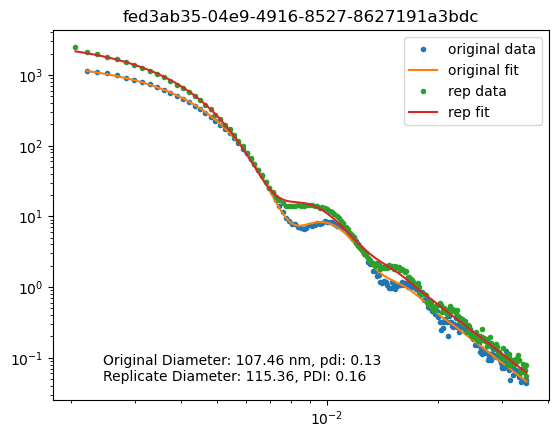

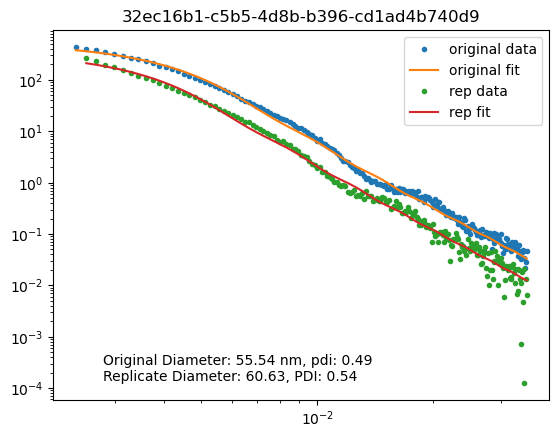

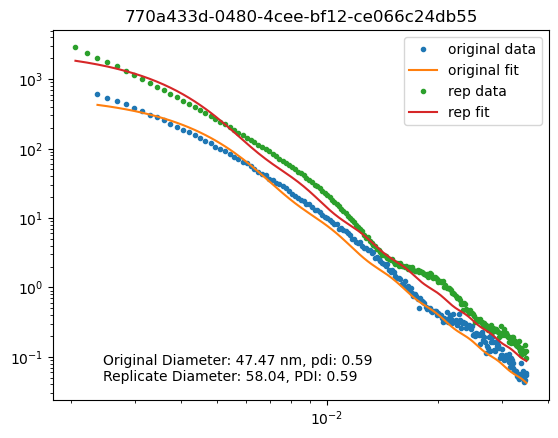

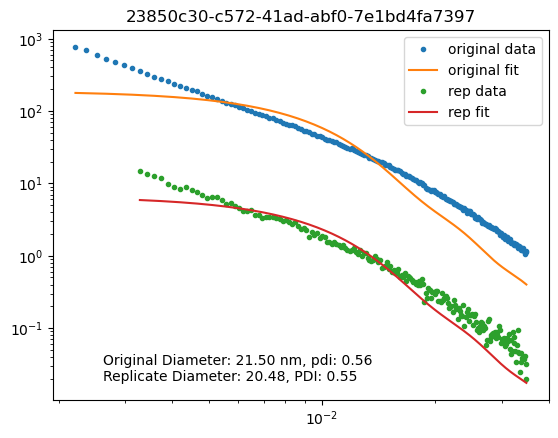

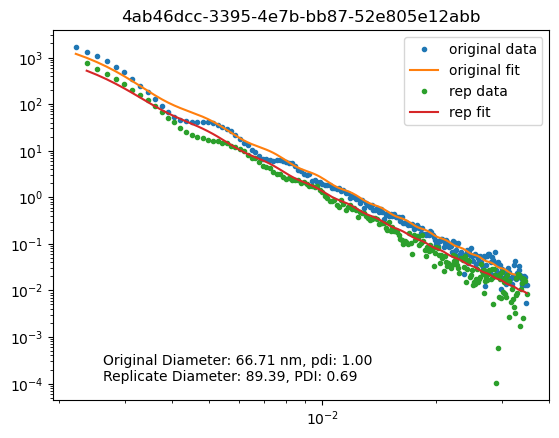

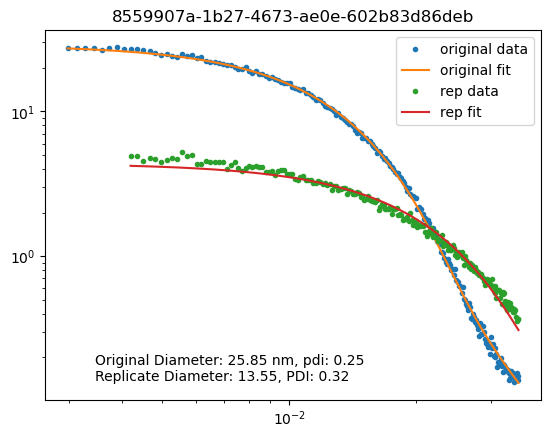

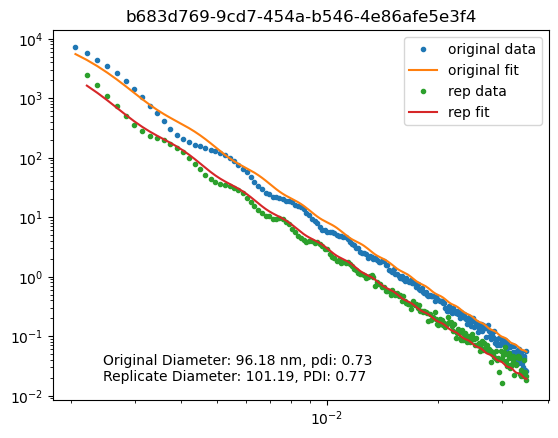

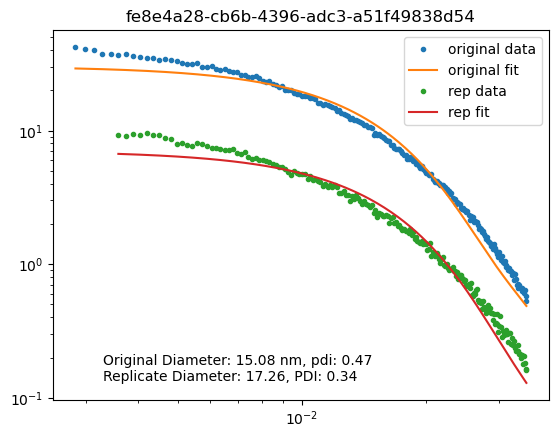

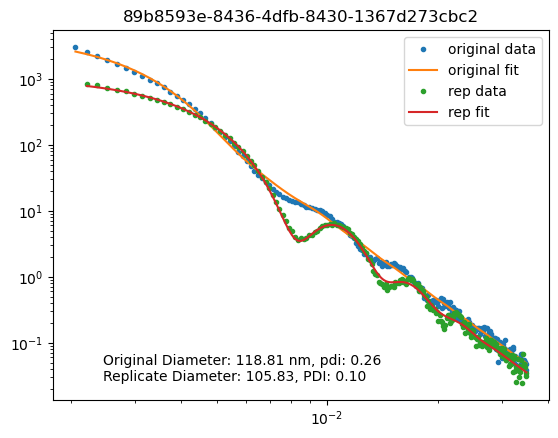

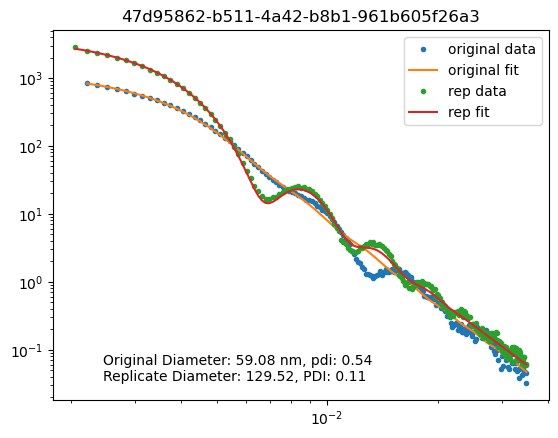

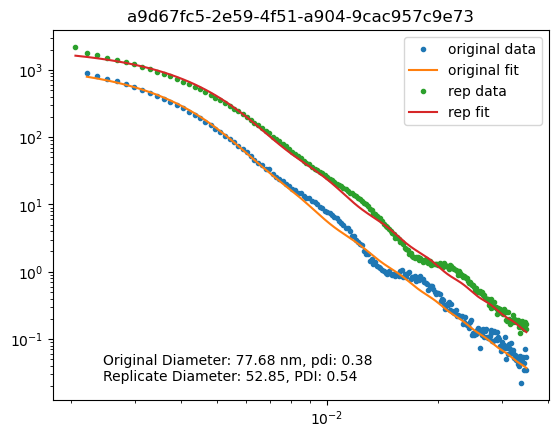

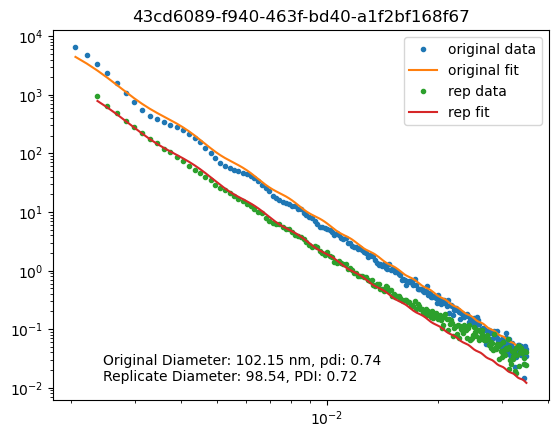

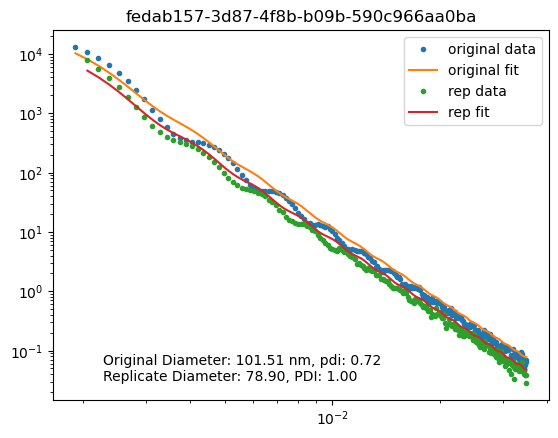

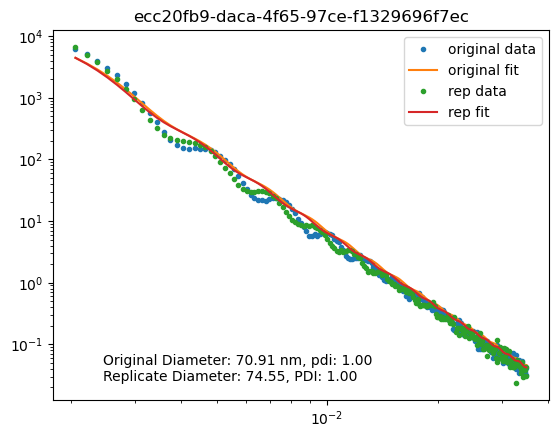

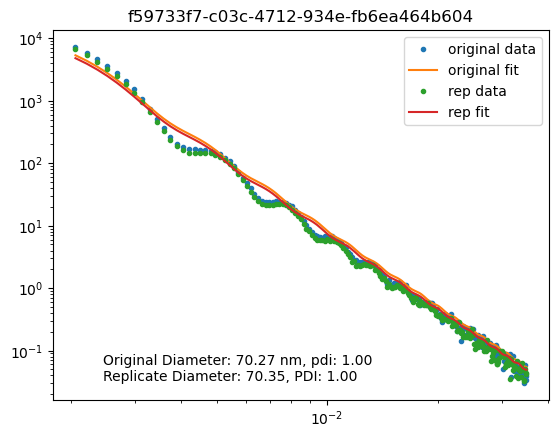

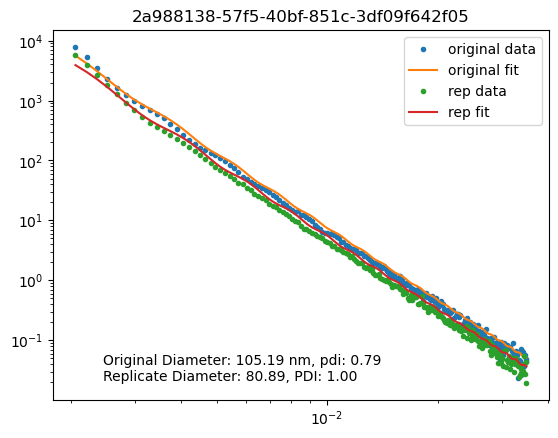

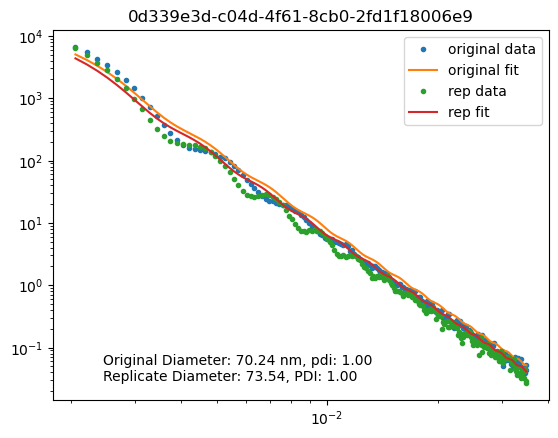

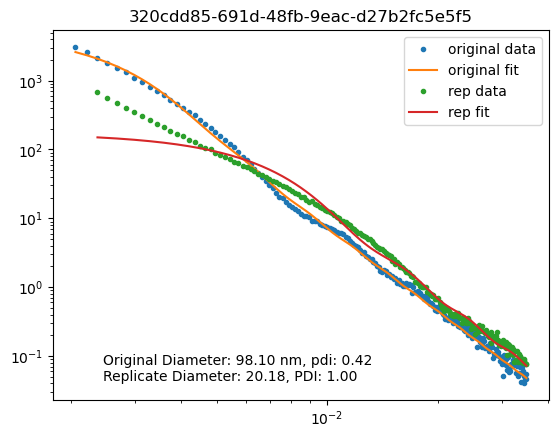

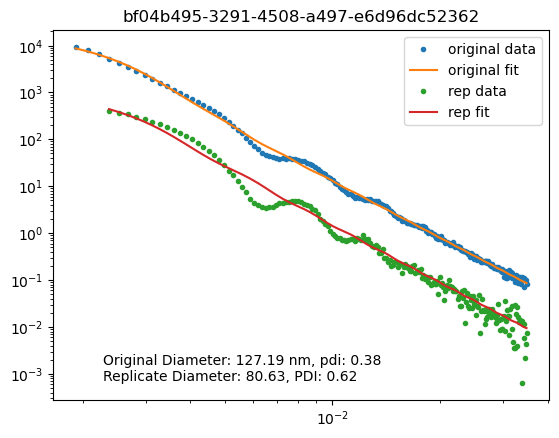

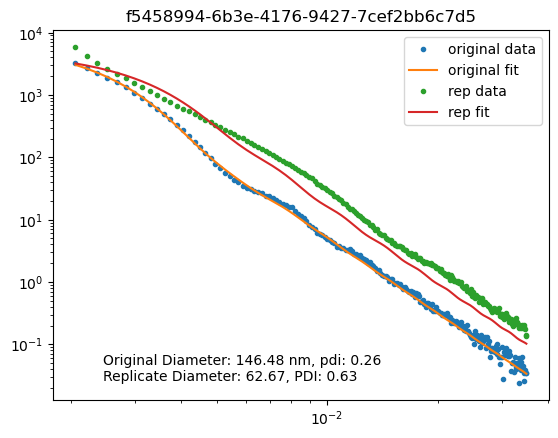

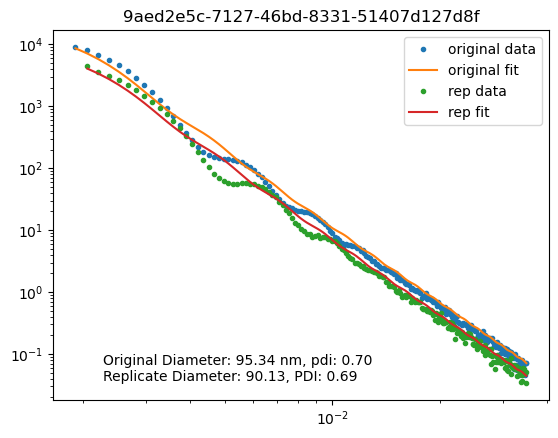

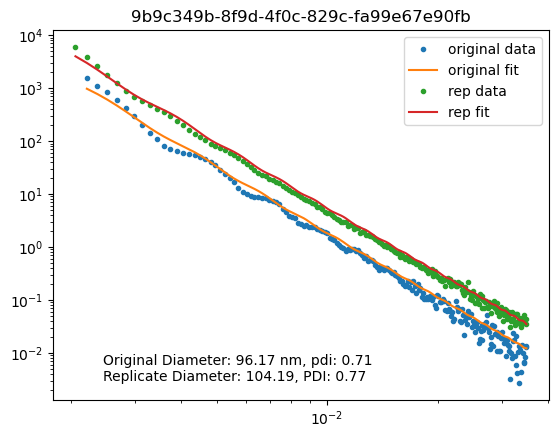

In [60]:
d_dif = []
pdi_dif = []

for og, rep in mapper.items():
    try:
        og_dat = processing_dataset[og]
        rep_dat = processing_dataset[rep]
    except KeyError:
        print(f'key error for {og}, {rep} pair')
        continue

    fig, ax = plt.subplots()
    
    for model in og_dat['sphere_fit_problem'].models:
        og_q = model._data.x
        og_I = model._data.y
        og_Icalc = model.Iq_calc

    og_d = og_dat['sphere_fit_results']['radius']*2/10
    og_pdi = og_dat['sphere_fit_results']['radius_pd']

    rep_d = rep_dat['sphere_fit_results']['radius']*2/10
    rep_pdi =rep_dat['sphere_fit_results']['radius_pd']

    for model in rep_dat['sphere_fit_problem'].models:
        rep_q = model._data.x
        rep_I = model._data.y
        rep_Icalc = model.Iq_calc

    ax.loglog(og_q, og_I, marker = '.', ls = '', label = 'original data')
    ax.loglog(og_q, og_Icalc, label = 'original fit')

    ax.loglog(rep_q, rep_I, marker = '.', ls = '', label = 'rep data')
    ax.loglog(rep_q, rep_Icalc, label = 'rep fit')

    ax.text(0.1, 0.05, f'Original Diameter: {og_d:.2f} nm, pdi: {og_pdi:.2f}\nReplicate Diameter: {rep_d:.2f}, PDI: {rep_pdi:.2f}', transform = ax.transAxes)
    ax.legend()
    ax.set_title(og)

    d_dif.append(abs(og_d - rep_d))
    pdi_dif.append(abs(og_pdi - rep_pdi))



    



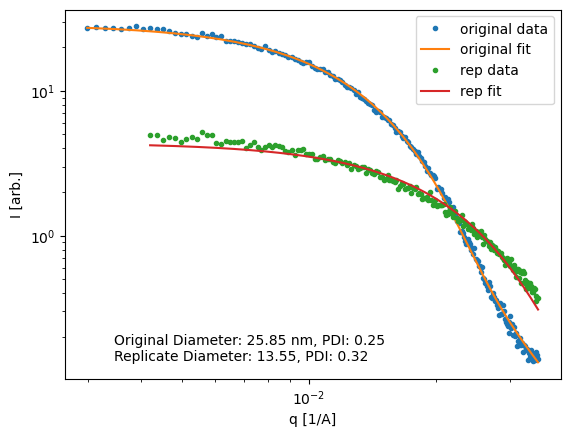

In [66]:
d_dif = []
pdi_dif = []

for og, rep in mapper.items():
    if '85599' in og:
        og_dat = processing_dataset[og]
        rep_dat = processing_dataset[rep]
    
        fig, ax = plt.subplots()
        
        for model in og_dat['sphere_fit_problem'].models:
            og_q = model._data.x
            og_I = model._data.y
            og_Icalc = model.Iq_calc
    
        og_d = og_dat['sphere_fit_results']['radius']*2/10
        og_pdi = og_dat['sphere_fit_results']['radius_pd']
    
        rep_d = rep_dat['sphere_fit_results']['radius']*2/10
        rep_pdi =rep_dat['sphere_fit_results']['radius_pd']
    
        for model in rep_dat['sphere_fit_problem'].models:
            rep_q = model._data.x
            rep_I = model._data.y
            rep_Icalc = model.Iq_calc
    
        ax.loglog(og_q, og_I, marker = '.', ls = '', label = 'original data')
        ax.loglog(og_q, og_Icalc, label = 'original fit')
    
        ax.loglog(rep_q, rep_I, marker = '.', ls = '', label = 'rep data')
        ax.loglog(rep_q, rep_Icalc, label = 'rep fit')
    
        ax.text(0.1, 0.05, f'Original Diameter: {og_d:.2f} nm, PDI: {og_pdi:.2f}\nReplicate Diameter: {rep_d:.2f}, PDI: {rep_pdi:.2f}', transform = ax.transAxes)
        ax.legend()
        ax.set_xlabel('q [1/A]')
        ax.set_ylabel('I [arb.]')
        #ax.set_title(og)
    
        d_dif.append(abs(og_d - rep_d))
        pdi_dif.append(abs(og_pdi - rep_pdi))

        plt.savefig(f'worst_case_{og}.png', dpi = 300)


In [52]:
d_dif = []
pdi_dif = []

for og, rep in mapper.items():
    if 'fed3ab' in og:
        og_dat = processing_dataset[og]
        rep_dat = processing_dataset[rep]
    
        fig, ax = plt.subplots()
        
        for model in og_dat['sphere_fit_problem'].models:
            og_q = model._data.x
            og_I = model._data.y
            og_Icalc = model.Iq_calc
    
        og_d = og_dat['sphere_fit_results']['radius']*2/10
        og_pdi = og_dat['sphere_fit_results']['radius_pd']
    
        rep_d = rep_dat['sphere_fit_results']['radius']*2/10
        rep_pdi =rep_dat['sphere_fit_results']['radius_pd']
    
        for model in rep_dat['sphere_fit_problem'].models:
            rep_q = model._data.x
            rep_I = model._data.y
            rep_Icalc = model.Iq_calc
    
        ax.loglog(og_q, og_I, marker = '.', ls = '', label = 'original data')
        ax.loglog(og_q, og_Icalc, label = 'original fit')
    
        ax.loglog(rep_q, rep_I, marker = '.', ls = '', label = 'rep data')
        ax.loglog(rep_q, rep_Icalc, label = 'rep fit')
    
        ax.text(0.1, 0.05, f'Original Diameter: {og_d:.2f} nm, PDI: {og_pdi:.2f}\nReplicate Diameter: {rep_d:.2f}, PDI: {rep_pdi:.2f}', transform = ax.transAxes)
        ax.legend()
        ax.set_xlabel('q [1/A]')
        ax.set_ylabel('I [arb.]')
        #ax.set_title(og)
    
        d_dif.append(abs(og_d - rep_d))
        pdi_dif.append(abs(og_pdi - rep_pdi))

        plt.savefig(f'typical_case_{og}.png', dpi = 300)

20.63852501038292

In [54]:
d_dif_reduced = [d for d in d_dif if d < 40]

In [58]:
pdi_dif_reduced = [pdi for i, pdi in enumerate(pdi_dif) if d_dif[i] < 40]

(array([11.,  3.,  4.,  0.,  0.,  1.,  0.,  0.,  1.,  2.]),
 array([7.36550517e-02, 8.44733501e+00, 1.68210150e+01, 2.51946949e+01,
        3.35683749e+01, 4.19420548e+01, 5.03157348e+01, 5.86894147e+01,
        6.70630947e+01, 7.54367746e+01, 8.38104546e+01]),
 <BarContainer object of 10 artists>)

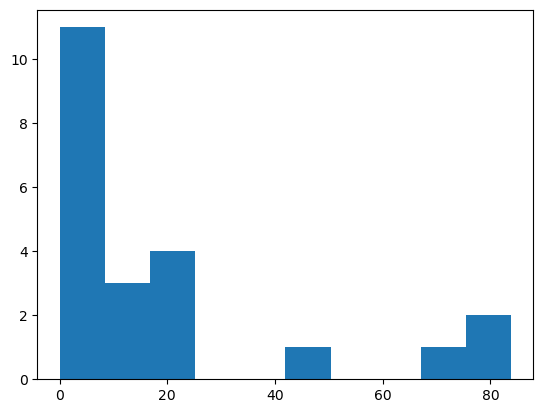

In [53]:
plt.hist(d_dif)

In [55]:
np.mean(d_dif_reduced)

9.739672110397901

In [59]:
np.mean(pdi_dif_reduced)

0.08543042370344917